In [1]:
!pip install transformers==3.4.0

     |████████████████████████████████| 1.3 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 8.7 MB/s eta 0:00:01
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.4.0 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [22]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
import transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, RobertaTokenizer, RobertaModel, TFXLMRobertaModel
from transformers import AutoTokenizer,TFXLMRobertaModel, XLMRobertaModel,XLMTokenizer,XLMWithLMHeadModel
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
import matplotlib.pyplot as plt
import numpy as np

In [23]:
transformers.__version__

'3.4.0'

In [24]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [25]:
train = pd.read_csv('../input/modified/train_modified.csv')
valid = pd.read_csv('../input/modified/val_modified.csv')
test = pd.read_csv('../input/modified/test_modified.csv')

In [26]:
xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [27]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
# tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024')
max_len = 200

In [28]:
xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [29]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5), loss=loss, metrics=['accuracy'])

    return model

In [30]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tfxlm_roberta_model_1 (TFXLM ((None, 200, 768), (None, 278043648 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3076      
Total params: 278,046,724
Trainable params: 278,046,724
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Batch Size 32
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32) 

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.28 - ETA: 5s - loss: 1.4008 - accuracy: 0.28 - ETA: 7s - loss: 1.4233 - accuracy: 0.23 - ETA: 7s - loss: 1.4223 - accuracy: 0.24 - ETA: 8s - loss: 1.4225 - accuracy: 0.23 - ETA: 8s - loss: 1.4225 - accuracy: 0.23 - ETA: 8s - loss: 1.4205 - accuracy: 0.22 - ETA: 8s - loss: 1.4171 - accuracy: 0.23 - ETA: 8s - loss: 1.4171 - accuracy: 0.23 - ETA: 8s - loss: 1.4200 - accuracy: 0.23 - ETA: 8s - loss: 1.4123 - accuracy: 0.25 - ETA: 8s - loss: 1.4110 - accuracy: 0.25 - ETA: 8s - loss: 1.4133 - accuracy: 0.25 - ETA: 8s - loss: 1.4184 - accuracy: 0.24 - ETA: 8s - loss: 1.4209 - accuracy: 0.24 - ETA: 8s - loss: 1.4192 - accuracy: 0.25 - ETA: 8s - loss: 1.4231 - accuracy: 0.24 - ETA: 7s - loss: 1.4229 - accuracy: 0.24 - ETA: 7s - loss: 1.4235 - accuracy: 0.23 - ETA: 7s - loss: 1.4233 - accuracy: 0.23 - ETA: 7s - loss: 1.4222 - accuracy: 0.23 - ETA: 8s - loss: 1.4203 - accuracy: 0.23 - ETA: 8s - loss: 1.4207 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.25 - ETA: 4s - loss: 1.3888 - accuracy: 0.28 - ETA: 6s - loss: 1.3793 - accuracy: 0.31 - ETA: 7s - loss: 1.3811 - accuracy: 0.30 - ETA: 7s - loss: 1.3874 - accuracy: 0.28 - ETA: 8s - loss: 1.3863 - accuracy: 0.27 - ETA: 8s - loss: 1.3884 - accuracy: 0.28 - ETA: 8s - loss: 1.3922 - accuracy: 0.26 - ETA: 8s - loss: 1.3896 - accuracy: 0.27 - ETA: 8s - loss: 1.3932 - accuracy: 0.26 - ETA: 8s - loss: 1.3962 - accuracy: 0.25 - ETA: 8s - loss: 1.3955 - accuracy: 0.26 - ETA: 8s - loss: 1.3975 - accuracy: 0.25 - ETA: 8s - loss: 1.3960 - accuracy: 0.26 - ETA: 8s - loss: 1.3975 - accuracy: 0.26 - ETA: 7s - loss: 1.3968 - accuracy: 0.26 - ETA: 7s - loss: 1.3956 - accuracy: 0.26 - ETA: 7s - loss: 1.3948 - accuracy: 0.26 - ETA: 7s - loss: 1.3947 - accuracy: 0.26 - ETA: 7s - loss: 1.3928 - accuracy: 0.27 - ETA: 7s - loss: 1.3907 - accuracy: 0.27 - ETA: 7s - loss: 1.3894 - accuracy: 0.27 - ETA: 7s - loss: 1.3873 

Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 1.3555 - accuracy: 0.34 - ETA: 5s - loss: 1.3787 - accuracy: 0.28 - ETA: 6s - loss: 1.3889 - accuracy: 0.26 - ETA: 7s - loss: 1.3776 - accuracy: 0.27 - ETA: 7s - loss: 1.3723 - accuracy: 0.28 - ETA: 8s - loss: 1.3655 - accuracy: 0.31 - ETA: 8s - loss: 1.3733 - accuracy: 0.30 - ETA: 8s - loss: 1.3784 - accuracy: 0.29 - ETA: 8s - loss: 1.3792 - accuracy: 0.29 - ETA: 8s - loss: 1.3803 - accuracy: 0.29 - ETA: 8s - loss: 1.3821 - accuracy: 0.28 - ETA: 8s - loss: 1.3832 - accuracy: 0.28 - ETA: 8s - loss: 1.3831 - accuracy: 0.29 - ETA: 8s - loss: 1.3803 - accuracy: 0.30 - ETA: 8s - loss: 1.3807 - accuracy: 0.30 - ETA: 8s - loss: 1.3781 - accuracy: 0.30 - ETA: 7s - loss: 1.3765 - accuracy: 0.30 - ETA: 7s - loss: 1.3765 - accuracy: 0.30 - ETA: 7s - loss: 1.3762 - accuracy: 0.30 - ETA: 7s - loss: 1.3754 - accuracy: 0.29 - ETA: 7s - loss: 1.3768 - accuracy: 0.29 - ETA: 7s - loss: 1.3755 - accuracy: 0.29 - ETA: 7s - loss: 1.3747 

Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 1.2888 - accuracy: 0.46 - ETA: 4s - loss: 1.3144 - accuracy: 0.39 - ETA: 6s - loss: 1.3571 - accuracy: 0.32 - ETA: 7s - loss: 1.3384 - accuracy: 0.35 - ETA: 7s - loss: 1.3430 - accuracy: 0.35 - ETA: 7s - loss: 1.3140 - accuracy: 0.40 - ETA: 8s - loss: 1.2944 - accuracy: 0.43 - ETA: 8s - loss: 1.2919 - accuracy: 0.44 - ETA: 8s - loss: 1.2885 - accuracy: 0.44 - ETA: 8s - loss: 1.2794 - accuracy: 0.46 - ETA: 8s - loss: 1.2763 - accuracy: 0.46 - ETA: 8s - loss: 1.2787 - accuracy: 0.46 - ETA: 8s - loss: 1.2825 - accuracy: 0.45 - ETA: 8s - loss: 1.2807 - accuracy: 0.45 - ETA: 8s - loss: 1.2823 - accuracy: 0.44 - ETA: 8s - loss: 1.2839 - accuracy: 0.44 - ETA: 8s - loss: 1.2833 - accuracy: 0.44 - ETA: 7s - loss: 1.2811 - accuracy: 0.44 - ETA: 7s - loss: 1.2808 - accuracy: 0.44 - ETA: 7s - loss: 1.2769 - accuracy: 0.45 - ETA: 7s - loss: 1.2764 - accuracy: 0.45 - ETA: 7s - loss: 1.2689 - accuracy: 0.46 - ETA: 7s - loss: 1.2693 

Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 1.1243 - accuracy: 0.62 - ETA: 4s - loss: 0.9921 - accuracy: 0.73 - ETA: 6s - loss: 1.0144 - accuracy: 0.70 - ETA: 7s - loss: 1.0285 - accuracy: 0.70 - ETA: 8s - loss: 1.0254 - accuracy: 0.70 - ETA: 8s - loss: 1.0131 - accuracy: 0.71 - ETA: 8s - loss: 1.0162 - accuracy: 0.71 - ETA: 8s - loss: 1.0295 - accuracy: 0.70 - ETA: 8s - loss: 1.0319 - accuracy: 0.70 - ETA: 8s - loss: 1.0329 - accuracy: 0.70 - ETA: 8s - loss: 1.0463 - accuracy: 0.69 - ETA: 8s - loss: 1.0512 - accuracy: 0.68 - ETA: 8s - loss: 1.0441 - accuracy: 0.69 - ETA: 8s - loss: 1.0542 - accuracy: 0.68 - ETA: 8s - loss: 1.0656 - accuracy: 0.67 - ETA: 8s - loss: 1.0635 - accuracy: 0.67 - ETA: 8s - loss: 1.0527 - accuracy: 0.68 - ETA: 8s - loss: 1.0465 - accuracy: 0.69 - ETA: 8s - loss: 1.0436 - accuracy: 0.69 - ETA: 8s - loss: 1.0390 - accuracy: 0.70 - ETA: 8s - loss: 1.0398 - accuracy: 0.69 - ETA: 8s - loss: 1.0418 - accuracy: 0.69 - ETA: 7s - loss: 1.0367 

Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 0.9047 - accuracy: 0.84 - ETA: 4s - loss: 0.9048 - accuracy: 0.84 - ETA: 6s - loss: 0.8893 - accuracy: 0.85 - ETA: 7s - loss: 0.9280 - accuracy: 0.82 - ETA: 7s - loss: 0.9228 - accuracy: 0.82 - ETA: 8s - loss: 0.9340 - accuracy: 0.80 - ETA: 9s - loss: 0.9124 - accuracy: 0.83 - ETA: 9s - loss: 0.9238 - accuracy: 0.82 - ETA: 9s - loss: 0.9201 - accuracy: 0.82 - ETA: 9s - loss: 0.9310 - accuracy: 0.81 - ETA: 8s - loss: 0.9254 - accuracy: 0.81 - ETA: 8s - loss: 0.9345 - accuracy: 0.80 - ETA: 8s - loss: 0.9346 - accuracy: 0.80 - ETA: 8s - loss: 0.9315 - accuracy: 0.80 - ETA: 8s - loss: 0.9376 - accuracy: 0.80 - ETA: 8s - loss: 0.9425 - accuracy: 0.79 - ETA: 8s - loss: 0.9409 - accuracy: 0.79 - ETA: 8s - loss: 0.9344 - accuracy: 0.80 - ETA: 8s - loss: 0.9342 - accuracy: 0.80 - ETA: 8s - loss: 0.9393 - accuracy: 0.80 - ETA: 8s - loss: 0.9346 - accuracy: 0.80 - ETA: 7s - loss: 0.9363 - accuracy: 0.80 - ETA: 7s - loss: 0.9388

Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.87 - ETA: 5s - loss: 0.9100 - accuracy: 0.84 - ETA: 6s - loss: 0.8978 - accuracy: 0.85 - ETA: 7s - loss: 0.8917 - accuracy: 0.85 - ETA: 7s - loss: 0.8928 - accuracy: 0.85 - ETA: 8s - loss: 0.8906 - accuracy: 0.85 - ETA: 8s - loss: 0.8952 - accuracy: 0.84 - ETA: 8s - loss: 0.9043 - accuracy: 0.83 - ETA: 8s - loss: 0.9315 - accuracy: 0.80 - ETA: 8s - loss: 0.9315 - accuracy: 0.80 - ETA: 8s - loss: 0.9358 - accuracy: 0.80 - ETA: 8s - loss: 0.9439 - accuracy: 0.79 - ETA: 8s - loss: 0.9445 - accuracy: 0.79 - ETA: 8s - loss: 0.9479 - accuracy: 0.78 - ETA: 8s - loss: 0.9533 - accuracy: 0.77 - ETA: 8s - loss: 0.9696 - accuracy: 0.75 - ETA: 8s - loss: 0.9807 - accuracy: 0.74 - ETA: 7s - loss: 0.9817 - accuracy: 0.74 - ETA: 7s - loss: 0.9852 - accuracy: 0.74 - ETA: 7s - loss: 0.9950 - accuracy: 0.73 - ETA: 7s - loss: 1.0017 - accuracy: 0.72 - ETA: 7s - loss: 1.0086 - accuracy: 0.71 - ETA: 7s - loss: 1.0143

Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.9455 - accuracy: 0.78 - ETA: 4s - loss: 0.9415 - accuracy: 0.78 - ETA: 6s - loss: 0.9426 - accuracy: 0.78 - ETA: 7s - loss: 0.9408 - accuracy: 0.78 - ETA: 7s - loss: 0.9413 - accuracy: 0.79 - ETA: 7s - loss: 0.9491 - accuracy: 0.78 - ETA: 8s - loss: 0.9498 - accuracy: 0.78 - ETA: 8s - loss: 0.9374 - accuracy: 0.80 - ETA: 8s - loss: 0.9299 - accuracy: 0.80 - ETA: 8s - loss: 0.9359 - accuracy: 0.80 - ETA: 8s - loss: 0.9275 - accuracy: 0.81 - ETA: 8s - loss: 0.9300 - accuracy: 0.80 - ETA: 8s - loss: 0.9208 - accuracy: 0.81 - ETA: 8s - loss: 0.9209 - accuracy: 0.81 - ETA: 8s - loss: 0.9266 - accuracy: 0.81 - ETA: 8s - loss: 0.9257 - accuracy: 0.81 - ETA: 7s - loss: 0.9225 - accuracy: 0.81 - ETA: 7s - loss: 0.9161 - accuracy: 0.82 - ETA: 7s - loss: 0.9193 - accuracy: 0.82 - ETA: 7s - loss: 0.9162 - accuracy: 0.82 - ETA: 7s - loss: 0.9223 - accuracy: 0.81 - ETA: 7s - loss: 0.9189 - accuracy: 0.82 - ETA: 7s - loss: 0.9181

Epoch 17/100
94/94 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.93 - ETA: 4s - loss: 0.8603 - accuracy: 0.87 - ETA: 6s - loss: 0.8620 - accuracy: 0.87 - ETA: 7s - loss: 0.8423 - accuracy: 0.89 - ETA: 7s - loss: 0.8540 - accuracy: 0.88 - ETA: 8s - loss: 0.8621 - accuracy: 0.87 - ETA: 8s - loss: 0.8566 - accuracy: 0.88 - ETA: 8s - loss: 0.8597 - accuracy: 0.87 - ETA: 8s - loss: 0.8715 - accuracy: 0.86 - ETA: 8s - loss: 0.8737 - accuracy: 0.86 - ETA: 8s - loss: 0.8723 - accuracy: 0.86 - ETA: 8s - loss: 0.8675 - accuracy: 0.87 - ETA: 8s - loss: 0.8640 - accuracy: 0.87 - ETA: 8s - loss: 0.8708 - accuracy: 0.87 - ETA: 8s - loss: 0.8710 - accuracy: 0.87 - ETA: 7s - loss: 0.8747 - accuracy: 0.86 - ETA: 7s - loss: 0.8770 - accuracy: 0.86 - ETA: 7s - loss: 0.8782 - accuracy: 0.86 - ETA: 7s - loss: 0.8760 - accuracy: 0.86 - ETA: 7s - loss: 0.8741 - accuracy: 0.86 - ETA: 7s - loss: 0.8758 - accuracy: 0.86 - ETA: 7s - loss: 0.8762 - accuracy: 0.86 - ETA: 7s - loss: 0.8713

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.8871 - accuracy: 0.84 - ETA: 4s - loss: 0.8579 - accuracy: 0.87 - ETA: 6s - loss: 0.8970 - accuracy: 0.84 - ETA: 7s - loss: 0.8741 - accuracy: 0.87 - ETA: 7s - loss: 0.8825 - accuracy: 0.86 - ETA: 7s - loss: 0.8793 - accuracy: 0.86 - ETA: 8s - loss: 0.8774 - accuracy: 0.86 - ETA: 8s - loss: 0.8730 - accuracy: 0.87 - ETA: 8s - loss: 0.8622 - accuracy: 0.88 - ETA: 8s - loss: 0.8635 - accuracy: 0.88 - ETA: 8s - loss: 0.8641 - accuracy: 0.88 - ETA: 8s - loss: 0.8592 - accuracy: 0.88 - ETA: 8s - loss: 0.8602 - accuracy: 0.88 - ETA: 8s - loss: 0.8522 - accuracy: 0.89 - ETA: 8s - loss: 0.8524 - accuracy: 0.89 - ETA: 8s - loss: 0.8478 - accuracy: 0.89 - ETA: 7s - loss: 0.8494 - accuracy: 0.89 - ETA: 7s - loss: 0.8496 - accuracy: 0.89 - ETA: 7s - loss: 0.8518 - accuracy: 0.89 - ETA: 7s - loss: 0.8576 - accuracy: 0.88 - ETA: 7s - loss: 0.8576 - accuracy: 0.88 - ETA: 7s - loss: 0.8585 - accuracy: 0.88 - ETA: 7s - loss: 0.8610

Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.90 - ETA: 5s - loss: 0.8326 - accuracy: 0.90 - ETA: 6s - loss: 0.8792 - accuracy: 0.85 - ETA: 7s - loss: 0.8788 - accuracy: 0.85 - ETA: 7s - loss: 0.8581 - accuracy: 0.88 - ETA: 8s - loss: 0.8469 - accuracy: 0.89 - ETA: 8s - loss: 0.8462 - accuracy: 0.89 - ETA: 8s - loss: 0.8670 - accuracy: 0.87 - ETA: 8s - loss: 0.8683 - accuracy: 0.87 - ETA: 8s - loss: 0.8681 - accuracy: 0.87 - ETA: 8s - loss: 0.8689 - accuracy: 0.86 - ETA: 8s - loss: 0.8621 - accuracy: 0.87 - ETA: 8s - loss: 0.8603 - accuracy: 0.87 - ETA: 8s - loss: 0.8559 - accuracy: 0.88 - ETA: 8s - loss: 0.8506 - accuracy: 0.88 - ETA: 8s - loss: 0.8479 - accuracy: 0.89 - ETA: 8s - loss: 0.8449 - accuracy: 0.89 - ETA: 7s - loss: 0.8416 - accuracy: 0.89 - ETA: 7s - loss: 0.8441 - accuracy: 0.89 - ETA: 7s - loss: 0.8452 - accuracy: 0.89 - ETA: 7s - loss: 0.8444 - accuracy: 0.89 - ETA: 7s - loss: 0.8453 - accuracy: 0.89 - ETA: 7s - loss: 0.8489

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.87 - ETA: 4s - loss: 0.8732 - accuracy: 0.87 - ETA: 6s - loss: 0.8686 - accuracy: 0.87 - ETA: 7s - loss: 0.8452 - accuracy: 0.89 - ETA: 7s - loss: 0.8380 - accuracy: 0.90 - ETA: 7s - loss: 0.8290 - accuracy: 0.91 - ETA: 8s - loss: 0.8213 - accuracy: 0.92 - ETA: 9s - loss: 0.8165 - accuracy: 0.92 - ETA: 9s - loss: 0.8136 - accuracy: 0.93 - ETA: 9s - loss: 0.8161 - accuracy: 0.93 - ETA: 8s - loss: 0.8179 - accuracy: 0.92 - ETA: 8s - loss: 0.8210 - accuracy: 0.92 - ETA: 8s - loss: 0.8247 - accuracy: 0.92 - ETA: 8s - loss: 0.8233 - accuracy: 0.92 - ETA: 8s - loss: 0.8246 - accuracy: 0.92 - ETA: 8s - loss: 0.8231 - accuracy: 0.92 - ETA: 8s - loss: 0.8221 - accuracy: 0.92 - ETA: 8s - loss: 0.8250 - accuracy: 0.92 - ETA: 8s - loss: 0.8227 - accuracy: 0.92 - ETA: 8s - loss: 0.8218 - accuracy: 0.92 - ETA: 7s - loss: 0.8226 - accuracy: 0.92 - ETA: 7s - loss: 0.8247 - accuracy: 0.92 - ETA: 7s - loss: 0.8284

Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.93 - ETA: 4s - loss: 0.8331 - accuracy: 0.92 - ETA: 6s - loss: 0.8358 - accuracy: 0.91 - ETA: 7s - loss: 0.8304 - accuracy: 0.92 - ETA: 7s - loss: 0.8331 - accuracy: 0.91 - ETA: 7s - loss: 0.8445 - accuracy: 0.90 - ETA: 8s - loss: 0.8367 - accuracy: 0.91 - ETA: 8s - loss: 0.8406 - accuracy: 0.91 - ETA: 8s - loss: 0.8487 - accuracy: 0.90 - ETA: 8s - loss: 0.8384 - accuracy: 0.91 - ETA: 8s - loss: 0.8344 - accuracy: 0.91 - ETA: 8s - loss: 0.8287 - accuracy: 0.91 - ETA: 8s - loss: 0.8278 - accuracy: 0.92 - ETA: 8s - loss: 0.8219 - accuracy: 0.92 - ETA: 8s - loss: 0.8208 - accuracy: 0.92 - ETA: 7s - loss: 0.8255 - accuracy: 0.92 - ETA: 7s - loss: 0.8262 - accuracy: 0.92 - ETA: 7s - loss: 0.8239 - accuracy: 0.92 - ETA: 7s - loss: 0.8227 - accuracy: 0.92 - ETA: 7s - loss: 0.8221 - accuracy: 0.92 - ETA: 7s - loss: 0.8223 - accuracy: 0.92 - ETA: 7s - loss: 0.8247 - accuracy: 0.92 - ETA: 7s - loss: 0.8266

Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.84 - ETA: 5s - loss: 0.8881 - accuracy: 0.85 - ETA: 6s - loss: 0.8420 - accuracy: 0.90 - ETA: 7s - loss: 0.8255 - accuracy: 0.92 - ETA: 7s - loss: 0.8222 - accuracy: 0.92 - ETA: 8s - loss: 0.8216 - accuracy: 0.92 - ETA: 8s - loss: 0.8156 - accuracy: 0.93 - ETA: 8s - loss: 0.8194 - accuracy: 0.92 - ETA: 8s - loss: 0.8151 - accuracy: 0.93 - ETA: 8s - loss: 0.8080 - accuracy: 0.93 - ETA: 8s - loss: 0.8105 - accuracy: 0.93 - ETA: 8s - loss: 0.8071 - accuracy: 0.93 - ETA: 8s - loss: 0.8127 - accuracy: 0.93 - ETA: 8s - loss: 0.8125 - accuracy: 0.93 - ETA: 8s - loss: 0.8111 - accuracy: 0.93 - ETA: 8s - loss: 0.8158 - accuracy: 0.92 - ETA: 8s - loss: 0.8145 - accuracy: 0.92 - ETA: 7s - loss: 0.8147 - accuracy: 0.92 - ETA: 7s - loss: 0.8131 - accuracy: 0.92 - ETA: 7s - loss: 0.8121 - accuracy: 0.92 - ETA: 7s - loss: 0.8123 - accuracy: 0.93 - ETA: 7s - loss: 0.8120 - accuracy: 0.93 - ETA: 7s - loss: 0.8125

Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.93 - ETA: 4s - loss: 0.7914 - accuracy: 0.95 - ETA: 6s - loss: 0.8065 - accuracy: 0.93 - ETA: 7s - loss: 0.8063 - accuracy: 0.93 - ETA: 7s - loss: 0.8066 - accuracy: 0.93 - ETA: 8s - loss: 0.8169 - accuracy: 0.92 - ETA: 8s - loss: 0.8236 - accuracy: 0.91 - ETA: 8s - loss: 0.8156 - accuracy: 0.92 - ETA: 8s - loss: 0.8213 - accuracy: 0.92 - ETA: 8s - loss: 0.8140 - accuracy: 0.93 - ETA: 8s - loss: 0.8133 - accuracy: 0.93 - ETA: 8s - loss: 0.8124 - accuracy: 0.93 - ETA: 8s - loss: 0.8117 - accuracy: 0.93 - ETA: 8s - loss: 0.8113 - accuracy: 0.93 - ETA: 8s - loss: 0.8072 - accuracy: 0.93 - ETA: 8s - loss: 0.8071 - accuracy: 0.93 - ETA: 7s - loss: 0.8099 - accuracy: 0.93 - ETA: 7s - loss: 0.8115 - accuracy: 0.93 - ETA: 7s - loss: 0.8096 - accuracy: 0.93 - ETA: 7s - loss: 0.8141 - accuracy: 0.92 - ETA: 7s - loss: 0.8112 - accuracy: 0.93 - ETA: 7s - loss: 0.8123 - accuracy: 0.93 - ETA: 7s - loss: 0.8149

Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 1.00 - ETA: 4s - loss: 0.7597 - accuracy: 0.98 - ETA: 6s - loss: 0.7648 - accuracy: 0.97 - ETA: 7s - loss: 0.7595 - accuracy: 0.98 - ETA: 7s - loss: 0.7626 - accuracy: 0.98 - ETA: 8s - loss: 0.7699 - accuracy: 0.97 - ETA: 8s - loss: 0.7694 - accuracy: 0.97 - ETA: 8s - loss: 0.7855 - accuracy: 0.95 - ETA: 8s - loss: 0.7844 - accuracy: 0.95 - ETA: 8s - loss: 0.7834 - accuracy: 0.95 - ETA: 8s - loss: 0.7883 - accuracy: 0.95 - ETA: 8s - loss: 0.7981 - accuracy: 0.94 - ETA: 8s - loss: 0.8025 - accuracy: 0.93 - ETA: 8s - loss: 0.8083 - accuracy: 0.93 - ETA: 8s - loss: 0.8067 - accuracy: 0.93 - ETA: 8s - loss: 0.8058 - accuracy: 0.93 - ETA: 8s - loss: 0.8048 - accuracy: 0.93 - ETA: 7s - loss: 0.8032 - accuracy: 0.93 - ETA: 7s - loss: 0.8025 - accuracy: 0.93 - ETA: 7s - loss: 0.8030 - accuracy: 0.93 - ETA: 7s - loss: 0.8003 - accuracy: 0.94 - ETA: 7s - loss: 0.8006 - accuracy: 0.94 - ETA: 7s - loss: 0.8011

Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 0.8090 - accuracy: 0.93 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 6s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7770 - accuracy: 0.96 - ETA: 7s - loss: 0.7979 - accuracy: 0.94 - ETA: 8s - loss: 0.7946 - accuracy: 0.95 - ETA: 8s - loss: 0.7926 - accuracy: 0.95 - ETA: 8s - loss: 0.7976 - accuracy: 0.94 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7925 - accuracy: 0.95 - ETA: 8s - loss: 0.7964 - accuracy: 0.94 - ETA: 8s - loss: 0.8002 - accuracy: 0.94 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7979 - accuracy: 0.94 - ETA: 8s - loss: 0.7985 - accuracy: 0.94 - ETA: 7s - loss: 0.7998 - accuracy: 0.94 - ETA: 7s - loss: 0.8001 - accuracy: 0.94 - ETA: 8s - loss: 0.7994 - accuracy: 0.94 - ETA: 8s - loss: 0.8027 - accuracy: 0.94 - ETA: 8s - loss: 0.8043 - accuracy: 0.93 - ETA: 7s - loss: 0.8076 - accuracy: 0.93 - ETA: 7s - loss: 0.8076

Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.93 - ETA: 5s - loss: 0.8086 - accuracy: 0.93 - ETA: 6s - loss: 0.8182 - accuracy: 0.92 - ETA: 7s - loss: 0.8305 - accuracy: 0.91 - ETA: 7s - loss: 0.8132 - accuracy: 0.93 - ETA: 7s - loss: 0.8016 - accuracy: 0.94 - ETA: 8s - loss: 0.7933 - accuracy: 0.95 - ETA: 8s - loss: 0.7988 - accuracy: 0.94 - ETA: 8s - loss: 0.7973 - accuracy: 0.94 - ETA: 8s - loss: 0.7984 - accuracy: 0.94 - ETA: 8s - loss: 0.8048 - accuracy: 0.94 - ETA: 9s - loss: 0.8023 - accuracy: 0.94 - ETA: 9s - loss: 0.8026 - accuracy: 0.94 - ETA: 9s - loss: 0.8028 - accuracy: 0.94 - ETA: 8s - loss: 0.8014 - accuracy: 0.94 - ETA: 8s - loss: 0.7997 - accuracy: 0.94 - ETA: 8s - loss: 0.8009 - accuracy: 0.94 - ETA: 8s - loss: 0.7996 - accuracy: 0.94 - ETA: 8s - loss: 0.7967 - accuracy: 0.94 - ETA: 8s - loss: 0.7941 - accuracy: 0.95 - ETA: 8s - loss: 0.7932 - accuracy: 0.95 - ETA: 8s - loss: 0.7924 - accuracy: 0.95 - ETA: 7s - loss: 0.7930

Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.8160 - accuracy: 0.92 - ETA: 10s - loss: 0.7923 - accuracy: 0.947 - ETA: 11s - loss: 0.7840 - accuracy: 0.953 - ETA: 10s - loss: 0.7769 - accuracy: 0.962 - ETA: 10s - loss: 0.7817 - accuracy: 0.958 - ETA: 10s - loss: 0.7909 - accuracy: 0.950 - ETA: 10s - loss: 0.7900 - accuracy: 0.953 - ETA: 9s - loss: 0.7884 - accuracy: 0.954 - ETA: 9s - loss: 0.7904 - accuracy: 0.95 - ETA: 9s - loss: 0.7947 - accuracy: 0.94 - ETA: 9s - loss: 0.7982 - accuracy: 0.94 - ETA: 9s - loss: 0.7988 - accuracy: 0.94 - ETA: 9s - loss: 0.7954 - accuracy: 0.94 - ETA: 8s - loss: 0.7940 - accuracy: 0.95 - ETA: 8s - loss: 0.7948 - accuracy: 0.94 - ETA: 8s - loss: 0.7971 - accuracy: 0.94 - ETA: 8s - loss: 0.7948 - accuracy: 0.94 - ETA: 8s - loss: 0.7943 - accuracy: 0.95 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7978 - accuracy: 0.94 - ETA: 8s - loss: 0.7983 - accuracy: 0.94 - ETA: 7s -

Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.90 - ETA: 4s - loss: 0.8689 - accuracy: 0.87 - ETA: 6s - loss: 0.8280 - accuracy: 0.91 - ETA: 7s - loss: 0.8147 - accuracy: 0.92 - ETA: 7s - loss: 0.8070 - accuracy: 0.93 - ETA: 8s - loss: 0.8064 - accuracy: 0.93 - ETA: 8s - loss: 0.8020 - accuracy: 0.94 - ETA: 8s - loss: 0.7985 - accuracy: 0.94 - ETA: 8s - loss: 0.7976 - accuracy: 0.94 - ETA: 8s - loss: 0.7923 - accuracy: 0.95 - ETA: 8s - loss: 0.7906 - accuracy: 0.95 - ETA: 8s - loss: 0.7919 - accuracy: 0.95 - ETA: 8s - loss: 0.7956 - accuracy: 0.94 - ETA: 8s - loss: 0.7986 - accuracy: 0.94 - ETA: 8s - loss: 0.8040 - accuracy: 0.93 - ETA: 8s - loss: 0.8022 - accuracy: 0.94 - ETA: 7s - loss: 0.7988 - accuracy: 0.94 - ETA: 7s - loss: 0.7976 - accuracy: 0.94 - ETA: 7s - loss: 0.7978 - accuracy: 0.94 - ETA: 7s - loss: 0.8012 - accuracy: 0.94 - ETA: 7s - loss: 0.7985 - accuracy: 0.94 - ETA: 7s - loss: 0.7975 - accuracy: 0.94 - ETA: 7s - loss: 0.7951

Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.93 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 6s - loss: 0.7651 - accuracy: 0.97 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7939 - accuracy: 0.95 - ETA: 7s - loss: 0.7903 - accuracy: 0.95 - ETA: 7s - loss: 0.7894 - accuracy: 0.95 - ETA: 8s - loss: 0.7840 - accuracy: 0.96 - ETA: 8s - loss: 0.7835 - accuracy: 0.96 - ETA: 8s - loss: 0.7829 - accuracy: 0.96 - ETA: 8s - loss: 0.7820 - accuracy: 0.96 - ETA: 8s - loss: 0.7833 - accuracy: 0.96 - ETA: 8s - loss: 0.7899 - accuracy: 0.95 - ETA: 7s - loss: 0.7866 - accuracy: 0.95 - ETA: 7s - loss: 0.7838 - accuracy: 0.96 - ETA: 7s - loss: 0.7872 - accuracy: 0.95 - ETA: 7s - loss: 0.7901 - accuracy: 0.95 - ETA: 7s - loss: 0.7927 - accuracy: 0.95 - ETA: 7s - loss: 0.7918 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7902 - accuracy: 0.95 - ETA: 7s - loss: 0.7895 - accuracy: 0.95 - ETA: 7s - loss: 0.7903

Epoch 43/100
94/94 [==============================] - ETA: 0s - loss: 0.8073 - accuracy: 0.93 - ETA: 4s - loss: 0.7995 - accuracy: 0.95 - ETA: 6s - loss: 0.8015 - accuracy: 0.94 - ETA: 7s - loss: 0.8035 - accuracy: 0.94 - ETA: 7s - loss: 0.7977 - accuracy: 0.95 - ETA: 8s - loss: 0.7939 - accuracy: 0.95 - ETA: 8s - loss: 0.7913 - accuracy: 0.95 - ETA: 8s - loss: 0.7942 - accuracy: 0.95 - ETA: 8s - loss: 0.7956 - accuracy: 0.95 - ETA: 8s - loss: 0.7961 - accuracy: 0.94 - ETA: 8s - loss: 0.7970 - accuracy: 0.94 - ETA: 8s - loss: 0.7937 - accuracy: 0.95 - ETA: 8s - loss: 0.7965 - accuracy: 0.94 - ETA: 8s - loss: 0.7971 - accuracy: 0.94 - ETA: 8s - loss: 0.7977 - accuracy: 0.94 - ETA: 8s - loss: 0.7958 - accuracy: 0.94 - ETA: 8s - loss: 0.7946 - accuracy: 0.94 - ETA: 7s - loss: 0.7988 - accuracy: 0.94 - ETA: 7s - loss: 0.7959 - accuracy: 0.94 - ETA: 7s - loss: 0.7995 - accuracy: 0.94 - ETA: 7s - loss: 0.7984 - accuracy: 0.94 - ETA: 7s - loss: 0.7987 - accuracy: 0.94 - ETA: 7s - loss: 0.7977

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.96 - ETA: 5s - loss: 0.7754 - accuracy: 0.96 - ETA: 6s - loss: 0.7730 - accuracy: 0.96 - ETA: 7s - loss: 0.7736 - accuracy: 0.96 - ETA: 7s - loss: 0.7930 - accuracy: 0.95 - ETA: 8s - loss: 0.7848 - accuracy: 0.95 - ETA: 8s - loss: 0.7835 - accuracy: 0.95 - ETA: 8s - loss: 0.7863 - accuracy: 0.95 - ETA: 8s - loss: 0.7850 - accuracy: 0.95 - ETA: 8s - loss: 0.7809 - accuracy: 0.96 - ETA: 8s - loss: 0.7776 - accuracy: 0.96 - ETA: 8s - loss: 0.7800 - accuracy: 0.96 - ETA: 8s - loss: 0.7820 - accuracy: 0.96 - ETA: 8s - loss: 0.7833 - accuracy: 0.95 - ETA: 8s - loss: 0.7807 - accuracy: 0.96 - ETA: 8s - loss: 0.7805 - accuracy: 0.96 - ETA: 7s - loss: 0.7783 - accuracy: 0.96 - ETA: 7s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7773 - accuracy: 0.96 - ETA: 7s - loss: 0.7772 - accuracy: 0.96 - ETA: 7s - loss: 0.7771 - accuracy: 0.96 - ETA: 7s - loss: 0.7755 - accuracy: 0.96 - ETA: 7s - loss: 0.7768

Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7906 - accuracy: 0.95 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 7s - loss: 0.7677 - accuracy: 0.97 - ETA: 7s - loss: 0.7680 - accuracy: 0.97 - ETA: 8s - loss: 0.7693 - accuracy: 0.97 - ETA: 8s - loss: 0.7701 - accuracy: 0.97 - ETA: 8s - loss: 0.7704 - accuracy: 0.97 - ETA: 8s - loss: 0.7748 - accuracy: 0.96 - ETA: 8s - loss: 0.7780 - accuracy: 0.96 - ETA: 8s - loss: 0.7805 - accuracy: 0.96 - ETA: 8s - loss: 0.7800 - accuracy: 0.96 - ETA: 8s - loss: 0.7796 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7812 - accuracy: 0.96 - ETA: 8s - loss: 0.7808 - accuracy: 0.96 - ETA: 7s - loss: 0.7823 - accuracy: 0.96 - ETA: 7s - loss: 0.7854 - accuracy: 0.95 - ETA: 7s - loss: 0.7832 - accuracy: 0.96 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 7s - loss: 0.7796 - accuracy: 0.96 - ETA: 7s - loss: 0.7807

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.90 - ETA: 5s - loss: 0.8135 - accuracy: 0.92 - ETA: 6s - loss: 0.8172 - accuracy: 0.91 - ETA: 7s - loss: 0.8067 - accuracy: 0.92 - ETA: 7s - loss: 0.7941 - accuracy: 0.94 - ETA: 7s - loss: 0.7964 - accuracy: 0.94 - ETA: 8s - loss: 0.7889 - accuracy: 0.95 - ETA: 8s - loss: 0.7843 - accuracy: 0.95 - ETA: 8s - loss: 0.7798 - accuracy: 0.96 - ETA: 8s - loss: 0.7793 - accuracy: 0.96 - ETA: 8s - loss: 0.7765 - accuracy: 0.96 - ETA: 8s - loss: 0.7764 - accuracy: 0.96 - ETA: 8s - loss: 0.7764 - accuracy: 0.96 - ETA: 8s - loss: 0.7763 - accuracy: 0.96 - ETA: 8s - loss: 0.7742 - accuracy: 0.96 - ETA: 8s - loss: 0.7723 - accuracy: 0.97 - ETA: 8s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7787 - accuracy: 0.96 - ETA: 7s - loss: 0.7804 - accuracy: 0.96 - ETA: 7s - loss: 0.7802 - accuracy: 0.96 - ETA: 7s - loss: 0.7823 - accuracy: 0.95 - ETA: 7s - loss: 0.7808 - accuracy: 0.96 - ETA: 7s - loss: 0.7791

Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.96 - ETA: 4s - loss: 0.7781 - accuracy: 0.96 - ETA: 6s - loss: 0.7797 - accuracy: 0.96 - ETA: 7s - loss: 0.7884 - accuracy: 0.96 - ETA: 7s - loss: 0.7794 - accuracy: 0.96 - ETA: 7s - loss: 0.7739 - accuracy: 0.97 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7801 - accuracy: 0.96 - ETA: 8s - loss: 0.7830 - accuracy: 0.96 - ETA: 8s - loss: 0.7791 - accuracy: 0.96 - ETA: 8s - loss: 0.7788 - accuracy: 0.96 - ETA: 8s - loss: 0.7758 - accuracy: 0.96 - ETA: 8s - loss: 0.7766 - accuracy: 0.96 - ETA: 8s - loss: 0.7766 - accuracy: 0.96 - ETA: 7s - loss: 0.7787 - accuracy: 0.96 - ETA: 7s - loss: 0.7828 - accuracy: 0.96 - ETA: 7s - loss: 0.7839 - accuracy: 0.95 - ETA: 7s - loss: 0.7841 - accuracy: 0.96 - ETA: 7s - loss: 0.7848 - accuracy: 0.95 - ETA: 7s - loss: 0.7881 - accuracy: 0.95 - ETA: 7s - loss: 0.7861 - accuracy: 0.95 - ETA: 7s - loss: 0.7857 - accuracy: 0.95 - ETA: 7s - loss: 0.7854

Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.96 - ETA: 5s - loss: 0.7537 - accuracy: 0.98 - ETA: 6s - loss: 0.7708 - accuracy: 0.96 - ETA: 7s - loss: 0.7642 - accuracy: 0.97 - ETA: 7s - loss: 0.7913 - accuracy: 0.95 - ETA: 7s - loss: 0.7834 - accuracy: 0.95 - ETA: 8s - loss: 0.7822 - accuracy: 0.95 - ETA: 8s - loss: 0.7846 - accuracy: 0.95 - ETA: 8s - loss: 0.7836 - accuracy: 0.95 - ETA: 8s - loss: 0.7828 - accuracy: 0.95 - ETA: 8s - loss: 0.7846 - accuracy: 0.95 - ETA: 8s - loss: 0.7838 - accuracy: 0.95 - ETA: 8s - loss: 0.7808 - accuracy: 0.96 - ETA: 8s - loss: 0.7782 - accuracy: 0.96 - ETA: 8s - loss: 0.7839 - accuracy: 0.95 - ETA: 7s - loss: 0.7826 - accuracy: 0.95 - ETA: 7s - loss: 0.7821 - accuracy: 0.95 - ETA: 7s - loss: 0.7884 - accuracy: 0.95 - ETA: 7s - loss: 0.7877 - accuracy: 0.95 - ETA: 7s - loss: 0.7855 - accuracy: 0.95 - ETA: 7s - loss: 0.7866 - accuracy: 0.95 - ETA: 7s - loss: 0.7884 - accuracy: 0.95 - ETA: 7s - loss: 0.7879

Epoch 55/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 5s - loss: 0.8215 - accuracy: 0.92 - ETA: 6s - loss: 0.7959 - accuracy: 0.94 - ETA: 7s - loss: 0.8102 - accuracy: 0.92 - ETA: 7s - loss: 0.8156 - accuracy: 0.92 - ETA: 8s - loss: 0.8088 - accuracy: 0.93 - ETA: 8s - loss: 0.7995 - accuracy: 0.94 - ETA: 8s - loss: 0.7925 - accuracy: 0.94 - ETA: 8s - loss: 0.7974 - accuracy: 0.94 - ETA: 8s - loss: 0.7921 - accuracy: 0.95 - ETA: 8s - loss: 0.7918 - accuracy: 0.94 - ETA: 8s - loss: 0.7956 - accuracy: 0.94 - ETA: 8s - loss: 0.7950 - accuracy: 0.94 - ETA: 8s - loss: 0.7957 - accuracy: 0.94 - ETA: 8s - loss: 0.7938 - accuracy: 0.94 - ETA: 8s - loss: 0.7930 - accuracy: 0.94 - ETA: 8s - loss: 0.7920 - accuracy: 0.95 - ETA: 7s - loss: 0.7893 - accuracy: 0.95 - ETA: 7s - loss: 0.7918 - accuracy: 0.95 - ETA: 7s - loss: 0.7924 - accuracy: 0.95 - ETA: 7s - loss: 0.7930 - accuracy: 0.94 - ETA: 7s - loss: 0.7965 - accuracy: 0.94 - ETA: 7s - loss: 0.7956

Epoch 57/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7762 - accuracy: 0.96 - ETA: 6s - loss: 0.7653 - accuracy: 0.97 - ETA: 7s - loss: 0.7762 - accuracy: 0.96 - ETA: 7s - loss: 0.7697 - accuracy: 0.97 - ETA: 8s - loss: 0.7706 - accuracy: 0.97 - ETA: 8s - loss: 0.7712 - accuracy: 0.97 - ETA: 8s - loss: 0.7756 - accuracy: 0.96 - ETA: 8s - loss: 0.7739 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7770 - accuracy: 0.96 - ETA: 8s - loss: 0.7742 - accuracy: 0.96 - ETA: 9s - loss: 0.7719 - accuracy: 0.97 - ETA: 8s - loss: 0.7698 - accuracy: 0.97 - ETA: 8s - loss: 0.7723 - accuracy: 0.97 - ETA: 8s - loss: 0.7705 - accuracy: 0.97 - ETA: 8s - loss: 0.7689 - accuracy: 0.97 - ETA: 8s - loss: 0.7675 - accuracy: 0.97 - ETA: 8s - loss: 0.7695 - accuracy: 0.97 - ETA: 8s - loss: 0.7713 - accuracy: 0.97 - ETA: 8s - loss: 0.7715 - accuracy: 0.97 - ETA: 7s - loss: 0.7731 - accuracy: 0.97 - ETA: 7s - loss: 0.7732

Epoch 59/100
94/94 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.93 - ETA: 4s - loss: 0.7761 - accuracy: 0.96 - ETA: 6s - loss: 0.7964 - accuracy: 0.94 - ETA: 7s - loss: 0.7912 - accuracy: 0.95 - ETA: 9s - loss: 0.7817 - accuracy: 0.96 - ETA: 9s - loss: 0.7806 - accuracy: 0.96 - ETA: 9s - loss: 0.7753 - accuracy: 0.96 - ETA: 9s - loss: 0.7753 - accuracy: 0.96 - ETA: 9s - loss: 0.7753 - accuracy: 0.96 - ETA: 9s - loss: 0.7815 - accuracy: 0.96 - ETA: 9s - loss: 0.7809 - accuracy: 0.96 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7752 - accuracy: 0.96 - ETA: 8s - loss: 0.7755 - accuracy: 0.96 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7755 - accuracy: 0.96 - ETA: 8s - loss: 0.7736 - accuracy: 0.97 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7738 - accuracy: 0.97 - ETA: 7s - loss: 0.7724 - accuracy: 0.97 - ETA: 7s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7753

Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7750 - accuracy: 0.96 - ETA: 6s - loss: 0.7750 - accuracy: 0.96 - ETA: 7s - loss: 0.7857 - accuracy: 0.96 - ETA: 7s - loss: 0.7837 - accuracy: 0.96 - ETA: 8s - loss: 0.7770 - accuracy: 0.96 - ETA: 8s - loss: 0.7857 - accuracy: 0.95 - ETA: 8s - loss: 0.7804 - accuracy: 0.96 - ETA: 8s - loss: 0.7764 - accuracy: 0.96 - ETA: 8s - loss: 0.7762 - accuracy: 0.96 - ETA: 8s - loss: 0.7761 - accuracy: 0.96 - ETA: 8s - loss: 0.7734 - accuracy: 0.97 - ETA: 8s - loss: 0.7753 - accuracy: 0.96 - ETA: 8s - loss: 0.7736 - accuracy: 0.97 - ETA: 8s - loss: 0.7762 - accuracy: 0.96 - ETA: 8s - loss: 0.7781 - accuracy: 0.96 - ETA: 8s - loss: 0.7761 - accuracy: 0.96 - ETA: 8s - loss: 0.7760 - accuracy: 0.96 - ETA: 8s - loss: 0.7806 - accuracy: 0.96 - ETA: 8s - loss: 0.7804 - accuracy: 0.96 - ETA: 8s - loss: 0.7795 - accuracy: 0.96 - ETA: 8s - loss: 0.7793 - accuracy: 0.96 - ETA: 7s - loss: 0.7791

Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 5s - loss: 0.7462 - accuracy: 1.00 - ETA: 6s - loss: 0.7566 - accuracy: 0.98 - ETA: 7s - loss: 0.7612 - accuracy: 0.98 - ETA: 7s - loss: 0.7697 - accuracy: 0.97 - ETA: 8s - loss: 0.7653 - accuracy: 0.97 - ETA: 8s - loss: 0.7622 - accuracy: 0.98 - ETA: 8s - loss: 0.7677 - accuracy: 0.97 - ETA: 8s - loss: 0.7685 - accuracy: 0.97 - ETA: 8s - loss: 0.7692 - accuracy: 0.97 - ETA: 8s - loss: 0.7669 - accuracy: 0.97 - ETA: 8s - loss: 0.7649 - accuracy: 0.97 - ETA: 8s - loss: 0.7633 - accuracy: 0.98 - ETA: 8s - loss: 0.7641 - accuracy: 0.97 - ETA: 8s - loss: 0.7690 - accuracy: 0.97 - ETA: 8s - loss: 0.7693 - accuracy: 0.97 - ETA: 7s - loss: 0.7715 - accuracy: 0.97 - ETA: 7s - loss: 0.7734 - accuracy: 0.97 - ETA: 7s - loss: 0.7735 - accuracy: 0.97 - ETA: 7s - loss: 0.7751 - accuracy: 0.96 - ETA: 7s - loss: 0.7744 - accuracy: 0.96 - ETA: 7s - loss: 0.7758 - accuracy: 0.96 - ETA: 7s - loss: 0.7749

Epoch 65/100
94/94 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.96 - ETA: 4s - loss: 0.7776 - accuracy: 0.96 - ETA: 6s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7785 - accuracy: 0.96 - ETA: 7s - loss: 0.7715 - accuracy: 0.97 - ETA: 7s - loss: 0.7721 - accuracy: 0.97 - ETA: 8s - loss: 0.7717 - accuracy: 0.97 - ETA: 8s - loss: 0.7723 - accuracy: 0.97 - ETA: 8s - loss: 0.7700 - accuracy: 0.97 - ETA: 8s - loss: 0.7704 - accuracy: 0.97 - ETA: 8s - loss: 0.7708 - accuracy: 0.97 - ETA: 8s - loss: 0.7685 - accuracy: 0.97 - ETA: 8s - loss: 0.7714 - accuracy: 0.97 - ETA: 7s - loss: 0.7717 - accuracy: 0.97 - ETA: 7s - loss: 0.7719 - accuracy: 0.97 - ETA: 7s - loss: 0.7740 - accuracy: 0.97 - ETA: 7s - loss: 0.7722 - accuracy: 0.97 - ETA: 7s - loss: 0.7759 - accuracy: 0.96 - ETA: 7s - loss: 0.7775 - accuracy: 0.96 - ETA: 7s - loss: 0.7758 - accuracy: 0.96 - ETA: 7s - loss: 0.7757 - accuracy: 0.96 - ETA: 7s - loss: 0.7743 - accuracy: 0.97 - ETA: 7s - loss: 0.7729

Epoch 67/100
94/94 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.96 - ETA: 4s - loss: 0.7741 - accuracy: 0.96 - ETA: 6s - loss: 0.7640 - accuracy: 0.97 - ETA: 7s - loss: 0.7667 - accuracy: 0.97 - ETA: 7s - loss: 0.7684 - accuracy: 0.97 - ETA: 8s - loss: 0.7799 - accuracy: 0.96 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7754 - accuracy: 0.96 - ETA: 8s - loss: 0.7753 - accuracy: 0.96 - ETA: 8s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7838 - accuracy: 0.96 - ETA: 8s - loss: 0.7857 - accuracy: 0.95 - ETA: 8s - loss: 0.7824 - accuracy: 0.96 - ETA: 8s - loss: 0.7797 - accuracy: 0.96 - ETA: 8s - loss: 0.7814 - accuracy: 0.96 - ETA: 8s - loss: 0.7810 - accuracy: 0.96 - ETA: 8s - loss: 0.7807 - accuracy: 0.96 - ETA: 7s - loss: 0.7821 - accuracy: 0.96 - ETA: 7s - loss: 0.7817 - accuracy: 0.96 - ETA: 7s - loss: 0.7798 - accuracy: 0.96 - ETA: 7s - loss: 0.7810 - accuracy: 0.96 - ETA: 7s - loss: 0.7793 - accuracy: 0.96 - ETA: 7s - loss: 0.7786

Epoch 69/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7872 - accuracy: 0.95 - ETA: 6s - loss: 0.7727 - accuracy: 0.96 - ETA: 7s - loss: 0.7732 - accuracy: 0.96 - ETA: 7s - loss: 0.7736 - accuracy: 0.96 - ETA: 7s - loss: 0.7791 - accuracy: 0.96 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7813 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7738 - accuracy: 0.96 - ETA: 8s - loss: 0.7796 - accuracy: 0.96 - ETA: 8s - loss: 0.7792 - accuracy: 0.96 - ETA: 8s - loss: 0.7801 - accuracy: 0.96 - ETA: 8s - loss: 0.7798 - accuracy: 0.96 - ETA: 7s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7771 - accuracy: 0.96 - ETA: 7s - loss: 0.7809 - accuracy: 0.96 - ETA: 7s - loss: 0.7806 - accuracy: 0.96 - ETA: 7s - loss: 0.7786 - accuracy: 0.96 - ETA: 7s - loss: 0.7784 - accuracy: 0.96 - ETA: 7s - loss: 0.7768 - accuracy: 0.96 - ETA: 7s - loss: 0.7753 - accuracy: 0.96 - ETA: 7s - loss: 0.7767

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 1.00 - ETA: 4s - loss: 0.7488 - accuracy: 1.00 - ETA: 6s - loss: 0.7680 - accuracy: 0.97 - ETA: 7s - loss: 0.7777 - accuracy: 0.96 - ETA: 7s - loss: 0.7709 - accuracy: 0.97 - ETA: 7s - loss: 0.7768 - accuracy: 0.96 - ETA: 8s - loss: 0.7780 - accuracy: 0.96 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7739 - accuracy: 0.97 - ETA: 8s - loss: 0.7715 - accuracy: 0.97 - ETA: 8s - loss: 0.7691 - accuracy: 0.97 - ETA: 8s - loss: 0.7747 - accuracy: 0.97 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7738 - accuracy: 0.97 - ETA: 8s - loss: 0.7718 - accuracy: 0.97 - ETA: 7s - loss: 0.7701 - accuracy: 0.97 - ETA: 7s - loss: 0.7703 - accuracy: 0.97 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 7s - loss: 0.7708 - accuracy: 0.97 - ETA: 7s - loss: 0.7742 - accuracy: 0.97 - ETA: 7s - loss: 0.7727 - accuracy: 0.97 - ETA: 7s - loss: 0.7728 - accuracy: 0.97 - ETA: 7s - loss: 0.7716

Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7598 - accuracy: 0.98 - ETA: 6s - loss: 0.7617 - accuracy: 0.97 - ETA: 7s - loss: 0.7649 - accuracy: 0.97 - ETA: 7s - loss: 0.7607 - accuracy: 0.98 - ETA: 7s - loss: 0.7631 - accuracy: 0.97 - ETA: 8s - loss: 0.7648 - accuracy: 0.97 - ETA: 8s - loss: 0.7621 - accuracy: 0.98 - ETA: 8s - loss: 0.7612 - accuracy: 0.98 - ETA: 8s - loss: 0.7720 - accuracy: 0.97 - ETA: 8s - loss: 0.7694 - accuracy: 0.97 - ETA: 8s - loss: 0.7752 - accuracy: 0.96 - ETA: 8s - loss: 0.7728 - accuracy: 0.97 - ETA: 7s - loss: 0.7754 - accuracy: 0.96 - ETA: 7s - loss: 0.7733 - accuracy: 0.97 - ETA: 7s - loss: 0.7754 - accuracy: 0.96 - ETA: 7s - loss: 0.7735 - accuracy: 0.97 - ETA: 7s - loss: 0.7718 - accuracy: 0.97 - ETA: 7s - loss: 0.7708 - accuracy: 0.97 - ETA: 7s - loss: 0.7724 - accuracy: 0.97 - ETA: 7s - loss: 0.7710 - accuracy: 0.97 - ETA: 7s - loss: 0.7712 - accuracy: 0.97 - ETA: 7s - loss: 0.7754

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.93 - ETA: 4s - loss: 0.7759 - accuracy: 0.96 - ETA: 6s - loss: 0.7652 - accuracy: 0.97 - ETA: 7s - loss: 0.7676 - accuracy: 0.97 - ETA: 7s - loss: 0.7690 - accuracy: 0.97 - ETA: 8s - loss: 0.7752 - accuracy: 0.96 - ETA: 8s - loss: 0.7794 - accuracy: 0.96 - ETA: 8s - loss: 0.7800 - accuracy: 0.96 - ETA: 8s - loss: 0.7795 - accuracy: 0.96 - ETA: 8s - loss: 0.7759 - accuracy: 0.96 - ETA: 8s - loss: 0.7758 - accuracy: 0.96 - ETA: 8s - loss: 0.7782 - accuracy: 0.96 - ETA: 8s - loss: 0.7851 - accuracy: 0.95 - ETA: 8s - loss: 0.7910 - accuracy: 0.95 - ETA: 8s - loss: 0.7899 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7882 - accuracy: 0.95 - ETA: 7s - loss: 0.7874 - accuracy: 0.95 - ETA: 7s - loss: 0.7900 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 7s - loss: 0.7890 - accuracy: 0.95 - ETA: 7s - loss: 0.7871

Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.96 - ETA: 4s - loss: 0.8071 - accuracy: 0.93 - ETA: 6s - loss: 0.7964 - accuracy: 0.94 - ETA: 7s - loss: 0.7832 - accuracy: 0.96 - ETA: 7s - loss: 0.7815 - accuracy: 0.96 - ETA: 7s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7896 - accuracy: 0.95 - ETA: 8s - loss: 0.7850 - accuracy: 0.96 - ETA: 8s - loss: 0.7839 - accuracy: 0.96 - ETA: 8s - loss: 0.7830 - accuracy: 0.96 - ETA: 8s - loss: 0.7794 - accuracy: 0.96 - ETA: 8s - loss: 0.7843 - accuracy: 0.96 - ETA: 8s - loss: 0.7813 - accuracy: 0.96 - ETA: 8s - loss: 0.7809 - accuracy: 0.96 - ETA: 7s - loss: 0.7846 - accuracy: 0.96 - ETA: 7s - loss: 0.7820 - accuracy: 0.96 - ETA: 7s - loss: 0.7853 - accuracy: 0.95 - ETA: 7s - loss: 0.7830 - accuracy: 0.96 - ETA: 7s - loss: 0.7842 - accuracy: 0.96 - ETA: 7s - loss: 0.7853 - accuracy: 0.95 - ETA: 7s - loss: 0.7848 - accuracy: 0.95 - ETA: 7s - loss: 0.7858 - accuracy: 0.95 - ETA: 7s - loss: 0.7853

Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.90 - ETA: 5s - loss: 0.7905 - accuracy: 0.95 - ETA: 6s - loss: 0.7958 - accuracy: 0.94 - ETA: 7s - loss: 0.7829 - accuracy: 0.96 - ETA: 7s - loss: 0.7936 - accuracy: 0.95 - ETA: 7s - loss: 0.7853 - accuracy: 0.95 - ETA: 8s - loss: 0.7973 - accuracy: 0.94 - ETA: 8s - loss: 0.8023 - accuracy: 0.94 - ETA: 8s - loss: 0.8062 - accuracy: 0.93 - ETA: 8s - loss: 0.8120 - accuracy: 0.93 - ETA: 8s - loss: 0.8058 - accuracy: 0.93 - ETA: 8s - loss: 0.8033 - accuracy: 0.94 - ETA: 8s - loss: 0.8011 - accuracy: 0.94 - ETA: 8s - loss: 0.7970 - accuracy: 0.94 - ETA: 8s - loss: 0.7935 - accuracy: 0.95 - ETA: 7s - loss: 0.7923 - accuracy: 0.95 - ETA: 7s - loss: 0.7950 - accuracy: 0.94 - ETA: 7s - loss: 0.7939 - accuracy: 0.94 - ETA: 7s - loss: 0.7929 - accuracy: 0.95 - ETA: 7s - loss: 0.7920 - accuracy: 0.95 - ETA: 7s - loss: 0.7927 - accuracy: 0.95 - ETA: 7s - loss: 0.7946 - accuracy: 0.94 - ETA: 7s - loss: 0.7937

Epoch 81/100
94/94 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 1.00 - ETA: 4s - loss: 0.7917 - accuracy: 0.95 - ETA: 6s - loss: 0.7965 - accuracy: 0.94 - ETA: 7s - loss: 0.7911 - accuracy: 0.95 - ETA: 7s - loss: 0.7946 - accuracy: 0.95 - ETA: 7s - loss: 0.7913 - accuracy: 0.95 - ETA: 8s - loss: 0.7890 - accuracy: 0.95 - ETA: 8s - loss: 0.7833 - accuracy: 0.96 - ETA: 8s - loss: 0.7791 - accuracy: 0.96 - ETA: 8s - loss: 0.7823 - accuracy: 0.96 - ETA: 8s - loss: 0.7857 - accuracy: 0.95 - ETA: 8s - loss: 0.7848 - accuracy: 0.95 - ETA: 8s - loss: 0.7911 - accuracy: 0.95 - ETA: 8s - loss: 0.7923 - accuracy: 0.95 - ETA: 8s - loss: 0.7915 - accuracy: 0.95 - ETA: 7s - loss: 0.7885 - accuracy: 0.95 - ETA: 7s - loss: 0.7859 - accuracy: 0.95 - ETA: 7s - loss: 0.7869 - accuracy: 0.95 - ETA: 7s - loss: 0.7877 - accuracy: 0.95 - ETA: 7s - loss: 0.7871 - accuracy: 0.95 - ETA: 7s - loss: 0.7865 - accuracy: 0.95 - ETA: 7s - loss: 0.7870 - accuracy: 0.95 - ETA: 7s - loss: 0.7865

Epoch 83/100
94/94 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 1.00 - ETA: 5s - loss: 0.7443 - accuracy: 1.00 - ETA: 6s - loss: 0.7754 - accuracy: 0.96 - ETA: 7s - loss: 0.7831 - accuracy: 0.96 - ETA: 7s - loss: 0.7814 - accuracy: 0.96 - ETA: 8s - loss: 0.7751 - accuracy: 0.96 - ETA: 8s - loss: 0.7795 - accuracy: 0.96 - ETA: 8s - loss: 0.7814 - accuracy: 0.96 - ETA: 8s - loss: 0.7772 - accuracy: 0.96 - ETA: 8s - loss: 0.7858 - accuracy: 0.95 - ETA: 8s - loss: 0.7862 - accuracy: 0.95 - ETA: 8s - loss: 0.7905 - accuracy: 0.95 - ETA: 8s - loss: 0.7893 - accuracy: 0.95 - ETA: 8s - loss: 0.7883 - accuracy: 0.95 - ETA: 8s - loss: 0.7895 - accuracy: 0.95 - ETA: 8s - loss: 0.7906 - accuracy: 0.95 - ETA: 7s - loss: 0.7878 - accuracy: 0.95 - ETA: 7s - loss: 0.7854 - accuracy: 0.95 - ETA: 7s - loss: 0.7832 - accuracy: 0.95 - ETA: 7s - loss: 0.7827 - accuracy: 0.95 - ETA: 7s - loss: 0.7839 - accuracy: 0.95 - ETA: 7s - loss: 0.7820 - accuracy: 0.96 - ETA: 7s - loss: 0.7831

Epoch 85/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 5s - loss: 0.7755 - accuracy: 0.96 - ETA: 6s - loss: 0.7872 - accuracy: 0.95 - ETA: 7s - loss: 0.7846 - accuracy: 0.96 - ETA: 7s - loss: 0.7827 - accuracy: 0.96 - ETA: 8s - loss: 0.7970 - accuracy: 0.94 - ETA: 8s - loss: 0.7938 - accuracy: 0.95 - ETA: 8s - loss: 0.7954 - accuracy: 0.94 - ETA: 8s - loss: 0.7931 - accuracy: 0.95 - ETA: 8s - loss: 0.7913 - accuracy: 0.95 - ETA: 8s - loss: 0.7928 - accuracy: 0.95 - ETA: 8s - loss: 0.7887 - accuracy: 0.95 - ETA: 9s - loss: 0.7884 - accuracy: 0.95 - ETA: 9s - loss: 0.7852 - accuracy: 0.95 - ETA: 9s - loss: 0.7845 - accuracy: 0.96 - ETA: 8s - loss: 0.7859 - accuracy: 0.95 - ETA: 8s - loss: 0.7871 - accuracy: 0.95 - ETA: 8s - loss: 0.7886 - accuracy: 0.95 - ETA: 8s - loss: 0.7895 - accuracy: 0.95 - ETA: 8s - loss: 0.7904 - accuracy: 0.95 - ETA: 8s - loss: 0.7896 - accuracy: 0.95 - ETA: 8s - loss: 0.7875 - accuracy: 0.95 - ETA: 8s - loss: 0.7856

Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.8062 - accuracy: 0.93 - ETA: 6s - loss: 0.7853 - accuracy: 0.95 - ETA: 7s - loss: 0.7749 - accuracy: 0.96 - ETA: 7s - loss: 0.7687 - accuracy: 0.97 - ETA: 9s - loss: 0.7801 - accuracy: 0.96 - ETA: 9s - loss: 0.7794 - accuracy: 0.96 - ETA: 9s - loss: 0.7867 - accuracy: 0.95 - ETA: 9s - loss: 0.7819 - accuracy: 0.96 - ETA: 9s - loss: 0.7840 - accuracy: 0.95 - ETA: 9s - loss: 0.7832 - accuracy: 0.96 - ETA: 9s - loss: 0.7810 - accuracy: 0.96 - ETA: 9s - loss: 0.7781 - accuracy: 0.96 - ETA: 8s - loss: 0.7757 - accuracy: 0.96 - ETA: 8s - loss: 0.7790 - accuracy: 0.96 - ETA: 8s - loss: 0.7798 - accuracy: 0.96 - ETA: 8s - loss: 0.7777 - accuracy: 0.96 - ETA: 8s - loss: 0.7776 - accuracy: 0.96 - ETA: 8s - loss: 0.7774 - accuracy: 0.96 - ETA: 8s - loss: 0.7804 - accuracy: 0.96 - ETA: 8s - loss: 0.7787 - accuracy: 0.96 - ETA: 8s - loss: 0.7774 - accuracy: 0.96 - ETA: 7s - loss: 0.7773

Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 5s - loss: 0.7437 - accuracy: 1.00 - ETA: 6s - loss: 0.7854 - accuracy: 0.95 - ETA: 7s - loss: 0.7830 - accuracy: 0.96 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 8s - loss: 0.7906 - accuracy: 0.95 - ETA: 8s - loss: 0.8021 - accuracy: 0.93 - ETA: 8s - loss: 0.7987 - accuracy: 0.94 - ETA: 8s - loss: 0.7961 - accuracy: 0.94 - ETA: 8s - loss: 0.7908 - accuracy: 0.95 - ETA: 8s - loss: 0.7921 - accuracy: 0.94 - ETA: 8s - loss: 0.7881 - accuracy: 0.95 - ETA: 8s - loss: 0.7847 - accuracy: 0.95 - ETA: 8s - loss: 0.7862 - accuracy: 0.95 - ETA: 8s - loss: 0.7834 - accuracy: 0.95 - ETA: 8s - loss: 0.7849 - accuracy: 0.95 - ETA: 7s - loss: 0.7880 - accuracy: 0.95 - ETA: 7s - loss: 0.7857 - accuracy: 0.95 - ETA: 7s - loss: 0.7836 - accuracy: 0.95 - ETA: 7s - loss: 0.7831 - accuracy: 0.95 - ETA: 7s - loss: 0.7813 - accuracy: 0.96 - ETA: 7s - loss: 0.7824 - accuracy: 0.96 - ETA: 7s - loss: 0.7808

Epoch 91/100
94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7748 - accuracy: 0.96 - ETA: 7s - loss: 0.7803 - accuracy: 0.96 - ETA: 7s - loss: 0.7730 - accuracy: 0.96 - ETA: 7s - loss: 0.7734 - accuracy: 0.96 - ETA: 8s - loss: 0.7780 - accuracy: 0.96 - ETA: 8s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7808 - accuracy: 0.96 - ETA: 8s - loss: 0.7771 - accuracy: 0.96 - ETA: 8s - loss: 0.7741 - accuracy: 0.96 - ETA: 8s - loss: 0.7770 - accuracy: 0.96 - ETA: 8s - loss: 0.7810 - accuracy: 0.96 - ETA: 8s - loss: 0.7828 - accuracy: 0.95 - ETA: 8s - loss: 0.7802 - accuracy: 0.96 - ETA: 7s - loss: 0.7799 - accuracy: 0.96 - ETA: 7s - loss: 0.7778 - accuracy: 0.96 - ETA: 7s - loss: 0.7776 - accuracy: 0.96 - ETA: 7s - loss: 0.7791 - accuracy: 0.96 - ETA: 7s - loss: 0.7773 - accuracy: 0.96 - ETA: 7s - loss: 0.7757 - accuracy: 0.96 - ETA: 7s - loss: 0.7785 - accuracy: 0.96 - ETA: 7s - loss: 0.7770

Epoch 93/100
94/94 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.90 - ETA: 5s - loss: 0.8412 - accuracy: 0.90 - ETA: 6s - loss: 0.8192 - accuracy: 0.92 - ETA: 7s - loss: 0.8004 - accuracy: 0.94 - ETA: 7s - loss: 0.7909 - accuracy: 0.95 - ETA: 8s - loss: 0.7883 - accuracy: 0.95 - ETA: 8s - loss: 0.7864 - accuracy: 0.95 - ETA: 8s - loss: 0.7811 - accuracy: 0.96 - ETA: 8s - loss: 0.7769 - accuracy: 0.96 - ETA: 8s - loss: 0.7767 - accuracy: 0.96 - ETA: 8s - loss: 0.7737 - accuracy: 0.97 - ETA: 8s - loss: 0.7738 - accuracy: 0.97 - ETA: 8s - loss: 0.7715 - accuracy: 0.97 - ETA: 8s - loss: 0.7718 - accuracy: 0.97 - ETA: 8s - loss: 0.7699 - accuracy: 0.97 - ETA: 8s - loss: 0.7684 - accuracy: 0.97 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 7s - loss: 0.7709 - accuracy: 0.97 - ETA: 7s - loss: 0.7711 - accuracy: 0.97 - ETA: 7s - loss: 0.7698 - accuracy: 0.97 - ETA: 7s - loss: 0.7700 - accuracy: 0.97 - ETA: 7s - loss: 0.7717 - accuracy: 0.97 - ETA: 7s - loss: 0.7718

Epoch 95/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7749 - accuracy: 0.96 - ETA: 6s - loss: 0.7861 - accuracy: 0.95 - ETA: 7s - loss: 0.7911 - accuracy: 0.95 - ETA: 7s - loss: 0.7824 - accuracy: 0.96 - ETA: 7s - loss: 0.7916 - accuracy: 0.95 - ETA: 8s - loss: 0.7849 - accuracy: 0.95 - ETA: 8s - loss: 0.7797 - accuracy: 0.96 - ETA: 8s - loss: 0.7796 - accuracy: 0.96 - ETA: 8s - loss: 0.7760 - accuracy: 0.96 - ETA: 8s - loss: 0.7815 - accuracy: 0.96 - ETA: 8s - loss: 0.7835 - accuracy: 0.96 - ETA: 8s - loss: 0.7805 - accuracy: 0.96 - ETA: 8s - loss: 0.7778 - accuracy: 0.96 - ETA: 8s - loss: 0.7761 - accuracy: 0.96 - ETA: 7s - loss: 0.7800 - accuracy: 0.96 - ETA: 7s - loss: 0.7834 - accuracy: 0.96 - ETA: 7s - loss: 0.7812 - accuracy: 0.96 - ETA: 7s - loss: 0.7808 - accuracy: 0.96 - ETA: 7s - loss: 0.7800 - accuracy: 0.96 - ETA: 7s - loss: 0.7798 - accuracy: 0.96 - ETA: 7s - loss: 0.7796 - accuracy: 0.96 - ETA: 7s - loss: 0.7780

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 5s - loss: 0.7906 - accuracy: 0.95 - ETA: 6s - loss: 0.7749 - accuracy: 0.96 - ETA: 7s - loss: 0.7705 - accuracy: 0.96 - ETA: 7s - loss: 0.7714 - accuracy: 0.96 - ETA: 8s - loss: 0.7668 - accuracy: 0.97 - ETA: 8s - loss: 0.7677 - accuracy: 0.97 - ETA: 8s - loss: 0.7647 - accuracy: 0.97 - ETA: 8s - loss: 0.7623 - accuracy: 0.97 - ETA: 8s - loss: 0.7667 - accuracy: 0.97 - ETA: 8s - loss: 0.7646 - accuracy: 0.97 - ETA: 8s - loss: 0.7681 - accuracy: 0.97 - ETA: 8s - loss: 0.7662 - accuracy: 0.97 - ETA: 8s - loss: 0.7668 - accuracy: 0.97 - ETA: 8s - loss: 0.7674 - accuracy: 0.97 - ETA: 8s - loss: 0.7678 - accuracy: 0.97 - ETA: 7s - loss: 0.7702 - accuracy: 0.97 - ETA: 7s - loss: 0.7719 - accuracy: 0.97 - ETA: 7s - loss: 0.7720 - accuracy: 0.97 - ETA: 7s - loss: 0.7706 - accuracy: 0.97 - ETA: 7s - loss: 0.7708 - accuracy: 0.97 - ETA: 7s - loss: 0.7710 - accuracy: 0.97 - ETA: 7s - loss: 0.7698

Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.90 - ETA: 4s - loss: 0.8219 - accuracy: 0.92 - ETA: 6s - loss: 0.8167 - accuracy: 0.92 - ETA: 7s - loss: 0.8297 - accuracy: 0.91 - ETA: 7s - loss: 0.8130 - accuracy: 0.93 - ETA: 8s - loss: 0.8252 - accuracy: 0.91 - ETA: 8s - loss: 0.8265 - accuracy: 0.91 - ETA: 8s - loss: 0.8162 - accuracy: 0.92 - ETA: 8s - loss: 0.8183 - accuracy: 0.92 - ETA: 8s - loss: 0.8171 - accuracy: 0.92 - ETA: 8s - loss: 0.8118 - accuracy: 0.92 - ETA: 8s - loss: 0.8102 - accuracy: 0.92 - ETA: 8s - loss: 0.8064 - accuracy: 0.93 - ETA: 8s - loss: 0.8064 - accuracy: 0.93 - ETA: 8s - loss: 0.8043 - accuracy: 0.93 - ETA: 7s - loss: 0.8006 - accuracy: 0.93 - ETA: 7s - loss: 0.8007 - accuracy: 0.93 - ETA: 7s - loss: 0.7976 - accuracy: 0.94 - ETA: 7s - loss: 0.7988 - accuracy: 0.94 - ETA: 7s - loss: 0.7989 - accuracy: 0.94 - ETA: 7s - loss: 0.8005 - accuracy: 0.94 - ETA: 7s - loss: 0.8015 - accuracy: 0.93 - ETA: 7s - loss: 0.8034

In [13]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 

    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()

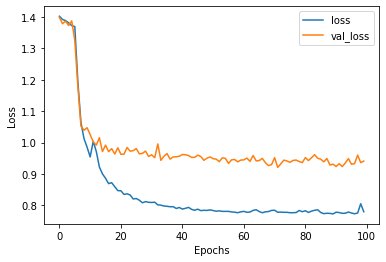

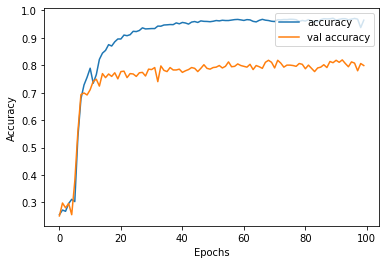

In [18]:
plot_learning_curve(history)

In [19]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [31]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=16)

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 1.3326 - accuracy: 0.37 - ETA: 9s - loss: 1.4014 - accuracy: 0.28 - ETA: 13s - loss: 1.3979 - accuracy: 0.291 - ETA: 14s - loss: 1.3970 - accuracy: 0.265 - ETA: 15s - loss: 1.3868 - accuracy: 0.287 - ETA: 15s - loss: 1.3948 - accuracy: 0.270 - ETA: 16s - loss: 1.3929 - accuracy: 0.285 - ETA: 16s - loss: 1.3851 - accuracy: 0.296 - ETA: 16s - loss: 1.3870 - accuracy: 0.284 - ETA: 16s - loss: 1.3852 - accuracy: 0.287 - ETA: 16s - loss: 1.3903 - accuracy: 0.284 - ETA: 16s - loss: 1.3923 - accuracy: 0.281 - ETA: 16s - loss: 1.3980 - accuracy: 0.274 - ETA: 16s - loss: 1.3973 - accuracy: 0.276 - ETA: 16s - loss: 1.3987 - accuracy: 0.270 - ETA: 16s - loss: 1.3986 - accuracy: 0.265 - ETA: 16s - loss: 1.3973 - accuracy: 0.264 - ETA: 16s - loss: 1.3939 - accuracy: 0.267 - ETA: 16s - loss: 1.3954 - accuracy: 0.269 - ETA: 16s - loss: 1.3958 - accuracy: 0.265 - ETA: 16s - loss: 1.3958 - accuracy: 0.261 - ETA: 16s - loss: 1.3991 -

Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.25 - ETA: 9s - loss: 1.3919 - accuracy: 0.31 - ETA: 12s - loss: 1.4070 - accuracy: 0.270 - ETA: 13s - loss: 1.4038 - accuracy: 0.234 - ETA: 14s - loss: 1.4105 - accuracy: 0.212 - ETA: 15s - loss: 1.4069 - accuracy: 0.197 - ETA: 15s - loss: 1.4099 - accuracy: 0.187 - ETA: 15s - loss: 1.4080 - accuracy: 0.179 - ETA: 15s - loss: 1.4088 - accuracy: 0.187 - ETA: 15s - loss: 1.4095 - accuracy: 0.206 - ETA: 16s - loss: 1.4126 - accuracy: 0.198 - ETA: 16s - loss: 1.4117 - accuracy: 0.203 - ETA: 16s - loss: 1.4102 - accuracy: 0.206 - ETA: 16s - loss: 1.4116 - accuracy: 0.196 - ETA: 16s - loss: 1.4073 - accuracy: 0.204 - ETA: 16s - loss: 1.4080 - accuracy: 0.195 - ETA: 16s - loss: 1.4074 - accuracy: 0.198 - ETA: 16s - loss: 1.4049 - accuracy: 0.201 - ETA: 16s - loss: 1.4058 - accuracy: 0.200 - ETA: 16s - loss: 1.4063 - accuracy: 0.196 - ETA: 16s - loss: 1.4048 - accuracy: 0.196 - ETA: 16s - loss: 1.4049 -

Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 1.3903 - accuracy: 0.31 - ETA: 17s - loss: 1.3940 - accuracy: 0.281 - ETA: 20s - loss: 1.3964 - accuracy: 0.291 - ETA: 19s - loss: 1.3925 - accuracy: 0.265 - ETA: 19s - loss: 1.3968 - accuracy: 0.237 - ETA: 19s - loss: 1.3962 - accuracy: 0.250 - ETA: 18s - loss: 1.3940 - accuracy: 0.250 - ETA: 18s - loss: 1.3966 - accuracy: 0.250 - ETA: 18s - loss: 1.3915 - accuracy: 0.256 - ETA: 18s - loss: 1.3900 - accuracy: 0.256 - ETA: 18s - loss: 1.3855 - accuracy: 0.272 - ETA: 18s - loss: 1.3879 - accuracy: 0.265 - ETA: 18s - loss: 1.3880 - accuracy: 0.264 - ETA: 17s - loss: 1.3885 - accuracy: 0.267 - ETA: 17s - loss: 1.3920 - accuracy: 0.266 - ETA: 17s - loss: 1.3914 - accuracy: 0.273 - ETA: 17s - loss: 1.3936 - accuracy: 0.264 - ETA: 17s - loss: 1.3960 - accuracy: 0.250 - ETA: 17s - loss: 1.3971 - accuracy: 0.240 - ETA: 17s - loss: 1.3969 - accuracy: 0.243 - ETA: 17s - loss: 1.3960 - accuracy: 0.250 - ETA: 16s - loss: 1.3974

Epoch 4/100
188/188 [==============================] - ETA: 0s - loss: 1.4324 - accuracy: 0.25 - ETA: 9s - loss: 1.4213 - accuracy: 0.25 - ETA: 12s - loss: 1.3866 - accuracy: 0.291 - ETA: 13s - loss: 1.3998 - accuracy: 0.296 - ETA: 14s - loss: 1.3847 - accuracy: 0.300 - ETA: 15s - loss: 1.3817 - accuracy: 0.270 - ETA: 15s - loss: 1.3904 - accuracy: 0.250 - ETA: 15s - loss: 1.3881 - accuracy: 0.273 - ETA: 15s - loss: 1.3855 - accuracy: 0.277 - ETA: 16s - loss: 1.3855 - accuracy: 0.281 - ETA: 16s - loss: 1.3841 - accuracy: 0.267 - ETA: 16s - loss: 1.3855 - accuracy: 0.265 - ETA: 16s - loss: 1.3868 - accuracy: 0.259 - ETA: 16s - loss: 1.3863 - accuracy: 0.254 - ETA: 16s - loss: 1.3872 - accuracy: 0.258 - ETA: 16s - loss: 1.3856 - accuracy: 0.257 - ETA: 16s - loss: 1.3851 - accuracy: 0.264 - ETA: 16s - loss: 1.3858 - accuracy: 0.263 - ETA: 16s - loss: 1.3866 - accuracy: 0.266 - ETA: 16s - loss: 1.3850 - accuracy: 0.271 - ETA: 16s - loss: 1.3853 - accuracy: 0.267 - ETA: 15s - loss: 1.3859 -

Epoch 5/100
188/188 [==============================] - ETA: 0s - loss: 1.3714 - accuracy: 0.25 - ETA: 9s - loss: 1.4070 - accuracy: 0.21 - ETA: 12s - loss: 1.4135 - accuracy: 0.187 - ETA: 13s - loss: 1.4080 - accuracy: 0.203 - ETA: 14s - loss: 1.4049 - accuracy: 0.212 - ETA: 15s - loss: 1.4137 - accuracy: 0.197 - ETA: 15s - loss: 1.4153 - accuracy: 0.187 - ETA: 15s - loss: 1.4096 - accuracy: 0.179 - ETA: 15s - loss: 1.4079 - accuracy: 0.201 - ETA: 15s - loss: 1.4042 - accuracy: 0.212 - ETA: 16s - loss: 1.4046 - accuracy: 0.210 - ETA: 16s - loss: 1.4021 - accuracy: 0.224 - ETA: 16s - loss: 1.4036 - accuracy: 0.221 - ETA: 16s - loss: 1.4018 - accuracy: 0.209 - ETA: 16s - loss: 1.4017 - accuracy: 0.208 - ETA: 15s - loss: 1.4012 - accuracy: 0.207 - ETA: 15s - loss: 1.4005 - accuracy: 0.213 - ETA: 15s - loss: 1.4020 - accuracy: 0.215 - ETA: 15s - loss: 1.4038 - accuracy: 0.207 - ETA: 15s - loss: 1.4021 - accuracy: 0.206 - ETA: 15s - loss: 1.4025 - accuracy: 0.205 - ETA: 15s - loss: 1.4018 -

Epoch 6/100
188/188 [==============================] - ETA: 0s - loss: 1.3958 - accuracy: 0.31 - ETA: 9s - loss: 1.4000 - accuracy: 0.28 - ETA: 12s - loss: 1.3875 - accuracy: 0.270 - ETA: 13s - loss: 1.3873 - accuracy: 0.281 - ETA: 14s - loss: 1.3862 - accuracy: 0.287 - ETA: 15s - loss: 1.3856 - accuracy: 0.281 - ETA: 15s - loss: 1.3855 - accuracy: 0.276 - ETA: 15s - loss: 1.3857 - accuracy: 0.289 - ETA: 18s - loss: 1.3894 - accuracy: 0.277 - ETA: 18s - loss: 1.3890 - accuracy: 0.281 - ETA: 18s - loss: 1.3915 - accuracy: 0.267 - ETA: 18s - loss: 1.3899 - accuracy: 0.270 - ETA: 18s - loss: 1.3897 - accuracy: 0.264 - ETA: 18s - loss: 1.3875 - accuracy: 0.272 - ETA: 18s - loss: 1.3855 - accuracy: 0.283 - ETA: 18s - loss: 1.3858 - accuracy: 0.277 - ETA: 17s - loss: 1.3873 - accuracy: 0.279 - ETA: 17s - loss: 1.3862 - accuracy: 0.277 - ETA: 17s - loss: 1.3843 - accuracy: 0.276 - ETA: 17s - loss: 1.3855 - accuracy: 0.271 - ETA: 17s - loss: 1.3842 - accuracy: 0.276 - ETA: 17s - loss: 1.3854 -

Epoch 7/100
188/188 [==============================] - ETA: 0s - loss: 1.3735 - accuracy: 0.37 - ETA: 9s - loss: 1.3719 - accuracy: 0.31 - ETA: 12s - loss: 1.3850 - accuracy: 0.291 - ETA: 13s - loss: 1.3926 - accuracy: 0.265 - ETA: 14s - loss: 1.3896 - accuracy: 0.262 - ETA: 15s - loss: 1.3905 - accuracy: 0.239 - ETA: 15s - loss: 1.3858 - accuracy: 0.241 - ETA: 15s - loss: 1.3844 - accuracy: 0.234 - ETA: 15s - loss: 1.3799 - accuracy: 0.250 - ETA: 15s - loss: 1.3829 - accuracy: 0.243 - ETA: 15s - loss: 1.3839 - accuracy: 0.238 - ETA: 15s - loss: 1.3845 - accuracy: 0.229 - ETA: 15s - loss: 1.3835 - accuracy: 0.240 - ETA: 15s - loss: 1.3834 - accuracy: 0.245 - ETA: 15s - loss: 1.3828 - accuracy: 0.245 - ETA: 15s - loss: 1.3835 - accuracy: 0.250 - ETA: 15s - loss: 1.3838 - accuracy: 0.246 - ETA: 15s - loss: 1.3841 - accuracy: 0.239 - ETA: 15s - loss: 1.3848 - accuracy: 0.233 - ETA: 15s - loss: 1.3859 - accuracy: 0.234 - ETA: 15s - loss: 1.3849 - accuracy: 0.247 - ETA: 15s - loss: 1.3855 -

Epoch 8/100
188/188 [==============================] - ETA: 0s - loss: 1.3686 - accuracy: 0.50 - ETA: 9s - loss: 1.3804 - accuracy: 0.37 - ETA: 12s - loss: 1.3921 - accuracy: 0.312 - ETA: 13s - loss: 1.3850 - accuracy: 0.312 - ETA: 14s - loss: 1.3866 - accuracy: 0.275 - ETA: 15s - loss: 1.3812 - accuracy: 0.270 - ETA: 15s - loss: 1.3824 - accuracy: 0.258 - ETA: 15s - loss: 1.3834 - accuracy: 0.250 - ETA: 15s - loss: 1.3863 - accuracy: 0.250 - ETA: 15s - loss: 1.3901 - accuracy: 0.237 - ETA: 16s - loss: 1.3936 - accuracy: 0.233 - ETA: 16s - loss: 1.3947 - accuracy: 0.224 - ETA: 16s - loss: 1.3989 - accuracy: 0.211 - ETA: 16s - loss: 1.3979 - accuracy: 0.209 - ETA: 16s - loss: 1.3974 - accuracy: 0.204 - ETA: 16s - loss: 1.4000 - accuracy: 0.191 - ETA: 16s - loss: 1.3978 - accuracy: 0.202 - ETA: 16s - loss: 1.3967 - accuracy: 0.211 - ETA: 15s - loss: 1.3961 - accuracy: 0.207 - ETA: 15s - loss: 1.3948 - accuracy: 0.215 - ETA: 15s - loss: 1.3938 - accuracy: 0.220 - ETA: 15s - loss: 1.3945 -

Epoch 9/100
188/188 [==============================] - ETA: 0s - loss: 1.4383 - accuracy: 0.18 - ETA: 9s - loss: 1.4080 - accuracy: 0.25 - ETA: 12s - loss: 1.4055 - accuracy: 0.250 - ETA: 13s - loss: 1.3995 - accuracy: 0.265 - ETA: 14s - loss: 1.3923 - accuracy: 0.287 - ETA: 15s - loss: 1.3928 - accuracy: 0.270 - ETA: 15s - loss: 1.3998 - accuracy: 0.267 - ETA: 15s - loss: 1.3973 - accuracy: 0.281 - ETA: 15s - loss: 1.3964 - accuracy: 0.291 - ETA: 15s - loss: 1.3937 - accuracy: 0.300 - ETA: 16s - loss: 1.3942 - accuracy: 0.278 - ETA: 16s - loss: 1.3939 - accuracy: 0.281 - ETA: 17s - loss: 1.3929 - accuracy: 0.269 - ETA: 17s - loss: 1.3928 - accuracy: 0.258 - ETA: 17s - loss: 1.3922 - accuracy: 0.266 - ETA: 17s - loss: 1.3908 - accuracy: 0.269 - ETA: 17s - loss: 1.3907 - accuracy: 0.268 - ETA: 17s - loss: 1.3916 - accuracy: 0.256 - ETA: 17s - loss: 1.3917 - accuracy: 0.256 - ETA: 17s - loss: 1.3930 - accuracy: 0.250 - ETA: 17s - loss: 1.3936 - accuracy: 0.244 - ETA: 16s - loss: 1.3929 -

Epoch 10/100
188/188 [==============================] - ETA: 0s - loss: 1.3916 - accuracy: 0.12 - ETA: 9s - loss: 1.3998 - accuracy: 0.15 - ETA: 12s - loss: 1.4014 - accuracy: 0.145 - ETA: 14s - loss: 1.4008 - accuracy: 0.218 - ETA: 14s - loss: 1.3937 - accuracy: 0.250 - ETA: 15s - loss: 1.3895 - accuracy: 0.281 - ETA: 15s - loss: 1.3914 - accuracy: 0.285 - ETA: 15s - loss: 1.3934 - accuracy: 0.273 - ETA: 16s - loss: 1.3917 - accuracy: 0.277 - ETA: 16s - loss: 1.3929 - accuracy: 0.256 - ETA: 16s - loss: 1.3930 - accuracy: 0.255 - ETA: 16s - loss: 1.3924 - accuracy: 0.250 - ETA: 16s - loss: 1.3917 - accuracy: 0.245 - ETA: 16s - loss: 1.3914 - accuracy: 0.245 - ETA: 16s - loss: 1.3914 - accuracy: 0.241 - ETA: 16s - loss: 1.3935 - accuracy: 0.238 - ETA: 16s - loss: 1.3920 - accuracy: 0.246 - ETA: 16s - loss: 1.3920 - accuracy: 0.246 - ETA: 16s - loss: 1.3920 - accuracy: 0.250 - ETA: 16s - loss: 1.3929 - accuracy: 0.243 - ETA: 16s - loss: 1.3924 - accuracy: 0.235 - ETA: 15s - loss: 1.3927 

Epoch 11/100
188/188 [==============================] - ETA: 0s - loss: 1.3749 - accuracy: 0.37 - ETA: 9s - loss: 1.3866 - accuracy: 0.28 - ETA: 12s - loss: 1.3948 - accuracy: 0.270 - ETA: 14s - loss: 1.3967 - accuracy: 0.250 - ETA: 15s - loss: 1.3960 - accuracy: 0.250 - ETA: 15s - loss: 1.3937 - accuracy: 0.250 - ETA: 16s - loss: 1.3932 - accuracy: 0.250 - ETA: 16s - loss: 1.3939 - accuracy: 0.218 - ETA: 16s - loss: 1.3927 - accuracy: 0.222 - ETA: 16s - loss: 1.3921 - accuracy: 0.237 - ETA: 16s - loss: 1.3920 - accuracy: 0.244 - ETA: 16s - loss: 1.3927 - accuracy: 0.234 - ETA: 16s - loss: 1.3926 - accuracy: 0.254 - ETA: 16s - loss: 1.3938 - accuracy: 0.250 - ETA: 16s - loss: 1.3937 - accuracy: 0.250 - ETA: 16s - loss: 1.3955 - accuracy: 0.246 - ETA: 16s - loss: 1.3943 - accuracy: 0.250 - ETA: 16s - loss: 1.3941 - accuracy: 0.246 - ETA: 16s - loss: 1.3943 - accuracy: 0.243 - ETA: 16s - loss: 1.3939 - accuracy: 0.250 - ETA: 16s - loss: 1.3935 - accuracy: 0.250 - ETA: 16s - loss: 1.3942 

Epoch 12/100
188/188 [==============================] - ETA: 0s - loss: 1.3688 - accuracy: 0.37 - ETA: 9s - loss: 1.3765 - accuracy: 0.37 - ETA: 12s - loss: 1.3860 - accuracy: 0.375 - ETA: 13s - loss: 1.3820 - accuracy: 0.359 - ETA: 14s - loss: 1.3784 - accuracy: 0.362 - ETA: 15s - loss: 1.3742 - accuracy: 0.364 - ETA: 15s - loss: 1.3804 - accuracy: 0.339 - ETA: 15s - loss: 1.3926 - accuracy: 0.312 - ETA: 15s - loss: 1.3887 - accuracy: 0.312 - ETA: 16s - loss: 1.3912 - accuracy: 0.300 - ETA: 16s - loss: 1.3912 - accuracy: 0.295 - ETA: 16s - loss: 1.3927 - accuracy: 0.291 - ETA: 16s - loss: 1.3932 - accuracy: 0.283 - ETA: 16s - loss: 1.3968 - accuracy: 0.267 - ETA: 16s - loss: 1.3909 - accuracy: 0.279 - ETA: 16s - loss: 1.3921 - accuracy: 0.269 - ETA: 16s - loss: 1.3905 - accuracy: 0.272 - ETA: 17s - loss: 1.3906 - accuracy: 0.274 - ETA: 17s - loss: 1.3905 - accuracy: 0.269 - ETA: 17s - loss: 1.3901 - accuracy: 0.275 - ETA: 17s - loss: 1.3921 - accuracy: 0.264 - ETA: 17s - loss: 1.3890 

Epoch 13/100
188/188 [==============================] - ETA: 0s - loss: 1.3322 - accuracy: 0.31 - ETA: 9s - loss: 1.3722 - accuracy: 0.28 - ETA: 12s - loss: 1.3785 - accuracy: 0.291 - ETA: 14s - loss: 1.3816 - accuracy: 0.281 - ETA: 15s - loss: 1.3799 - accuracy: 0.250 - ETA: 15s - loss: 1.3959 - accuracy: 0.229 - ETA: 15s - loss: 1.3933 - accuracy: 0.241 - ETA: 16s - loss: 1.3911 - accuracy: 0.257 - ETA: 16s - loss: 1.3863 - accuracy: 0.263 - ETA: 16s - loss: 1.3834 - accuracy: 0.262 - ETA: 16s - loss: 1.3849 - accuracy: 0.261 - ETA: 16s - loss: 1.3787 - accuracy: 0.281 - ETA: 16s - loss: 1.3884 - accuracy: 0.259 - ETA: 16s - loss: 1.3903 - accuracy: 0.258 - ETA: 16s - loss: 1.3907 - accuracy: 0.258 - ETA: 16s - loss: 1.3903 - accuracy: 0.265 - ETA: 16s - loss: 1.3900 - accuracy: 0.264 - ETA: 16s - loss: 1.3867 - accuracy: 0.267 - ETA: 16s - loss: 1.3851 - accuracy: 0.269 - ETA: 16s - loss: 1.3865 - accuracy: 0.271 - ETA: 16s - loss: 1.3852 - accuracy: 0.273 - ETA: 16s - loss: 1.3836 

Epoch 14/100
188/188 [==============================] - ETA: 0s - loss: 1.3867 - accuracy: 0.37 - ETA: 9s - loss: 1.3878 - accuracy: 0.34 - ETA: 12s - loss: 1.3935 - accuracy: 0.312 - ETA: 13s - loss: 1.3707 - accuracy: 0.359 - ETA: 14s - loss: 1.3656 - accuracy: 0.375 - ETA: 19s - loss: 1.3691 - accuracy: 0.364 - ETA: 20s - loss: 1.3627 - accuracy: 0.366 - ETA: 20s - loss: 1.3697 - accuracy: 0.343 - ETA: 19s - loss: 1.3702 - accuracy: 0.340 - ETA: 19s - loss: 1.3668 - accuracy: 0.350 - ETA: 19s - loss: 1.3714 - accuracy: 0.340 - ETA: 19s - loss: 1.3665 - accuracy: 0.343 - ETA: 18s - loss: 1.3749 - accuracy: 0.322 - ETA: 18s - loss: 1.3784 - accuracy: 0.312 - ETA: 18s - loss: 1.3817 - accuracy: 0.308 - ETA: 18s - loss: 1.3814 - accuracy: 0.312 - ETA: 18s - loss: 1.3830 - accuracy: 0.301 - ETA: 18s - loss: 1.3814 - accuracy: 0.309 - ETA: 17s - loss: 1.3821 - accuracy: 0.305 - ETA: 17s - loss: 1.3782 - accuracy: 0.312 - ETA: 17s - loss: 1.3787 - accuracy: 0.309 - ETA: 17s - loss: 1.3783 

Epoch 15/100
188/188 [==============================] - ETA: 0s - loss: 1.3369 - accuracy: 0.43 - ETA: 9s - loss: 1.3855 - accuracy: 0.31 - ETA: 12s - loss: 1.3968 - accuracy: 0.270 - ETA: 13s - loss: 1.4013 - accuracy: 0.250 - ETA: 14s - loss: 1.3963 - accuracy: 0.262 - ETA: 15s - loss: 1.3786 - accuracy: 0.291 - ETA: 15s - loss: 1.3817 - accuracy: 0.285 - ETA: 16s - loss: 1.3863 - accuracy: 0.257 - ETA: 16s - loss: 1.3762 - accuracy: 0.298 - ETA: 16s - loss: 1.3640 - accuracy: 0.331 - ETA: 16s - loss: 1.3542 - accuracy: 0.340 - ETA: 16s - loss: 1.3625 - accuracy: 0.322 - ETA: 16s - loss: 1.3645 - accuracy: 0.322 - ETA: 16s - loss: 1.3668 - accuracy: 0.317 - ETA: 16s - loss: 1.3731 - accuracy: 0.316 - ETA: 16s - loss: 1.3775 - accuracy: 0.304 - ETA: 16s - loss: 1.3745 - accuracy: 0.305 - ETA: 16s - loss: 1.3734 - accuracy: 0.305 - ETA: 16s - loss: 1.3720 - accuracy: 0.309 - ETA: 17s - loss: 1.3705 - accuracy: 0.309 - ETA: 17s - loss: 1.3717 - accuracy: 0.309 - ETA: 17s - loss: 1.3736 

Epoch 16/100
188/188 [==============================] - ETA: 0s - loss: 1.4325 - accuracy: 0.18 - ETA: 9s - loss: 1.3641 - accuracy: 0.37 - ETA: 12s - loss: 1.3718 - accuracy: 0.312 - ETA: 13s - loss: 1.3503 - accuracy: 0.359 - ETA: 14s - loss: 1.3719 - accuracy: 0.300 - ETA: 14s - loss: 1.3706 - accuracy: 0.281 - ETA: 15s - loss: 1.3754 - accuracy: 0.294 - ETA: 15s - loss: 1.3736 - accuracy: 0.289 - ETA: 15s - loss: 1.3678 - accuracy: 0.305 - ETA: 15s - loss: 1.3642 - accuracy: 0.300 - ETA: 15s - loss: 1.3675 - accuracy: 0.301 - ETA: 15s - loss: 1.3700 - accuracy: 0.291 - ETA: 15s - loss: 1.3658 - accuracy: 0.298 - ETA: 15s - loss: 1.3747 - accuracy: 0.285 - ETA: 15s - loss: 1.3759 - accuracy: 0.287 - ETA: 15s - loss: 1.3758 - accuracy: 0.285 - ETA: 15s - loss: 1.3764 - accuracy: 0.286 - ETA: 15s - loss: 1.3777 - accuracy: 0.288 - ETA: 15s - loss: 1.3770 - accuracy: 0.279 - ETA: 15s - loss: 1.3798 - accuracy: 0.271 - ETA: 15s - loss: 1.3795 - accuracy: 0.270 - ETA: 15s - loss: 1.3836 

Epoch 17/100
188/188 [==============================] - ETA: 0s - loss: 1.4267 - accuracy: 0.25 - ETA: 9s - loss: 1.4125 - accuracy: 0.28 - ETA: 12s - loss: 1.3950 - accuracy: 0.291 - ETA: 14s - loss: 1.3966 - accuracy: 0.281 - ETA: 14s - loss: 1.4073 - accuracy: 0.250 - ETA: 15s - loss: 1.4069 - accuracy: 0.239 - ETA: 15s - loss: 1.4095 - accuracy: 0.232 - ETA: 16s - loss: 1.4069 - accuracy: 0.234 - ETA: 16s - loss: 1.4081 - accuracy: 0.243 - ETA: 16s - loss: 1.4020 - accuracy: 0.256 - ETA: 16s - loss: 1.4071 - accuracy: 0.250 - ETA: 16s - loss: 1.4109 - accuracy: 0.244 - ETA: 16s - loss: 1.4041 - accuracy: 0.259 - ETA: 16s - loss: 1.4006 - accuracy: 0.258 - ETA: 16s - loss: 1.3993 - accuracy: 0.262 - ETA: 16s - loss: 1.4000 - accuracy: 0.257 - ETA: 16s - loss: 1.4002 - accuracy: 0.253 - ETA: 16s - loss: 1.3941 - accuracy: 0.267 - ETA: 16s - loss: 1.3926 - accuracy: 0.269 - ETA: 16s - loss: 1.3883 - accuracy: 0.275 - ETA: 16s - loss: 1.3848 - accuracy: 0.279 - ETA: 16s - loss: 1.3874 

Epoch 18/100
188/188 [==============================] - ETA: 0s - loss: 1.3517 - accuracy: 0.43 - ETA: 9s - loss: 1.3694 - accuracy: 0.31 - ETA: 12s - loss: 1.3582 - accuracy: 0.312 - ETA: 13s - loss: 1.3650 - accuracy: 0.312 - ETA: 14s - loss: 1.3664 - accuracy: 0.287 - ETA: 15s - loss: 1.3574 - accuracy: 0.291 - ETA: 15s - loss: 1.3583 - accuracy: 0.312 - ETA: 15s - loss: 1.3587 - accuracy: 0.304 - ETA: 15s - loss: 1.3530 - accuracy: 0.333 - ETA: 16s - loss: 1.3531 - accuracy: 0.343 - ETA: 16s - loss: 1.3620 - accuracy: 0.335 - ETA: 16s - loss: 1.3600 - accuracy: 0.338 - ETA: 16s - loss: 1.3633 - accuracy: 0.341 - ETA: 16s - loss: 1.3659 - accuracy: 0.334 - ETA: 16s - loss: 1.3633 - accuracy: 0.333 - ETA: 16s - loss: 1.3664 - accuracy: 0.328 - ETA: 17s - loss: 1.3630 - accuracy: 0.341 - ETA: 17s - loss: 1.3650 - accuracy: 0.336 - ETA: 17s - loss: 1.3641 - accuracy: 0.335 - ETA: 17s - loss: 1.3610 - accuracy: 0.340 - ETA: 16s - loss: 1.3617 - accuracy: 0.336 - ETA: 16s - loss: 1.3620 

Epoch 19/100
188/188 [==============================] - ETA: 0s - loss: 1.3551 - accuracy: 0.31 - ETA: 9s - loss: 1.3851 - accuracy: 0.25 - ETA: 11s - loss: 1.3778 - accuracy: 0.250 - ETA: 13s - loss: 1.3979 - accuracy: 0.187 - ETA: 14s - loss: 1.3732 - accuracy: 0.262 - ETA: 14s - loss: 1.3783 - accuracy: 0.260 - ETA: 15s - loss: 1.3716 - accuracy: 0.303 - ETA: 15s - loss: 1.3688 - accuracy: 0.296 - ETA: 15s - loss: 1.3721 - accuracy: 0.284 - ETA: 15s - loss: 1.3746 - accuracy: 0.281 - ETA: 15s - loss: 1.3674 - accuracy: 0.289 - ETA: 15s - loss: 1.3611 - accuracy: 0.302 - ETA: 15s - loss: 1.3590 - accuracy: 0.307 - ETA: 15s - loss: 1.3589 - accuracy: 0.317 - ETA: 15s - loss: 1.3641 - accuracy: 0.308 - ETA: 15s - loss: 1.3659 - accuracy: 0.304 - ETA: 15s - loss: 1.3714 - accuracy: 0.297 - ETA: 15s - loss: 1.3698 - accuracy: 0.302 - ETA: 15s - loss: 1.3732 - accuracy: 0.292 - ETA: 15s - loss: 1.3692 - accuracy: 0.303 - ETA: 15s - loss: 1.3707 - accuracy: 0.306 - ETA: 15s - loss: 1.3753 

Epoch 20/100
188/188 [==============================] - ETA: 0s - loss: 1.3692 - accuracy: 0.18 - ETA: 9s - loss: 1.3523 - accuracy: 0.28 - ETA: 12s - loss: 1.3728 - accuracy: 0.250 - ETA: 13s - loss: 1.3634 - accuracy: 0.234 - ETA: 14s - loss: 1.3444 - accuracy: 0.262 - ETA: 15s - loss: 1.3291 - accuracy: 0.302 - ETA: 15s - loss: 1.3308 - accuracy: 0.303 - ETA: 15s - loss: 1.3281 - accuracy: 0.296 - ETA: 15s - loss: 1.3236 - accuracy: 0.319 - ETA: 16s - loss: 1.3306 - accuracy: 0.306 - ETA: 16s - loss: 1.3307 - accuracy: 0.329 - ETA: 16s - loss: 1.3248 - accuracy: 0.343 - ETA: 16s - loss: 1.3234 - accuracy: 0.355 - ETA: 16s - loss: 1.3232 - accuracy: 0.361 - ETA: 16s - loss: 1.3271 - accuracy: 0.358 - ETA: 16s - loss: 1.3230 - accuracy: 0.367 - ETA: 16s - loss: 1.3289 - accuracy: 0.360 - ETA: 16s - loss: 1.3276 - accuracy: 0.364 - ETA: 16s - loss: 1.3243 - accuracy: 0.365 - ETA: 16s - loss: 1.3272 - accuracy: 0.359 - ETA: 15s - loss: 1.3291 - accuracy: 0.351 - ETA: 15s - loss: 1.3348 

Epoch 21/100
188/188 [==============================] - ETA: 0s - loss: 1.4806 - accuracy: 0.25 - ETA: 9s - loss: 1.3934 - accuracy: 0.34 - ETA: 12s - loss: 1.3825 - accuracy: 0.312 - ETA: 13s - loss: 1.3649 - accuracy: 0.328 - ETA: 14s - loss: 1.3405 - accuracy: 0.362 - ETA: 15s - loss: 1.3335 - accuracy: 0.364 - ETA: 15s - loss: 1.3336 - accuracy: 0.348 - ETA: 15s - loss: 1.3171 - accuracy: 0.375 - ETA: 15s - loss: 1.3283 - accuracy: 0.361 - ETA: 15s - loss: 1.3289 - accuracy: 0.375 - ETA: 16s - loss: 1.3304 - accuracy: 0.380 - ETA: 16s - loss: 1.3341 - accuracy: 0.369 - ETA: 16s - loss: 1.3321 - accuracy: 0.370 - ETA: 16s - loss: 1.3339 - accuracy: 0.361 - ETA: 16s - loss: 1.3346 - accuracy: 0.366 - ETA: 16s - loss: 1.3356 - accuracy: 0.363 - ETA: 16s - loss: 1.3359 - accuracy: 0.356 - ETA: 16s - loss: 1.3278 - accuracy: 0.368 - ETA: 16s - loss: 1.3285 - accuracy: 0.371 - ETA: 15s - loss: 1.3312 - accuracy: 0.362 - ETA: 15s - loss: 1.3277 - accuracy: 0.360 - ETA: 15s - loss: 1.3207 

Epoch 22/100
188/188 [==============================] - ETA: 0s - loss: 1.1840 - accuracy: 0.56 - ETA: 9s - loss: 1.1876 - accuracy: 0.50 - ETA: 15s - loss: 1.1852 - accuracy: 0.458 - ETA: 18s - loss: 1.1988 - accuracy: 0.453 - ETA: 18s - loss: 1.2370 - accuracy: 0.425 - ETA: 18s - loss: 1.2520 - accuracy: 0.427 - ETA: 18s - loss: 1.2572 - accuracy: 0.410 - ETA: 18s - loss: 1.2533 - accuracy: 0.421 - ETA: 18s - loss: 1.2507 - accuracy: 0.423 - ETA: 18s - loss: 1.2524 - accuracy: 0.431 - ETA: 18s - loss: 1.2574 - accuracy: 0.431 - ETA: 18s - loss: 1.2621 - accuracy: 0.421 - ETA: 17s - loss: 1.2669 - accuracy: 0.427 - ETA: 17s - loss: 1.2910 - accuracy: 0.397 - ETA: 17s - loss: 1.3054 - accuracy: 0.387 - ETA: 17s - loss: 1.3004 - accuracy: 0.394 - ETA: 17s - loss: 1.2982 - accuracy: 0.400 - ETA: 17s - loss: 1.3081 - accuracy: 0.381 - ETA: 17s - loss: 1.3069 - accuracy: 0.378 - ETA: 17s - loss: 1.3053 - accuracy: 0.381 - ETA: 17s - loss: 1.2996 - accuracy: 0.389 - ETA: 17s - loss: 1.2994 

Epoch 23/100
188/188 [==============================] - ETA: 0s - loss: 1.3560 - accuracy: 0.31 - ETA: 8s - loss: 1.2191 - accuracy: 0.50 - ETA: 12s - loss: 1.2371 - accuracy: 0.458 - ETA: 13s - loss: 1.2244 - accuracy: 0.484 - ETA: 14s - loss: 1.2025 - accuracy: 0.512 - ETA: 14s - loss: 1.2005 - accuracy: 0.520 - ETA: 15s - loss: 1.1848 - accuracy: 0.535 - ETA: 15s - loss: 1.1733 - accuracy: 0.554 - ETA: 15s - loss: 1.1859 - accuracy: 0.534 - ETA: 15s - loss: 1.1829 - accuracy: 0.543 - ETA: 15s - loss: 1.1887 - accuracy: 0.539 - ETA: 16s - loss: 1.1849 - accuracy: 0.541 - ETA: 16s - loss: 1.1828 - accuracy: 0.543 - ETA: 16s - loss: 1.1780 - accuracy: 0.553 - ETA: 17s - loss: 1.1683 - accuracy: 0.562 - ETA: 17s - loss: 1.1659 - accuracy: 0.566 - ETA: 17s - loss: 1.1697 - accuracy: 0.562 - ETA: 17s - loss: 1.1662 - accuracy: 0.566 - ETA: 17s - loss: 1.1651 - accuracy: 0.565 - ETA: 17s - loss: 1.1683 - accuracy: 0.562 - ETA: 17s - loss: 1.1654 - accuracy: 0.565 - ETA: 17s - loss: 1.1671 

Epoch 24/100
188/188 [==============================] - ETA: 0s - loss: 1.2103 - accuracy: 0.56 - ETA: 9s - loss: 1.2628 - accuracy: 0.50 - ETA: 12s - loss: 1.2612 - accuracy: 0.458 - ETA: 13s - loss: 1.2596 - accuracy: 0.468 - ETA: 14s - loss: 1.2550 - accuracy: 0.475 - ETA: 15s - loss: 1.2239 - accuracy: 0.510 - ETA: 15s - loss: 1.2374 - accuracy: 0.482 - ETA: 15s - loss: 1.2308 - accuracy: 0.492 - ETA: 15s - loss: 1.2329 - accuracy: 0.479 - ETA: 15s - loss: 1.2252 - accuracy: 0.487 - ETA: 15s - loss: 1.2222 - accuracy: 0.494 - ETA: 16s - loss: 1.1970 - accuracy: 0.526 - ETA: 16s - loss: 1.1882 - accuracy: 0.538 - ETA: 16s - loss: 1.1898 - accuracy: 0.540 - ETA: 16s - loss: 1.1910 - accuracy: 0.537 - ETA: 16s - loss: 1.1872 - accuracy: 0.539 - ETA: 16s - loss: 1.1947 - accuracy: 0.529 - ETA: 15s - loss: 1.1869 - accuracy: 0.538 - ETA: 15s - loss: 1.1891 - accuracy: 0.536 - ETA: 15s - loss: 1.1896 - accuracy: 0.534 - ETA: 15s - loss: 1.1863 - accuracy: 0.538 - ETA: 15s - loss: 1.1862 

Epoch 25/100
188/188 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.62 - ETA: 9s - loss: 1.1708 - accuracy: 0.56 - ETA: 12s - loss: 1.0886 - accuracy: 0.645 - ETA: 13s - loss: 1.1110 - accuracy: 0.625 - ETA: 14s - loss: 1.0988 - accuracy: 0.637 - ETA: 15s - loss: 1.1207 - accuracy: 0.614 - ETA: 15s - loss: 1.1201 - accuracy: 0.607 - ETA: 15s - loss: 1.1356 - accuracy: 0.593 - ETA: 15s - loss: 1.1280 - accuracy: 0.604 - ETA: 16s - loss: 1.1194 - accuracy: 0.612 - ETA: 16s - loss: 1.1384 - accuracy: 0.590 - ETA: 16s - loss: 1.1473 - accuracy: 0.578 - ETA: 16s - loss: 1.1358 - accuracy: 0.591 - ETA: 16s - loss: 1.1358 - accuracy: 0.598 - ETA: 16s - loss: 1.1251 - accuracy: 0.608 - ETA: 16s - loss: 1.1256 - accuracy: 0.609 - ETA: 16s - loss: 1.1317 - accuracy: 0.602 - ETA: 15s - loss: 1.1271 - accuracy: 0.607 - ETA: 15s - loss: 1.1231 - accuracy: 0.615 - ETA: 15s - loss: 1.1186 - accuracy: 0.621 - ETA: 15s - loss: 1.1236 - accuracy: 0.616 - ETA: 15s - loss: 1.1257 

Epoch 26/100
188/188 [==============================] - ETA: 0s - loss: 1.0693 - accuracy: 0.62 - ETA: 9s - loss: 1.1091 - accuracy: 0.62 - ETA: 12s - loss: 1.1137 - accuracy: 0.625 - ETA: 14s - loss: 1.0977 - accuracy: 0.656 - ETA: 15s - loss: 1.0962 - accuracy: 0.650 - ETA: 15s - loss: 1.1211 - accuracy: 0.625 - ETA: 16s - loss: 1.1236 - accuracy: 0.633 - ETA: 16s - loss: 1.1363 - accuracy: 0.617 - ETA: 16s - loss: 1.1634 - accuracy: 0.590 - ETA: 16s - loss: 1.1411 - accuracy: 0.612 - ETA: 16s - loss: 1.1361 - accuracy: 0.613 - ETA: 16s - loss: 1.1203 - accuracy: 0.630 - ETA: 16s - loss: 1.1189 - accuracy: 0.629 - ETA: 16s - loss: 1.1207 - accuracy: 0.629 - ETA: 16s - loss: 1.1240 - accuracy: 0.625 - ETA: 16s - loss: 1.1194 - accuracy: 0.625 - ETA: 16s - loss: 1.1272 - accuracy: 0.614 - ETA: 16s - loss: 1.1279 - accuracy: 0.611 - ETA: 16s - loss: 1.1325 - accuracy: 0.605 - ETA: 16s - loss: 1.1277 - accuracy: 0.609 - ETA: 16s - loss: 1.1232 - accuracy: 0.610 - ETA: 16s - loss: 1.1197 

Epoch 27/100
188/188 [==============================] - ETA: 0s - loss: 1.0846 - accuracy: 0.68 - ETA: 9s - loss: 1.0996 - accuracy: 0.65 - ETA: 12s - loss: 1.0830 - accuracy: 0.666 - ETA: 13s - loss: 1.0964 - accuracy: 0.656 - ETA: 14s - loss: 1.0689 - accuracy: 0.687 - ETA: 15s - loss: 1.1228 - accuracy: 0.625 - ETA: 15s - loss: 1.1580 - accuracy: 0.580 - ETA: 15s - loss: 1.1413 - accuracy: 0.601 - ETA: 15s - loss: 1.1180 - accuracy: 0.625 - ETA: 16s - loss: 1.1108 - accuracy: 0.631 - ETA: 16s - loss: 1.1112 - accuracy: 0.630 - ETA: 16s - loss: 1.0970 - accuracy: 0.645 - ETA: 16s - loss: 1.1067 - accuracy: 0.634 - ETA: 16s - loss: 1.1136 - accuracy: 0.625 - ETA: 16s - loss: 1.1102 - accuracy: 0.629 - ETA: 16s - loss: 1.1099 - accuracy: 0.628 - ETA: 16s - loss: 1.1038 - accuracy: 0.636 - ETA: 16s - loss: 1.1116 - accuracy: 0.625 - ETA: 16s - loss: 1.1125 - accuracy: 0.625 - ETA: 15s - loss: 1.1227 - accuracy: 0.615 - ETA: 15s - loss: 1.1204 - accuracy: 0.616 - ETA: 15s - loss: 1.1148 

Epoch 28/100
188/188 [==============================] - ETA: 0s - loss: 1.0471 - accuracy: 0.75 - ETA: 9s - loss: 1.1471 - accuracy: 0.62 - ETA: 12s - loss: 1.2075 - accuracy: 0.520 - ETA: 13s - loss: 1.1993 - accuracy: 0.531 - ETA: 14s - loss: 1.1545 - accuracy: 0.575 - ETA: 14s - loss: 1.1199 - accuracy: 0.614 - ETA: 15s - loss: 1.1043 - accuracy: 0.633 - ETA: 15s - loss: 1.1197 - accuracy: 0.617 - ETA: 15s - loss: 1.0979 - accuracy: 0.638 - ETA: 15s - loss: 1.1186 - accuracy: 0.618 - ETA: 15s - loss: 1.0959 - accuracy: 0.642 - ETA: 15s - loss: 1.0848 - accuracy: 0.651 - ETA: 15s - loss: 1.0731 - accuracy: 0.663 - ETA: 15s - loss: 1.0719 - accuracy: 0.665 - ETA: 15s - loss: 1.0790 - accuracy: 0.658 - ETA: 15s - loss: 1.0749 - accuracy: 0.660 - ETA: 15s - loss: 1.0925 - accuracy: 0.639 - ETA: 15s - loss: 1.0904 - accuracy: 0.642 - ETA: 15s - loss: 1.1016 - accuracy: 0.631 - ETA: 15s - loss: 1.1007 - accuracy: 0.631 - ETA: 15s - loss: 1.0999 - accuracy: 0.633 - ETA: 15s - loss: 1.0971 

Epoch 29/100
188/188 [==============================] - ETA: 0s - loss: 0.9788 - accuracy: 0.81 - ETA: 9s - loss: 1.0441 - accuracy: 0.71 - ETA: 12s - loss: 1.0877 - accuracy: 0.666 - ETA: 13s - loss: 1.0655 - accuracy: 0.687 - ETA: 14s - loss: 1.0593 - accuracy: 0.675 - ETA: 15s - loss: 1.1039 - accuracy: 0.625 - ETA: 15s - loss: 1.0933 - accuracy: 0.633 - ETA: 15s - loss: 1.0905 - accuracy: 0.640 - ETA: 15s - loss: 1.0857 - accuracy: 0.645 - ETA: 16s - loss: 1.1068 - accuracy: 0.625 - ETA: 16s - loss: 1.0959 - accuracy: 0.636 - ETA: 16s - loss: 1.0951 - accuracy: 0.640 - ETA: 16s - loss: 1.1134 - accuracy: 0.620 - ETA: 16s - loss: 1.1179 - accuracy: 0.616 - ETA: 16s - loss: 1.1202 - accuracy: 0.616 - ETA: 16s - loss: 1.1326 - accuracy: 0.605 - ETA: 16s - loss: 1.1439 - accuracy: 0.591 - ETA: 16s - loss: 1.1403 - accuracy: 0.597 - ETA: 15s - loss: 1.1528 - accuracy: 0.585 - ETA: 15s - loss: 1.1664 - accuracy: 0.571 - ETA: 15s - loss: 1.1648 - accuracy: 0.574 - ETA: 15s - loss: 1.1617 

Epoch 30/100
188/188 [==============================] - ETA: 0s - loss: 0.9788 - accuracy: 0.75 - ETA: 9s - loss: 1.0235 - accuracy: 0.68 - ETA: 12s - loss: 1.0214 - accuracy: 0.708 - ETA: 13s - loss: 1.0545 - accuracy: 0.671 - ETA: 19s - loss: 1.0282 - accuracy: 0.700 - ETA: 20s - loss: 1.0171 - accuracy: 0.708 - ETA: 20s - loss: 0.9866 - accuracy: 0.741 - ETA: 19s - loss: 0.9981 - accuracy: 0.726 - ETA: 19s - loss: 1.0028 - accuracy: 0.722 - ETA: 19s - loss: 0.9842 - accuracy: 0.743 - ETA: 19s - loss: 0.9933 - accuracy: 0.733 - ETA: 19s - loss: 0.9982 - accuracy: 0.729 - ETA: 18s - loss: 1.0022 - accuracy: 0.726 - ETA: 18s - loss: 1.0018 - accuracy: 0.727 - ETA: 18s - loss: 1.0155 - accuracy: 0.716 - ETA: 18s - loss: 1.0250 - accuracy: 0.707 - ETA: 18s - loss: 1.0276 - accuracy: 0.705 - ETA: 17s - loss: 1.0414 - accuracy: 0.691 - ETA: 17s - loss: 1.0407 - accuracy: 0.690 - ETA: 17s - loss: 1.0466 - accuracy: 0.684 - ETA: 17s - loss: 1.0409 - accuracy: 0.690 - ETA: 17s - loss: 1.0418 

Epoch 31/100
188/188 [==============================] - ETA: 0s - loss: 0.9723 - accuracy: 0.75 - ETA: 9s - loss: 0.9248 - accuracy: 0.81 - ETA: 12s - loss: 0.9874 - accuracy: 0.750 - ETA: 13s - loss: 1.0649 - accuracy: 0.687 - ETA: 15s - loss: 1.0447 - accuracy: 0.712 - ETA: 15s - loss: 1.0362 - accuracy: 0.718 - ETA: 15s - loss: 1.0380 - accuracy: 0.714 - ETA: 15s - loss: 1.0408 - accuracy: 0.710 - ETA: 16s - loss: 1.0588 - accuracy: 0.687 - ETA: 16s - loss: 1.0668 - accuracy: 0.681 - ETA: 16s - loss: 1.0611 - accuracy: 0.687 - ETA: 16s - loss: 1.0787 - accuracy: 0.666 - ETA: 16s - loss: 1.0710 - accuracy: 0.673 - ETA: 16s - loss: 1.0699 - accuracy: 0.678 - ETA: 16s - loss: 1.0690 - accuracy: 0.679 - ETA: 16s - loss: 1.0684 - accuracy: 0.679 - ETA: 16s - loss: 1.0711 - accuracy: 0.676 - ETA: 17s - loss: 1.0625 - accuracy: 0.684 - ETA: 17s - loss: 1.0576 - accuracy: 0.687 - ETA: 17s - loss: 1.0607 - accuracy: 0.684 - ETA: 16s - loss: 1.0603 - accuracy: 0.684 - ETA: 16s - loss: 1.0569 

Epoch 32/100
188/188 [==============================] - ETA: 0s - loss: 1.1751 - accuracy: 0.56 - ETA: 9s - loss: 1.1072 - accuracy: 0.62 - ETA: 12s - loss: 1.1086 - accuracy: 0.625 - ETA: 13s - loss: 1.0910 - accuracy: 0.640 - ETA: 14s - loss: 1.0805 - accuracy: 0.650 - ETA: 15s - loss: 1.0592 - accuracy: 0.677 - ETA: 15s - loss: 1.0583 - accuracy: 0.678 - ETA: 16s - loss: 1.0509 - accuracy: 0.687 - ETA: 16s - loss: 1.0540 - accuracy: 0.687 - ETA: 16s - loss: 1.0471 - accuracy: 0.693 - ETA: 16s - loss: 1.0585 - accuracy: 0.687 - ETA: 16s - loss: 1.0597 - accuracy: 0.687 - ETA: 16s - loss: 1.0688 - accuracy: 0.677 - ETA: 16s - loss: 1.0676 - accuracy: 0.678 - ETA: 16s - loss: 1.0585 - accuracy: 0.687 - ETA: 16s - loss: 1.0691 - accuracy: 0.675 - ETA: 16s - loss: 1.0647 - accuracy: 0.680 - ETA: 16s - loss: 1.0792 - accuracy: 0.663 - ETA: 16s - loss: 1.0791 - accuracy: 0.664 - ETA: 16s - loss: 1.0704 - accuracy: 0.675 - ETA: 16s - loss: 1.0753 - accuracy: 0.669 - ETA: 16s - loss: 1.0752 

Epoch 33/100
188/188 [==============================] - ETA: 0s - loss: 0.9483 - accuracy: 0.81 - ETA: 9s - loss: 1.0070 - accuracy: 0.75 - ETA: 12s - loss: 1.0245 - accuracy: 0.729 - ETA: 13s - loss: 1.0037 - accuracy: 0.750 - ETA: 14s - loss: 1.0298 - accuracy: 0.712 - ETA: 15s - loss: 1.0317 - accuracy: 0.708 - ETA: 15s - loss: 1.0369 - accuracy: 0.714 - ETA: 15s - loss: 1.0248 - accuracy: 0.726 - ETA: 15s - loss: 1.0097 - accuracy: 0.736 - ETA: 15s - loss: 1.0053 - accuracy: 0.743 - ETA: 16s - loss: 0.9938 - accuracy: 0.755 - ETA: 16s - loss: 0.9883 - accuracy: 0.760 - ETA: 16s - loss: 1.0022 - accuracy: 0.745 - ETA: 16s - loss: 1.0025 - accuracy: 0.745 - ETA: 16s - loss: 1.0070 - accuracy: 0.741 - ETA: 16s - loss: 1.0127 - accuracy: 0.734 - ETA: 16s - loss: 1.0101 - accuracy: 0.735 - ETA: 16s - loss: 1.0126 - accuracy: 0.732 - ETA: 16s - loss: 1.0097 - accuracy: 0.733 - ETA: 15s - loss: 1.0057 - accuracy: 0.737 - ETA: 15s - loss: 0.9962 - accuracy: 0.747 - ETA: 15s - loss: 1.0044 

Epoch 34/100
188/188 [==============================] - ETA: 0s - loss: 0.8955 - accuracy: 0.87 - ETA: 9s - loss: 0.9296 - accuracy: 0.84 - ETA: 12s - loss: 0.9945 - accuracy: 0.750 - ETA: 13s - loss: 1.0462 - accuracy: 0.703 - ETA: 14s - loss: 1.0540 - accuracy: 0.700 - ETA: 15s - loss: 1.0672 - accuracy: 0.687 - ETA: 15s - loss: 1.0595 - accuracy: 0.687 - ETA: 15s - loss: 1.0423 - accuracy: 0.703 - ETA: 16s - loss: 1.0572 - accuracy: 0.687 - ETA: 16s - loss: 1.0673 - accuracy: 0.675 - ETA: 16s - loss: 1.0779 - accuracy: 0.664 - ETA: 16s - loss: 1.0836 - accuracy: 0.661 - ETA: 16s - loss: 1.0964 - accuracy: 0.644 - ETA: 16s - loss: 1.0976 - accuracy: 0.642 - ETA: 16s - loss: 1.0828 - accuracy: 0.658 - ETA: 16s - loss: 1.0844 - accuracy: 0.656 - ETA: 16s - loss: 1.0721 - accuracy: 0.669 - ETA: 16s - loss: 1.0719 - accuracy: 0.670 - ETA: 16s - loss: 1.0712 - accuracy: 0.671 - ETA: 15s - loss: 1.0643 - accuracy: 0.678 - ETA: 15s - loss: 1.0617 - accuracy: 0.681 - ETA: 15s - loss: 1.0543 

Epoch 35/100
188/188 [==============================] - ETA: 0s - loss: 0.9320 - accuracy: 0.81 - ETA: 9s - loss: 0.9420 - accuracy: 0.81 - ETA: 12s - loss: 0.9403 - accuracy: 0.812 - ETA: 14s - loss: 0.9281 - accuracy: 0.828 - ETA: 15s - loss: 0.9740 - accuracy: 0.775 - ETA: 15s - loss: 0.9838 - accuracy: 0.770 - ETA: 15s - loss: 0.9943 - accuracy: 0.758 - ETA: 16s - loss: 1.0018 - accuracy: 0.750 - ETA: 16s - loss: 0.9966 - accuracy: 0.756 - ETA: 16s - loss: 0.9901 - accuracy: 0.762 - ETA: 16s - loss: 1.0069 - accuracy: 0.744 - ETA: 16s - loss: 1.0057 - accuracy: 0.744 - ETA: 16s - loss: 1.0196 - accuracy: 0.730 - ETA: 16s - loss: 1.0176 - accuracy: 0.732 - ETA: 16s - loss: 1.0129 - accuracy: 0.737 - ETA: 16s - loss: 1.0308 - accuracy: 0.718 - ETA: 16s - loss: 1.0301 - accuracy: 0.720 - ETA: 16s - loss: 1.0330 - accuracy: 0.715 - ETA: 16s - loss: 1.0271 - accuracy: 0.720 - ETA: 16s - loss: 1.0288 - accuracy: 0.718 - ETA: 16s - loss: 1.0238 - accuracy: 0.723 - ETA: 16s - loss: 1.0278 

Epoch 36/100
188/188 [==============================] - ETA: 0s - loss: 0.9406 - accuracy: 0.75 - ETA: 9s - loss: 0.9593 - accuracy: 0.75 - ETA: 12s - loss: 0.9786 - accuracy: 0.750 - ETA: 13s - loss: 0.9494 - accuracy: 0.781 - ETA: 14s - loss: 0.9444 - accuracy: 0.787 - ETA: 15s - loss: 0.9340 - accuracy: 0.791 - ETA: 15s - loss: 0.9751 - accuracy: 0.750 - ETA: 15s - loss: 0.9759 - accuracy: 0.750 - ETA: 16s - loss: 0.9800 - accuracy: 0.750 - ETA: 16s - loss: 0.9792 - accuracy: 0.750 - ETA: 16s - loss: 0.9730 - accuracy: 0.755 - ETA: 16s - loss: 0.9732 - accuracy: 0.755 - ETA: 16s - loss: 0.9617 - accuracy: 0.769 - ETA: 16s - loss: 0.9638 - accuracy: 0.767 - ETA: 16s - loss: 0.9613 - accuracy: 0.770 - ETA: 16s - loss: 0.9721 - accuracy: 0.757 - ETA: 16s - loss: 0.9804 - accuracy: 0.750 - ETA: 16s - loss: 0.9767 - accuracy: 0.756 - ETA: 16s - loss: 0.9891 - accuracy: 0.743 - ETA: 16s - loss: 0.9977 - accuracy: 0.737 - ETA: 16s - loss: 0.9968 - accuracy: 0.738 - ETA: 15s - loss: 0.9985 

Epoch 37/100
188/188 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.75 - ETA: 9s - loss: 1.1300 - accuracy: 0.62 - ETA: 12s - loss: 1.0857 - accuracy: 0.666 - ETA: 14s - loss: 1.0668 - accuracy: 0.687 - ETA: 15s - loss: 1.0647 - accuracy: 0.687 - ETA: 15s - loss: 1.0330 - accuracy: 0.718 - ETA: 15s - loss: 1.0171 - accuracy: 0.723 - ETA: 16s - loss: 0.9986 - accuracy: 0.742 - ETA: 16s - loss: 0.9989 - accuracy: 0.736 - ETA: 16s - loss: 1.0099 - accuracy: 0.725 - ETA: 16s - loss: 1.0028 - accuracy: 0.733 - ETA: 16s - loss: 0.9932 - accuracy: 0.744 - ETA: 16s - loss: 0.9945 - accuracy: 0.745 - ETA: 16s - loss: 0.9885 - accuracy: 0.750 - ETA: 16s - loss: 0.9923 - accuracy: 0.750 - ETA: 16s - loss: 1.0053 - accuracy: 0.734 - ETA: 16s - loss: 1.0155 - accuracy: 0.724 - ETA: 16s - loss: 1.0175 - accuracy: 0.722 - ETA: 16s - loss: 1.0213 - accuracy: 0.717 - ETA: 16s - loss: 1.0213 - accuracy: 0.718 - ETA: 16s - loss: 1.0225 - accuracy: 0.717 - ETA: 16s - loss: 1.0248 

Epoch 38/100
188/188 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.87 - ETA: 9s - loss: 0.9355 - accuracy: 0.78 - ETA: 12s - loss: 0.9821 - accuracy: 0.750 - ETA: 14s - loss: 0.9285 - accuracy: 0.812 - ETA: 14s - loss: 0.9422 - accuracy: 0.800 - ETA: 15s - loss: 0.9505 - accuracy: 0.791 - ETA: 17s - loss: 0.9487 - accuracy: 0.794 - ETA: 18s - loss: 0.9544 - accuracy: 0.789 - ETA: 18s - loss: 0.9595 - accuracy: 0.784 - ETA: 18s - loss: 0.9712 - accuracy: 0.768 - ETA: 18s - loss: 0.9773 - accuracy: 0.767 - ETA: 18s - loss: 0.9756 - accuracy: 0.770 - ETA: 18s - loss: 0.9862 - accuracy: 0.759 - ETA: 17s - loss: 0.9823 - accuracy: 0.763 - ETA: 17s - loss: 0.9787 - accuracy: 0.766 - ETA: 17s - loss: 0.9849 - accuracy: 0.761 - ETA: 17s - loss: 0.9851 - accuracy: 0.764 - ETA: 17s - loss: 0.9818 - accuracy: 0.767 - ETA: 17s - loss: 0.9839 - accuracy: 0.766 - ETA: 17s - loss: 0.9848 - accuracy: 0.765 - ETA: 17s - loss: 0.9849 - accuracy: 0.764 - ETA: 17s - loss: 0.9879 

Epoch 39/100
188/188 [==============================] - ETA: 0s - loss: 1.0222 - accuracy: 0.68 - ETA: 9s - loss: 0.9715 - accuracy: 0.75 - ETA: 12s - loss: 0.9736 - accuracy: 0.750 - ETA: 14s - loss: 0.9794 - accuracy: 0.750 - ETA: 14s - loss: 0.9821 - accuracy: 0.750 - ETA: 15s - loss: 0.9973 - accuracy: 0.729 - ETA: 15s - loss: 0.9708 - accuracy: 0.758 - ETA: 16s - loss: 0.9702 - accuracy: 0.757 - ETA: 16s - loss: 0.9844 - accuracy: 0.743 - ETA: 16s - loss: 0.9791 - accuracy: 0.750 - ETA: 16s - loss: 0.9891 - accuracy: 0.744 - ETA: 16s - loss: 0.9817 - accuracy: 0.755 - ETA: 16s - loss: 0.9836 - accuracy: 0.754 - ETA: 16s - loss: 0.9792 - accuracy: 0.758 - ETA: 16s - loss: 0.9886 - accuracy: 0.750 - ETA: 16s - loss: 0.9832 - accuracy: 0.757 - ETA: 16s - loss: 0.9910 - accuracy: 0.750 - ETA: 16s - loss: 0.9923 - accuracy: 0.746 - ETA: 16s - loss: 0.9889 - accuracy: 0.750 - ETA: 16s - loss: 0.9900 - accuracy: 0.746 - ETA: 17s - loss: 0.9871 - accuracy: 0.750 - ETA: 16s - loss: 0.9862 

Epoch 40/100
188/188 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.87 - ETA: 9s - loss: 0.9140 - accuracy: 0.84 - ETA: 12s - loss: 0.9171 - accuracy: 0.833 - ETA: 13s - loss: 0.8898 - accuracy: 0.859 - ETA: 14s - loss: 0.9240 - accuracy: 0.825 - ETA: 15s - loss: 0.9640 - accuracy: 0.781 - ETA: 15s - loss: 0.9325 - accuracy: 0.812 - ETA: 15s - loss: 0.9406 - accuracy: 0.804 - ETA: 16s - loss: 0.9662 - accuracy: 0.777 - ETA: 16s - loss: 0.9566 - accuracy: 0.787 - ETA: 16s - loss: 0.9523 - accuracy: 0.789 - ETA: 16s - loss: 0.9620 - accuracy: 0.781 - ETA: 16s - loss: 0.9566 - accuracy: 0.783 - ETA: 16s - loss: 0.9556 - accuracy: 0.781 - ETA: 16s - loss: 0.9602 - accuracy: 0.775 - ETA: 16s - loss: 0.9681 - accuracy: 0.765 - ETA: 16s - loss: 0.9784 - accuracy: 0.753 - ETA: 16s - loss: 0.9808 - accuracy: 0.753 - ETA: 16s - loss: 0.9781 - accuracy: 0.756 - ETA: 16s - loss: 0.9735 - accuracy: 0.762 - ETA: 16s - loss: 0.9702 - accuracy: 0.767 - ETA: 16s - loss: 0.9628 

Epoch 41/100
188/188 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.81 - ETA: 9s - loss: 1.0020 - accuracy: 0.71 - ETA: 12s - loss: 0.9699 - accuracy: 0.770 - ETA: 14s - loss: 0.9903 - accuracy: 0.750 - ETA: 15s - loss: 1.0284 - accuracy: 0.712 - ETA: 15s - loss: 1.0377 - accuracy: 0.697 - ETA: 15s - loss: 1.0210 - accuracy: 0.714 - ETA: 16s - loss: 1.0290 - accuracy: 0.703 - ETA: 16s - loss: 1.0114 - accuracy: 0.722 - ETA: 16s - loss: 1.0196 - accuracy: 0.712 - ETA: 16s - loss: 1.0059 - accuracy: 0.727 - ETA: 16s - loss: 1.0035 - accuracy: 0.729 - ETA: 16s - loss: 1.0063 - accuracy: 0.726 - ETA: 16s - loss: 1.0013 - accuracy: 0.732 - ETA: 16s - loss: 1.0040 - accuracy: 0.729 - ETA: 16s - loss: 1.0067 - accuracy: 0.726 - ETA: 16s - loss: 1.0061 - accuracy: 0.724 - ETA: 16s - loss: 0.9988 - accuracy: 0.732 - ETA: 16s - loss: 1.0019 - accuracy: 0.730 - ETA: 16s - loss: 1.0065 - accuracy: 0.725 - ETA: 16s - loss: 0.9965 - accuracy: 0.735 - ETA: 16s - loss: 0.9894 

Epoch 42/100
188/188 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.75 - ETA: 9s - loss: 1.0268 - accuracy: 0.68 - ETA: 12s - loss: 1.0150 - accuracy: 0.708 - ETA: 13s - loss: 0.9925 - accuracy: 0.734 - ETA: 14s - loss: 1.0305 - accuracy: 0.700 - ETA: 15s - loss: 1.0299 - accuracy: 0.697 - ETA: 15s - loss: 1.0202 - accuracy: 0.705 - ETA: 15s - loss: 0.9884 - accuracy: 0.742 - ETA: 15s - loss: 1.0153 - accuracy: 0.715 - ETA: 16s - loss: 1.0190 - accuracy: 0.712 - ETA: 16s - loss: 1.0157 - accuracy: 0.715 - ETA: 16s - loss: 1.0050 - accuracy: 0.729 - ETA: 16s - loss: 1.0185 - accuracy: 0.716 - ETA: 16s - loss: 1.0123 - accuracy: 0.723 - ETA: 16s - loss: 1.0062 - accuracy: 0.729 - ETA: 16s - loss: 1.0190 - accuracy: 0.714 - ETA: 16s - loss: 1.0136 - accuracy: 0.720 - ETA: 16s - loss: 1.0088 - accuracy: 0.725 - ETA: 16s - loss: 1.0170 - accuracy: 0.717 - ETA: 15s - loss: 1.0201 - accuracy: 0.712 - ETA: 15s - loss: 1.0205 - accuracy: 0.714 - ETA: 15s - loss: 1.0270 

Epoch 43/100
188/188 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.68 - ETA: 9s - loss: 1.0664 - accuracy: 0.68 - ETA: 12s - loss: 1.0364 - accuracy: 0.708 - ETA: 13s - loss: 1.0511 - accuracy: 0.687 - ETA: 14s - loss: 1.0458 - accuracy: 0.687 - ETA: 15s - loss: 1.0059 - accuracy: 0.729 - ETA: 15s - loss: 0.9845 - accuracy: 0.750 - ETA: 15s - loss: 0.9946 - accuracy: 0.742 - ETA: 16s - loss: 1.0033 - accuracy: 0.736 - ETA: 16s - loss: 1.0093 - accuracy: 0.731 - ETA: 16s - loss: 1.0082 - accuracy: 0.727 - ETA: 16s - loss: 1.0044 - accuracy: 0.729 - ETA: 16s - loss: 0.9935 - accuracy: 0.740 - ETA: 16s - loss: 0.9891 - accuracy: 0.745 - ETA: 16s - loss: 0.9876 - accuracy: 0.745 - ETA: 16s - loss: 0.9961 - accuracy: 0.738 - ETA: 16s - loss: 0.9955 - accuracy: 0.739 - ETA: 16s - loss: 0.9914 - accuracy: 0.743 - ETA: 16s - loss: 0.9878 - accuracy: 0.746 - ETA: 16s - loss: 0.9832 - accuracy: 0.750 - ETA: 16s - loss: 0.9799 - accuracy: 0.753 - ETA: 16s - loss: 0.9710 

Epoch 44/100
188/188 [==============================] - ETA: 0s - loss: 0.9887 - accuracy: 0.75 - ETA: 9s - loss: 1.0236 - accuracy: 0.71 - ETA: 12s - loss: 1.0129 - accuracy: 0.729 - ETA: 13s - loss: 0.9797 - accuracy: 0.750 - ETA: 14s - loss: 1.0090 - accuracy: 0.725 - ETA: 15s - loss: 1.0284 - accuracy: 0.708 - ETA: 15s - loss: 1.0255 - accuracy: 0.714 - ETA: 15s - loss: 1.0424 - accuracy: 0.695 - ETA: 15s - loss: 1.0235 - accuracy: 0.715 - ETA: 15s - loss: 1.0102 - accuracy: 0.731 - ETA: 16s - loss: 1.0010 - accuracy: 0.738 - ETA: 16s - loss: 1.0061 - accuracy: 0.734 - ETA: 16s - loss: 1.0073 - accuracy: 0.730 - ETA: 16s - loss: 1.0004 - accuracy: 0.741 - ETA: 16s - loss: 0.9938 - accuracy: 0.750 - ETA: 16s - loss: 0.9821 - accuracy: 0.761 - ETA: 16s - loss: 0.9793 - accuracy: 0.764 - ETA: 16s - loss: 0.9801 - accuracy: 0.763 - ETA: 15s - loss: 0.9723 - accuracy: 0.773 - ETA: 15s - loss: 0.9685 - accuracy: 0.778 - ETA: 15s - loss: 0.9729 - accuracy: 0.773 - ETA: 15s - loss: 0.9653 

Epoch 45/100
188/188 [==============================] - ETA: 0s - loss: 1.0598 - accuracy: 0.68 - ETA: 9s - loss: 1.0581 - accuracy: 0.68 - ETA: 12s - loss: 0.9913 - accuracy: 0.750 - ETA: 13s - loss: 1.0039 - accuracy: 0.734 - ETA: 14s - loss: 1.0139 - accuracy: 0.725 - ETA: 15s - loss: 1.0242 - accuracy: 0.718 - ETA: 15s - loss: 1.0087 - accuracy: 0.741 - ETA: 15s - loss: 1.0166 - accuracy: 0.726 - ETA: 15s - loss: 1.0116 - accuracy: 0.729 - ETA: 16s - loss: 0.9894 - accuracy: 0.750 - ETA: 16s - loss: 0.9947 - accuracy: 0.744 - ETA: 16s - loss: 0.9862 - accuracy: 0.755 - ETA: 16s - loss: 0.9893 - accuracy: 0.754 - ETA: 16s - loss: 0.9808 - accuracy: 0.763 - ETA: 16s - loss: 0.9758 - accuracy: 0.766 - ETA: 16s - loss: 0.9869 - accuracy: 0.753 - ETA: 16s - loss: 0.9914 - accuracy: 0.750 - ETA: 16s - loss: 0.9885 - accuracy: 0.753 - ETA: 16s - loss: 0.9882 - accuracy: 0.753 - ETA: 16s - loss: 0.9914 - accuracy: 0.750 - ETA: 15s - loss: 0.9905 - accuracy: 0.750 - ETA: 15s - loss: 0.9989 

Epoch 46/100
188/188 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.68 - ETA: 9s - loss: 0.9374 - accuracy: 0.78 - ETA: 12s - loss: 0.9365 - accuracy: 0.791 - ETA: 14s - loss: 1.0194 - accuracy: 0.718 - ETA: 15s - loss: 1.0264 - accuracy: 0.700 - ETA: 15s - loss: 1.0221 - accuracy: 0.708 - ETA: 15s - loss: 1.0064 - accuracy: 0.723 - ETA: 16s - loss: 0.9865 - accuracy: 0.750 - ETA: 16s - loss: 0.9954 - accuracy: 0.743 - ETA: 16s - loss: 0.9871 - accuracy: 0.750 - ETA: 16s - loss: 0.9786 - accuracy: 0.761 - ETA: 16s - loss: 0.9784 - accuracy: 0.760 - ETA: 16s - loss: 0.9660 - accuracy: 0.774 - ETA: 16s - loss: 0.9735 - accuracy: 0.767 - ETA: 16s - loss: 0.9670 - accuracy: 0.775 - ETA: 16s - loss: 0.9627 - accuracy: 0.781 - ETA: 16s - loss: 0.9545 - accuracy: 0.790 - ETA: 16s - loss: 0.9470 - accuracy: 0.798 - ETA: 16s - loss: 0.9462 - accuracy: 0.799 - ETA: 16s - loss: 0.9450 - accuracy: 0.800 - ETA: 16s - loss: 0.9476 - accuracy: 0.797 - ETA: 16s - loss: 0.9447 

Epoch 47/100
188/188 [==============================] - ETA: 0s - loss: 0.9078 - accuracy: 0.81 - ETA: 9s - loss: 0.9959 - accuracy: 0.71 - ETA: 12s - loss: 0.9511 - accuracy: 0.770 - ETA: 13s - loss: 0.9912 - accuracy: 0.734 - ETA: 14s - loss: 0.9667 - accuracy: 0.762 - ETA: 15s - loss: 0.9612 - accuracy: 0.770 - ETA: 15s - loss: 0.9801 - accuracy: 0.750 - ETA: 15s - loss: 0.9926 - accuracy: 0.734 - ETA: 16s - loss: 1.0068 - accuracy: 0.722 - ETA: 18s - loss: 0.9930 - accuracy: 0.737 - ETA: 18s - loss: 0.9840 - accuracy: 0.750 - ETA: 18s - loss: 0.9992 - accuracy: 0.734 - ETA: 18s - loss: 0.9977 - accuracy: 0.735 - ETA: 18s - loss: 0.9975 - accuracy: 0.736 - ETA: 18s - loss: 0.9967 - accuracy: 0.737 - ETA: 18s - loss: 0.9917 - accuracy: 0.742 - ETA: 17s - loss: 0.9873 - accuracy: 0.746 - ETA: 17s - loss: 0.9936 - accuracy: 0.739 - ETA: 17s - loss: 0.9988 - accuracy: 0.733 - ETA: 17s - loss: 1.0103 - accuracy: 0.721 - ETA: 17s - loss: 1.0109 - accuracy: 0.723 - ETA: 17s - loss: 1.0045 

Epoch 48/100
188/188 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.75 - ETA: 9s - loss: 0.9832 - accuracy: 0.75 - ETA: 12s - loss: 0.9242 - accuracy: 0.812 - ETA: 13s - loss: 0.9142 - accuracy: 0.828 - ETA: 14s - loss: 0.9331 - accuracy: 0.812 - ETA: 15s - loss: 0.9559 - accuracy: 0.791 - ETA: 15s - loss: 0.9450 - accuracy: 0.803 - ETA: 15s - loss: 0.9491 - accuracy: 0.796 - ETA: 15s - loss: 0.9412 - accuracy: 0.805 - ETA: 16s - loss: 0.9286 - accuracy: 0.818 - ETA: 16s - loss: 0.9239 - accuracy: 0.823 - ETA: 16s - loss: 0.9298 - accuracy: 0.817 - ETA: 16s - loss: 0.9251 - accuracy: 0.822 - ETA: 16s - loss: 0.9269 - accuracy: 0.821 - ETA: 16s - loss: 0.9230 - accuracy: 0.825 - ETA: 16s - loss: 0.9246 - accuracy: 0.824 - ETA: 16s - loss: 0.9212 - accuracy: 0.827 - ETA: 16s - loss: 0.9255 - accuracy: 0.822 - ETA: 16s - loss: 0.9198 - accuracy: 0.828 - ETA: 16s - loss: 0.9294 - accuracy: 0.818 - ETA: 16s - loss: 0.9324 - accuracy: 0.815 - ETA: 16s - loss: 0.9327 

Epoch 49/100
188/188 [==============================] - ETA: 0s - loss: 1.0325 - accuracy: 0.68 - ETA: 9s - loss: 1.0435 - accuracy: 0.68 - ETA: 11s - loss: 0.9850 - accuracy: 0.750 - ETA: 13s - loss: 0.9617 - accuracy: 0.781 - ETA: 14s - loss: 0.9674 - accuracy: 0.775 - ETA: 14s - loss: 0.9557 - accuracy: 0.791 - ETA: 15s - loss: 0.9560 - accuracy: 0.794 - ETA: 15s - loss: 0.9371 - accuracy: 0.812 - ETA: 15s - loss: 0.9416 - accuracy: 0.805 - ETA: 15s - loss: 0.9407 - accuracy: 0.806 - ETA: 15s - loss: 0.9410 - accuracy: 0.806 - ETA: 16s - loss: 0.9355 - accuracy: 0.812 - ETA: 16s - loss: 0.9304 - accuracy: 0.817 - ETA: 16s - loss: 0.9395 - accuracy: 0.808 - ETA: 16s - loss: 0.9265 - accuracy: 0.820 - ETA: 16s - loss: 0.9208 - accuracy: 0.824 - ETA: 16s - loss: 0.9265 - accuracy: 0.819 - ETA: 16s - loss: 0.9289 - accuracy: 0.816 - ETA: 16s - loss: 0.9427 - accuracy: 0.802 - ETA: 15s - loss: 0.9408 - accuracy: 0.803 - ETA: 15s - loss: 0.9446 - accuracy: 0.797 - ETA: 15s - loss: 0.9407 

Epoch 50/100
188/188 [==============================] - ETA: 0s - loss: 1.2211 - accuracy: 0.50 - ETA: 9s - loss: 1.1009 - accuracy: 0.62 - ETA: 12s - loss: 1.0844 - accuracy: 0.645 - ETA: 13s - loss: 1.0618 - accuracy: 0.671 - ETA: 14s - loss: 1.0460 - accuracy: 0.687 - ETA: 15s - loss: 1.0387 - accuracy: 0.697 - ETA: 15s - loss: 1.0483 - accuracy: 0.687 - ETA: 15s - loss: 1.0561 - accuracy: 0.679 - ETA: 16s - loss: 1.0702 - accuracy: 0.666 - ETA: 16s - loss: 1.0552 - accuracy: 0.681 - ETA: 16s - loss: 1.0276 - accuracy: 0.710 - ETA: 16s - loss: 1.0195 - accuracy: 0.718 - ETA: 16s - loss: 1.0097 - accuracy: 0.726 - ETA: 16s - loss: 1.0050 - accuracy: 0.732 - ETA: 16s - loss: 1.0038 - accuracy: 0.733 - ETA: 16s - loss: 0.9993 - accuracy: 0.738 - ETA: 16s - loss: 1.0042 - accuracy: 0.735 - ETA: 16s - loss: 0.9966 - accuracy: 0.743 - ETA: 16s - loss: 0.9980 - accuracy: 0.743 - ETA: 16s - loss: 0.9971 - accuracy: 0.743 - ETA: 16s - loss: 0.9958 - accuracy: 0.744 - ETA: 15s - loss: 0.9951 

Epoch 51/100
188/188 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.75 - ETA: 9s - loss: 0.9597 - accuracy: 0.78 - ETA: 12s - loss: 0.9687 - accuracy: 0.770 - ETA: 13s - loss: 0.9593 - accuracy: 0.781 - ETA: 14s - loss: 0.9674 - accuracy: 0.775 - ETA: 15s - loss: 0.9791 - accuracy: 0.760 - ETA: 15s - loss: 0.9654 - accuracy: 0.776 - ETA: 15s - loss: 0.9517 - accuracy: 0.789 - ETA: 16s - loss: 0.9560 - accuracy: 0.784 - ETA: 16s - loss: 0.9446 - accuracy: 0.793 - ETA: 16s - loss: 0.9373 - accuracy: 0.801 - ETA: 16s - loss: 0.9318 - accuracy: 0.807 - ETA: 16s - loss: 0.9296 - accuracy: 0.807 - ETA: 16s - loss: 0.9297 - accuracy: 0.808 - ETA: 16s - loss: 0.9253 - accuracy: 0.812 - ETA: 16s - loss: 0.9345 - accuracy: 0.804 - ETA: 16s - loss: 0.9270 - accuracy: 0.812 - ETA: 16s - loss: 0.9361 - accuracy: 0.802 - ETA: 16s - loss: 0.9387 - accuracy: 0.799 - ETA: 16s - loss: 0.9448 - accuracy: 0.793 - ETA: 16s - loss: 0.9471 - accuracy: 0.791 - ETA: 16s - loss: 0.9441 

Epoch 52/100
188/188 [==============================] - ETA: 0s - loss: 0.9345 - accuracy: 0.81 - ETA: 9s - loss: 0.9442 - accuracy: 0.81 - ETA: 12s - loss: 0.9093 - accuracy: 0.833 - ETA: 14s - loss: 0.9114 - accuracy: 0.828 - ETA: 15s - loss: 0.9105 - accuracy: 0.825 - ETA: 15s - loss: 0.9364 - accuracy: 0.802 - ETA: 15s - loss: 0.9442 - accuracy: 0.794 - ETA: 16s - loss: 0.9340 - accuracy: 0.804 - ETA: 16s - loss: 0.9504 - accuracy: 0.791 - ETA: 16s - loss: 0.9421 - accuracy: 0.800 - ETA: 16s - loss: 0.9304 - accuracy: 0.812 - ETA: 16s - loss: 0.9253 - accuracy: 0.817 - ETA: 16s - loss: 0.9218 - accuracy: 0.822 - ETA: 16s - loss: 0.9121 - accuracy: 0.830 - ETA: 16s - loss: 0.9175 - accuracy: 0.825 - ETA: 16s - loss: 0.9256 - accuracy: 0.816 - ETA: 16s - loss: 0.9187 - accuracy: 0.823 - ETA: 16s - loss: 0.9231 - accuracy: 0.819 - ETA: 16s - loss: 0.9303 - accuracy: 0.812 - ETA: 16s - loss: 0.9317 - accuracy: 0.812 - ETA: 16s - loss: 0.9328 - accuracy: 0.812 - ETA: 16s - loss: 0.9340 

Epoch 53/100
188/188 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.87 - ETA: 9s - loss: 0.9621 - accuracy: 0.78 - ETA: 12s - loss: 0.9506 - accuracy: 0.791 - ETA: 13s - loss: 1.0079 - accuracy: 0.734 - ETA: 14s - loss: 1.0091 - accuracy: 0.737 - ETA: 15s - loss: 0.9961 - accuracy: 0.750 - ETA: 15s - loss: 0.9787 - accuracy: 0.767 - ETA: 15s - loss: 0.9881 - accuracy: 0.757 - ETA: 16s - loss: 0.9957 - accuracy: 0.750 - ETA: 16s - loss: 0.9831 - accuracy: 0.762 - ETA: 16s - loss: 0.9784 - accuracy: 0.767 - ETA: 16s - loss: 0.9692 - accuracy: 0.776 - ETA: 16s - loss: 0.9518 - accuracy: 0.793 - ETA: 16s - loss: 0.9593 - accuracy: 0.785 - ETA: 16s - loss: 0.9658 - accuracy: 0.779 - ETA: 16s - loss: 0.9597 - accuracy: 0.785 - ETA: 16s - loss: 0.9566 - accuracy: 0.786 - ETA: 16s - loss: 0.9631 - accuracy: 0.781 - ETA: 16s - loss: 0.9582 - accuracy: 0.786 - ETA: 16s - loss: 0.9569 - accuracy: 0.787 - ETA: 16s - loss: 0.9556 - accuracy: 0.788 - ETA: 15s - loss: 0.9581 

Epoch 54/100
188/188 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.93 - ETA: 9s - loss: 0.8439 - accuracy: 0.90 - ETA: 12s - loss: 0.8521 - accuracy: 0.895 - ETA: 13s - loss: 0.9158 - accuracy: 0.828 - ETA: 14s - loss: 0.9295 - accuracy: 0.812 - ETA: 15s - loss: 0.9251 - accuracy: 0.822 - ETA: 15s - loss: 0.9326 - accuracy: 0.812 - ETA: 15s - loss: 0.9477 - accuracy: 0.796 - ETA: 16s - loss: 0.9524 - accuracy: 0.791 - ETA: 16s - loss: 0.9502 - accuracy: 0.793 - ETA: 16s - loss: 0.9429 - accuracy: 0.801 - ETA: 16s - loss: 0.9317 - accuracy: 0.812 - ETA: 16s - loss: 0.9353 - accuracy: 0.812 - ETA: 16s - loss: 0.9468 - accuracy: 0.799 - ETA: 16s - loss: 0.9534 - accuracy: 0.791 - ETA: 16s - loss: 0.9598 - accuracy: 0.785 - ETA: 16s - loss: 0.9618 - accuracy: 0.783 - ETA: 16s - loss: 0.9601 - accuracy: 0.784 - ETA: 16s - loss: 0.9520 - accuracy: 0.792 - ETA: 15s - loss: 0.9567 - accuracy: 0.787 - ETA: 15s - loss: 0.9556 - accuracy: 0.788 - ETA: 15s - loss: 0.9600 

Epoch 55/100
188/188 [==============================] - ETA: 0s - loss: 1.0619 - accuracy: 0.68 - ETA: 9s - loss: 0.9653 - accuracy: 0.78 - ETA: 12s - loss: 0.9329 - accuracy: 0.812 - ETA: 14s - loss: 0.9323 - accuracy: 0.812 - ETA: 18s - loss: 0.9196 - accuracy: 0.825 - ETA: 20s - loss: 0.9448 - accuracy: 0.802 - ETA: 19s - loss: 0.9445 - accuracy: 0.803 - ETA: 19s - loss: 0.9489 - accuracy: 0.796 - ETA: 19s - loss: 0.9535 - accuracy: 0.791 - ETA: 19s - loss: 0.9576 - accuracy: 0.787 - ETA: 19s - loss: 0.9551 - accuracy: 0.789 - ETA: 18s - loss: 0.9496 - accuracy: 0.796 - ETA: 18s - loss: 0.9517 - accuracy: 0.793 - ETA: 18s - loss: 0.9652 - accuracy: 0.781 - ETA: 18s - loss: 0.9751 - accuracy: 0.770 - ETA: 18s - loss: 0.9719 - accuracy: 0.773 - ETA: 18s - loss: 0.9798 - accuracy: 0.764 - ETA: 17s - loss: 0.9807 - accuracy: 0.763 - ETA: 17s - loss: 0.9781 - accuracy: 0.766 - ETA: 17s - loss: 0.9818 - accuracy: 0.762 - ETA: 17s - loss: 0.9822 - accuracy: 0.761 - ETA: 17s - loss: 0.9822 

Epoch 56/100
188/188 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.75 - ETA: 9s - loss: 0.9602 - accuracy: 0.78 - ETA: 12s - loss: 1.0051 - accuracy: 0.729 - ETA: 13s - loss: 0.9866 - accuracy: 0.750 - ETA: 14s - loss: 0.9756 - accuracy: 0.762 - ETA: 15s - loss: 0.9575 - accuracy: 0.781 - ETA: 15s - loss: 0.9536 - accuracy: 0.785 - ETA: 15s - loss: 0.9514 - accuracy: 0.789 - ETA: 16s - loss: 0.9762 - accuracy: 0.763 - ETA: 16s - loss: 0.9779 - accuracy: 0.762 - ETA: 16s - loss: 0.9729 - accuracy: 0.767 - ETA: 16s - loss: 0.9749 - accuracy: 0.765 - ETA: 16s - loss: 0.9857 - accuracy: 0.754 - ETA: 16s - loss: 0.9906 - accuracy: 0.750 - ETA: 16s - loss: 1.0109 - accuracy: 0.729 - ETA: 16s - loss: 1.0188 - accuracy: 0.722 - ETA: 17s - loss: 1.0136 - accuracy: 0.727 - ETA: 17s - loss: 1.0088 - accuracy: 0.732 - ETA: 17s - loss: 1.0112 - accuracy: 0.730 - ETA: 17s - loss: 1.0072 - accuracy: 0.734 - ETA: 17s - loss: 1.0093 - accuracy: 0.732 - ETA: 17s - loss: 1.0172 

Epoch 57/100
188/188 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.68 - ETA: 9s - loss: 0.9786 - accuracy: 0.75 - ETA: 12s - loss: 0.9419 - accuracy: 0.791 - ETA: 13s - loss: 0.9694 - accuracy: 0.765 - ETA: 14s - loss: 0.9501 - accuracy: 0.787 - ETA: 15s - loss: 0.9423 - accuracy: 0.791 - ETA: 15s - loss: 0.9372 - accuracy: 0.794 - ETA: 16s - loss: 0.9403 - accuracy: 0.789 - ETA: 16s - loss: 0.9458 - accuracy: 0.784 - ETA: 16s - loss: 0.9443 - accuracy: 0.787 - ETA: 16s - loss: 0.9418 - accuracy: 0.789 - ETA: 16s - loss: 0.9524 - accuracy: 0.776 - ETA: 16s - loss: 0.9420 - accuracy: 0.788 - ETA: 16s - loss: 0.9483 - accuracy: 0.781 - ETA: 16s - loss: 0.9500 - accuracy: 0.783 - ETA: 16s - loss: 0.9506 - accuracy: 0.785 - ETA: 16s - loss: 0.9463 - accuracy: 0.790 - ETA: 16s - loss: 0.9489 - accuracy: 0.788 - ETA: 16s - loss: 0.9507 - accuracy: 0.786 - ETA: 16s - loss: 0.9521 - accuracy: 0.784 - ETA: 16s - loss: 0.9481 - accuracy: 0.788 - ETA: 16s - loss: 0.9448 

Epoch 58/100
188/188 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.87 - ETA: 8s - loss: 0.8874 - accuracy: 0.84 - ETA: 11s - loss: 0.8820 - accuracy: 0.854 - ETA: 13s - loss: 0.8756 - accuracy: 0.859 - ETA: 14s - loss: 0.9082 - accuracy: 0.825 - ETA: 14s - loss: 0.9328 - accuracy: 0.802 - ETA: 14s - loss: 0.9402 - accuracy: 0.794 - ETA: 15s - loss: 0.9390 - accuracy: 0.796 - ETA: 15s - loss: 0.9328 - accuracy: 0.805 - ETA: 15s - loss: 0.9270 - accuracy: 0.812 - ETA: 15s - loss: 0.9332 - accuracy: 0.806 - ETA: 15s - loss: 0.9280 - accuracy: 0.812 - ETA: 15s - loss: 0.9236 - accuracy: 0.817 - ETA: 15s - loss: 0.9240 - accuracy: 0.817 - ETA: 15s - loss: 0.9253 - accuracy: 0.816 - ETA: 15s - loss: 0.9290 - accuracy: 0.808 - ETA: 15s - loss: 0.9328 - accuracy: 0.805 - ETA: 15s - loss: 0.9294 - accuracy: 0.809 - ETA: 15s - loss: 0.9328 - accuracy: 0.805 - ETA: 15s - loss: 0.9296 - accuracy: 0.809 - ETA: 15s - loss: 0.9445 - accuracy: 0.794 - ETA: 15s - loss: 0.9522 

Epoch 59/100
188/188 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.81 - ETA: 9s - loss: 0.9246 - accuracy: 0.81 - ETA: 12s - loss: 0.9243 - accuracy: 0.812 - ETA: 13s - loss: 0.9337 - accuracy: 0.796 - ETA: 14s - loss: 0.9199 - accuracy: 0.812 - ETA: 15s - loss: 0.9349 - accuracy: 0.802 - ETA: 15s - loss: 0.9172 - accuracy: 0.821 - ETA: 15s - loss: 0.9113 - accuracy: 0.828 - ETA: 15s - loss: 0.9307 - accuracy: 0.805 - ETA: 16s - loss: 0.9370 - accuracy: 0.800 - ETA: 16s - loss: 0.9251 - accuracy: 0.812 - ETA: 16s - loss: 0.9308 - accuracy: 0.807 - ETA: 16s - loss: 0.9308 - accuracy: 0.807 - ETA: 16s - loss: 0.9272 - accuracy: 0.812 - ETA: 16s - loss: 0.9235 - accuracy: 0.816 - ETA: 16s - loss: 0.9244 - accuracy: 0.816 - ETA: 16s - loss: 0.9258 - accuracy: 0.816 - ETA: 16s - loss: 0.9256 - accuracy: 0.816 - ETA: 16s - loss: 0.9308 - accuracy: 0.809 - ETA: 16s - loss: 0.9306 - accuracy: 0.806 - ETA: 16s - loss: 0.9287 - accuracy: 0.809 - ETA: 15s - loss: 0.9233 

Epoch 60/100
188/188 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.93 - ETA: 9s - loss: 0.8382 - accuracy: 0.90 - ETA: 12s - loss: 0.8483 - accuracy: 0.895 - ETA: 13s - loss: 0.8560 - accuracy: 0.890 - ETA: 14s - loss: 0.8586 - accuracy: 0.887 - ETA: 15s - loss: 0.8511 - accuracy: 0.895 - ETA: 15s - loss: 0.8694 - accuracy: 0.875 - ETA: 15s - loss: 0.8750 - accuracy: 0.875 - ETA: 16s - loss: 0.9003 - accuracy: 0.847 - ETA: 16s - loss: 0.9159 - accuracy: 0.831 - ETA: 16s - loss: 0.9254 - accuracy: 0.823 - ETA: 16s - loss: 0.9326 - accuracy: 0.817 - ETA: 16s - loss: 0.9277 - accuracy: 0.822 - ETA: 16s - loss: 0.9317 - accuracy: 0.817 - ETA: 16s - loss: 0.9317 - accuracy: 0.816 - ETA: 16s - loss: 0.9238 - accuracy: 0.824 - ETA: 16s - loss: 0.9278 - accuracy: 0.819 - ETA: 16s - loss: 0.9333 - accuracy: 0.812 - ETA: 16s - loss: 0.9332 - accuracy: 0.812 - ETA: 16s - loss: 0.9269 - accuracy: 0.818 - ETA: 15s - loss: 0.9299 - accuracy: 0.815 - ETA: 15s - loss: 0.9299 

Epoch 61/100
188/188 [==============================] - ETA: 0s - loss: 1.0397 - accuracy: 0.68 - ETA: 9s - loss: 0.9247 - accuracy: 0.81 - ETA: 12s - loss: 0.8854 - accuracy: 0.854 - ETA: 14s - loss: 0.9178 - accuracy: 0.828 - ETA: 14s - loss: 0.9771 - accuracy: 0.762 - ETA: 15s - loss: 0.9602 - accuracy: 0.781 - ETA: 15s - loss: 0.9874 - accuracy: 0.758 - ETA: 15s - loss: 0.9879 - accuracy: 0.757 - ETA: 16s - loss: 0.9873 - accuracy: 0.756 - ETA: 16s - loss: 0.9920 - accuracy: 0.750 - ETA: 16s - loss: 0.9816 - accuracy: 0.761 - ETA: 16s - loss: 0.9795 - accuracy: 0.760 - ETA: 16s - loss: 0.9753 - accuracy: 0.764 - ETA: 16s - loss: 0.9727 - accuracy: 0.767 - ETA: 16s - loss: 0.9654 - accuracy: 0.775 - ETA: 16s - loss: 0.9641 - accuracy: 0.777 - ETA: 16s - loss: 0.9633 - accuracy: 0.779 - ETA: 16s - loss: 0.9585 - accuracy: 0.784 - ETA: 15s - loss: 0.9603 - accuracy: 0.782 - ETA: 15s - loss: 0.9526 - accuracy: 0.790 - ETA: 15s - loss: 0.9541 - accuracy: 0.788 - ETA: 15s - loss: 0.9530 

Epoch 62/100
188/188 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.75 - ETA: 9s - loss: 0.9996 - accuracy: 0.75 - ETA: 12s - loss: 1.0184 - accuracy: 0.729 - ETA: 14s - loss: 0.9809 - accuracy: 0.765 - ETA: 14s - loss: 0.9720 - accuracy: 0.775 - ETA: 15s - loss: 0.9771 - accuracy: 0.770 - ETA: 15s - loss: 0.9533 - accuracy: 0.794 - ETA: 15s - loss: 0.9350 - accuracy: 0.812 - ETA: 15s - loss: 0.9274 - accuracy: 0.819 - ETA: 16s - loss: 0.9158 - accuracy: 0.831 - ETA: 16s - loss: 0.9171 - accuracy: 0.829 - ETA: 16s - loss: 0.9129 - accuracy: 0.833 - ETA: 16s - loss: 0.9141 - accuracy: 0.831 - ETA: 16s - loss: 0.9199 - accuracy: 0.825 - ETA: 16s - loss: 0.9207 - accuracy: 0.825 - ETA: 16s - loss: 0.9213 - accuracy: 0.824 - ETA: 16s - loss: 0.9189 - accuracy: 0.827 - ETA: 15s - loss: 0.9127 - accuracy: 0.833 - ETA: 15s - loss: 0.9136 - accuracy: 0.832 - ETA: 15s - loss: 0.9147 - accuracy: 0.831 - ETA: 15s - loss: 0.9131 - accuracy: 0.833 - ETA: 15s - loss: 0.9116 

Epoch 63/100
188/188 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.93 - ETA: 9s - loss: 0.8462 - accuracy: 0.90 - ETA: 12s - loss: 0.8951 - accuracy: 0.854 - ETA: 13s - loss: 0.9209 - accuracy: 0.828 - ETA: 14s - loss: 0.9342 - accuracy: 0.812 - ETA: 15s - loss: 0.9349 - accuracy: 0.812 - ETA: 15s - loss: 0.9347 - accuracy: 0.812 - ETA: 15s - loss: 0.9421 - accuracy: 0.804 - ETA: 15s - loss: 0.9552 - accuracy: 0.791 - ETA: 15s - loss: 0.9542 - accuracy: 0.793 - ETA: 16s - loss: 0.9586 - accuracy: 0.789 - ETA: 16s - loss: 0.9511 - accuracy: 0.796 - ETA: 16s - loss: 0.9431 - accuracy: 0.802 - ETA: 17s - loss: 0.9510 - accuracy: 0.794 - ETA: 17s - loss: 0.9494 - accuracy: 0.795 - ETA: 17s - loss: 0.9632 - accuracy: 0.781 - ETA: 17s - loss: 0.9682 - accuracy: 0.775 - ETA: 17s - loss: 0.9612 - accuracy: 0.781 - ETA: 17s - loss: 0.9657 - accuracy: 0.776 - ETA: 17s - loss: 0.9576 - accuracy: 0.784 - ETA: 17s - loss: 0.9595 - accuracy: 0.782 - ETA: 16s - loss: 0.9532 

Epoch 64/100
188/188 [==============================] - ETA: 0s - loss: 1.0555 - accuracy: 0.68 - ETA: 9s - loss: 1.0249 - accuracy: 0.71 - ETA: 12s - loss: 0.9812 - accuracy: 0.770 - ETA: 13s - loss: 0.9574 - accuracy: 0.796 - ETA: 14s - loss: 0.9560 - accuracy: 0.800 - ETA: 15s - loss: 0.9414 - accuracy: 0.812 - ETA: 15s - loss: 0.9379 - accuracy: 0.812 - ETA: 15s - loss: 0.9215 - accuracy: 0.828 - ETA: 16s - loss: 0.9156 - accuracy: 0.833 - ETA: 16s - loss: 0.9164 - accuracy: 0.831 - ETA: 16s - loss: 0.9153 - accuracy: 0.829 - ETA: 16s - loss: 0.9263 - accuracy: 0.812 - ETA: 16s - loss: 0.9365 - accuracy: 0.802 - ETA: 16s - loss: 0.9292 - accuracy: 0.812 - ETA: 16s - loss: 0.9230 - accuracy: 0.816 - ETA: 16s - loss: 0.9245 - accuracy: 0.816 - ETA: 16s - loss: 0.9175 - accuracy: 0.823 - ETA: 16s - loss: 0.9182 - accuracy: 0.822 - ETA: 16s - loss: 0.9196 - accuracy: 0.822 - ETA: 16s - loss: 0.9148 - accuracy: 0.828 - ETA: 16s - loss: 0.9147 - accuracy: 0.827 - ETA: 16s - loss: 0.9183 

Epoch 65/100
188/188 [==============================] - ETA: 0s - loss: 0.9312 - accuracy: 0.81 - ETA: 9s - loss: 0.9310 - accuracy: 0.81 - ETA: 12s - loss: 0.9310 - accuracy: 0.812 - ETA: 13s - loss: 0.9549 - accuracy: 0.781 - ETA: 14s - loss: 0.9252 - accuracy: 0.812 - ETA: 15s - loss: 0.9285 - accuracy: 0.812 - ETA: 15s - loss: 0.9244 - accuracy: 0.812 - ETA: 15s - loss: 0.9094 - accuracy: 0.828 - ETA: 15s - loss: 0.9248 - accuracy: 0.812 - ETA: 16s - loss: 0.9163 - accuracy: 0.818 - ETA: 16s - loss: 0.9147 - accuracy: 0.818 - ETA: 16s - loss: 0.9104 - accuracy: 0.822 - ETA: 16s - loss: 0.9021 - accuracy: 0.831 - ETA: 16s - loss: 0.8995 - accuracy: 0.834 - ETA: 16s - loss: 0.9014 - accuracy: 0.833 - ETA: 16s - loss: 0.9034 - accuracy: 0.832 - ETA: 16s - loss: 0.9021 - accuracy: 0.834 - ETA: 16s - loss: 0.8999 - accuracy: 0.836 - ETA: 16s - loss: 0.9043 - accuracy: 0.832 - ETA: 16s - loss: 0.8994 - accuracy: 0.837 - ETA: 16s - loss: 0.9042 - accuracy: 0.833 - ETA: 15s - loss: 0.9054 

Epoch 66/100
188/188 [==============================] - ETA: 0s - loss: 0.9320 - accuracy: 0.81 - ETA: 9s - loss: 0.9616 - accuracy: 0.78 - ETA: 12s - loss: 0.9510 - accuracy: 0.791 - ETA: 13s - loss: 0.9148 - accuracy: 0.828 - ETA: 14s - loss: 0.9295 - accuracy: 0.812 - ETA: 15s - loss: 0.9186 - accuracy: 0.822 - ETA: 15s - loss: 0.9363 - accuracy: 0.803 - ETA: 15s - loss: 0.9386 - accuracy: 0.796 - ETA: 15s - loss: 0.9471 - accuracy: 0.784 - ETA: 15s - loss: 0.9332 - accuracy: 0.800 - ETA: 16s - loss: 0.9331 - accuracy: 0.801 - ETA: 16s - loss: 0.9335 - accuracy: 0.802 - ETA: 16s - loss: 0.9339 - accuracy: 0.802 - ETA: 16s - loss: 0.9250 - accuracy: 0.812 - ETA: 16s - loss: 0.9254 - accuracy: 0.812 - ETA: 16s - loss: 0.9326 - accuracy: 0.804 - ETA: 16s - loss: 0.9356 - accuracy: 0.801 - ETA: 16s - loss: 0.9410 - accuracy: 0.795 - ETA: 16s - loss: 0.9530 - accuracy: 0.782 - ETA: 15s - loss: 0.9516 - accuracy: 0.784 - ETA: 15s - loss: 0.9479 - accuracy: 0.788 - ETA: 15s - loss: 0.9575 

Epoch 67/100
188/188 [==============================] - ETA: 0s - loss: 0.9815 - accuracy: 0.75 - ETA: 9s - loss: 0.9556 - accuracy: 0.78 - ETA: 12s - loss: 0.9477 - accuracy: 0.791 - ETA: 13s - loss: 0.9435 - accuracy: 0.796 - ETA: 14s - loss: 0.9522 - accuracy: 0.787 - ETA: 15s - loss: 0.9212 - accuracy: 0.822 - ETA: 15s - loss: 0.9223 - accuracy: 0.821 - ETA: 16s - loss: 0.9234 - accuracy: 0.820 - ETA: 16s - loss: 0.9485 - accuracy: 0.791 - ETA: 16s - loss: 0.9644 - accuracy: 0.775 - ETA: 16s - loss: 0.9576 - accuracy: 0.784 - ETA: 16s - loss: 0.9721 - accuracy: 0.770 - ETA: 16s - loss: 0.9814 - accuracy: 0.759 - ETA: 16s - loss: 0.9819 - accuracy: 0.758 - ETA: 16s - loss: 0.9792 - accuracy: 0.762 - ETA: 16s - loss: 0.9762 - accuracy: 0.765 - ETA: 16s - loss: 0.9809 - accuracy: 0.761 - ETA: 16s - loss: 0.9712 - accuracy: 0.770 - ETA: 16s - loss: 0.9658 - accuracy: 0.776 - ETA: 16s - loss: 0.9640 - accuracy: 0.778 - ETA: 16s - loss: 0.9625 - accuracy: 0.779 - ETA: 16s - loss: 0.9638 

Epoch 68/100
188/188 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.75 - ETA: 9s - loss: 0.9329 - accuracy: 0.81 - ETA: 12s - loss: 0.8906 - accuracy: 0.854 - ETA: 13s - loss: 0.8750 - accuracy: 0.875 - ETA: 14s - loss: 0.8991 - accuracy: 0.850 - ETA: 15s - loss: 0.8935 - accuracy: 0.854 - ETA: 15s - loss: 0.9074 - accuracy: 0.839 - ETA: 15s - loss: 0.9130 - accuracy: 0.835 - ETA: 15s - loss: 0.9169 - accuracy: 0.833 - ETA: 15s - loss: 0.9122 - accuracy: 0.837 - ETA: 16s - loss: 0.9027 - accuracy: 0.846 - ETA: 16s - loss: 0.9038 - accuracy: 0.843 - ETA: 16s - loss: 0.9057 - accuracy: 0.841 - ETA: 16s - loss: 0.9251 - accuracy: 0.821 - ETA: 16s - loss: 0.9213 - accuracy: 0.825 - ETA: 16s - loss: 0.9185 - accuracy: 0.828 - ETA: 16s - loss: 0.9156 - accuracy: 0.830 - ETA: 16s - loss: 0.9233 - accuracy: 0.822 - ETA: 16s - loss: 0.9155 - accuracy: 0.828 - ETA: 15s - loss: 0.9135 - accuracy: 0.831 - ETA: 15s - loss: 0.9127 - accuracy: 0.830 - ETA: 15s - loss: 0.9120 

Epoch 69/100
188/188 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.87 - ETA: 9s - loss: 0.8393 - accuracy: 0.90 - ETA: 12s - loss: 0.8462 - accuracy: 0.895 - ETA: 13s - loss: 0.8510 - accuracy: 0.890 - ETA: 14s - loss: 0.8670 - accuracy: 0.875 - ETA: 14s - loss: 0.8672 - accuracy: 0.875 - ETA: 15s - loss: 0.8746 - accuracy: 0.866 - ETA: 15s - loss: 0.8661 - accuracy: 0.875 - ETA: 15s - loss: 0.8802 - accuracy: 0.861 - ETA: 15s - loss: 0.8790 - accuracy: 0.862 - ETA: 15s - loss: 0.8836 - accuracy: 0.858 - ETA: 16s - loss: 0.8823 - accuracy: 0.859 - ETA: 16s - loss: 0.8861 - accuracy: 0.855 - ETA: 16s - loss: 0.8880 - accuracy: 0.852 - ETA: 16s - loss: 0.9044 - accuracy: 0.837 - ETA: 16s - loss: 0.9117 - accuracy: 0.828 - ETA: 16s - loss: 0.9092 - accuracy: 0.830 - ETA: 16s - loss: 0.9072 - accuracy: 0.833 - ETA: 16s - loss: 0.9151 - accuracy: 0.825 - ETA: 16s - loss: 0.9065 - accuracy: 0.834 - ETA: 15s - loss: 0.9047 - accuracy: 0.836 - ETA: 15s - loss: 0.9069 

Epoch 70/100
188/188 [==============================] - ETA: 0s - loss: 0.8681 - accuracy: 0.87 - ETA: 9s - loss: 1.0020 - accuracy: 0.75 - ETA: 12s - loss: 0.9785 - accuracy: 0.770 - ETA: 13s - loss: 0.9653 - accuracy: 0.781 - ETA: 14s - loss: 0.9602 - accuracy: 0.787 - ETA: 15s - loss: 0.9349 - accuracy: 0.812 - ETA: 15s - loss: 0.9412 - accuracy: 0.803 - ETA: 16s - loss: 0.9320 - accuracy: 0.812 - ETA: 16s - loss: 0.9255 - accuracy: 0.819 - ETA: 16s - loss: 0.9197 - accuracy: 0.825 - ETA: 16s - loss: 0.9173 - accuracy: 0.829 - ETA: 16s - loss: 0.9289 - accuracy: 0.817 - ETA: 16s - loss: 0.9386 - accuracy: 0.807 - ETA: 16s - loss: 0.9292 - accuracy: 0.817 - ETA: 16s - loss: 0.9298 - accuracy: 0.816 - ETA: 16s - loss: 0.9217 - accuracy: 0.824 - ETA: 16s - loss: 0.9153 - accuracy: 0.830 - ETA: 16s - loss: 0.9162 - accuracy: 0.829 - ETA: 16s - loss: 0.9196 - accuracy: 0.825 - ETA: 16s - loss: 0.9206 - accuracy: 0.825 - ETA: 16s - loss: 0.9202 - accuracy: 0.824 - ETA: 16s - loss: 0.9184 

Epoch 71/100
188/188 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 9s - loss: 0.8385 - accuracy: 0.90 - ETA: 12s - loss: 0.8884 - accuracy: 0.854 - ETA: 16s - loss: 0.8689 - accuracy: 0.875 - ETA: 18s - loss: 0.8892 - accuracy: 0.850 - ETA: 18s - loss: 0.8885 - accuracy: 0.854 - ETA: 18s - loss: 0.8931 - accuracy: 0.848 - ETA: 18s - loss: 0.8845 - accuracy: 0.859 - ETA: 18s - loss: 0.9071 - accuracy: 0.833 - ETA: 18s - loss: 0.9098 - accuracy: 0.831 - ETA: 17s - loss: 0.9021 - accuracy: 0.840 - ETA: 17s - loss: 0.9023 - accuracy: 0.838 - ETA: 17s - loss: 0.8950 - accuracy: 0.846 - ETA: 17s - loss: 0.9108 - accuracy: 0.830 - ETA: 17s - loss: 0.9107 - accuracy: 0.829 - ETA: 17s - loss: 0.9141 - accuracy: 0.828 - ETA: 17s - loss: 0.9114 - accuracy: 0.830 - ETA: 17s - loss: 0.9125 - accuracy: 0.829 - ETA: 17s - loss: 0.9102 - accuracy: 0.832 - ETA: 17s - loss: 0.9144 - accuracy: 0.828 - ETA: 17s - loss: 0.9096 - accuracy: 0.833 - ETA: 16s - loss: 0.9105 

Epoch 72/100
188/188 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.87 - ETA: 9s - loss: 0.8892 - accuracy: 0.84 - ETA: 12s - loss: 0.9036 - accuracy: 0.833 - ETA: 14s - loss: 0.8938 - accuracy: 0.843 - ETA: 15s - loss: 0.9226 - accuracy: 0.812 - ETA: 15s - loss: 0.9316 - accuracy: 0.802 - ETA: 15s - loss: 0.9314 - accuracy: 0.803 - ETA: 16s - loss: 0.9221 - accuracy: 0.812 - ETA: 16s - loss: 0.9098 - accuracy: 0.826 - ETA: 16s - loss: 0.9115 - accuracy: 0.825 - ETA: 16s - loss: 0.9185 - accuracy: 0.818 - ETA: 16s - loss: 0.9352 - accuracy: 0.802 - ETA: 16s - loss: 0.9388 - accuracy: 0.798 - ETA: 16s - loss: 0.9293 - accuracy: 0.808 - ETA: 16s - loss: 0.9252 - accuracy: 0.812 - ETA: 17s - loss: 0.9256 - accuracy: 0.812 - ETA: 18s - loss: 0.9259 - accuracy: 0.812 - ETA: 17s - loss: 0.9192 - accuracy: 0.819 - ETA: 17s - loss: 0.9162 - accuracy: 0.822 - ETA: 17s - loss: 0.9162 - accuracy: 0.821 - ETA: 17s - loss: 0.9170 - accuracy: 0.821 - ETA: 17s - loss: 0.9148 

Epoch 73/100
188/188 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.81 - ETA: 9s - loss: 0.9453 - accuracy: 0.78 - ETA: 12s - loss: 0.9422 - accuracy: 0.791 - ETA: 13s - loss: 0.9776 - accuracy: 0.750 - ETA: 14s - loss: 0.9443 - accuracy: 0.787 - ETA: 15s - loss: 0.9539 - accuracy: 0.781 - ETA: 15s - loss: 0.9453 - accuracy: 0.794 - ETA: 15s - loss: 0.9398 - accuracy: 0.804 - ETA: 15s - loss: 0.9359 - accuracy: 0.805 - ETA: 15s - loss: 0.9367 - accuracy: 0.800 - ETA: 16s - loss: 0.9313 - accuracy: 0.806 - ETA: 16s - loss: 0.9417 - accuracy: 0.796 - ETA: 16s - loss: 0.9456 - accuracy: 0.793 - ETA: 16s - loss: 0.9402 - accuracy: 0.799 - ETA: 16s - loss: 0.9396 - accuracy: 0.800 - ETA: 16s - loss: 0.9274 - accuracy: 0.812 - ETA: 16s - loss: 0.9289 - accuracy: 0.812 - ETA: 16s - loss: 0.9285 - accuracy: 0.812 - ETA: 16s - loss: 0.9264 - accuracy: 0.815 - ETA: 16s - loss: 0.9295 - accuracy: 0.812 - ETA: 16s - loss: 0.9266 - accuracy: 0.815 - ETA: 16s - loss: 0.9283 

Epoch 74/100
188/188 [==============================] - ETA: 0s - loss: 0.9311 - accuracy: 0.81 - ETA: 9s - loss: 0.9259 - accuracy: 0.81 - ETA: 12s - loss: 0.9133 - accuracy: 0.833 - ETA: 13s - loss: 0.9059 - accuracy: 0.843 - ETA: 14s - loss: 0.9109 - accuracy: 0.825 - ETA: 15s - loss: 0.8831 - accuracy: 0.854 - ETA: 15s - loss: 0.9077 - accuracy: 0.830 - ETA: 15s - loss: 0.9103 - accuracy: 0.828 - ETA: 16s - loss: 0.8987 - accuracy: 0.840 - ETA: 16s - loss: 0.9048 - accuracy: 0.837 - ETA: 16s - loss: 0.9243 - accuracy: 0.818 - ETA: 16s - loss: 0.9194 - accuracy: 0.822 - ETA: 16s - loss: 0.9268 - accuracy: 0.817 - ETA: 16s - loss: 0.9388 - accuracy: 0.808 - ETA: 16s - loss: 0.9298 - accuracy: 0.816 - ETA: 16s - loss: 0.9493 - accuracy: 0.796 - ETA: 16s - loss: 0.9557 - accuracy: 0.790 - ETA: 16s - loss: 0.9646 - accuracy: 0.781 - ETA: 16s - loss: 0.9638 - accuracy: 0.782 - ETA: 16s - loss: 0.9529 - accuracy: 0.793 - ETA: 16s - loss: 0.9461 - accuracy: 0.800 - ETA: 16s - loss: 0.9426 

Epoch 75/100
188/188 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.75 - ETA: 9s - loss: 0.9197 - accuracy: 0.81 - ETA: 12s - loss: 0.9228 - accuracy: 0.812 - ETA: 13s - loss: 0.9406 - accuracy: 0.796 - ETA: 14s - loss: 0.9230 - accuracy: 0.812 - ETA: 15s - loss: 0.9347 - accuracy: 0.802 - ETA: 15s - loss: 0.9431 - accuracy: 0.794 - ETA: 15s - loss: 0.9495 - accuracy: 0.789 - ETA: 16s - loss: 0.9405 - accuracy: 0.798 - ETA: 16s - loss: 0.9401 - accuracy: 0.800 - ETA: 16s - loss: 0.9277 - accuracy: 0.812 - ETA: 16s - loss: 0.9177 - accuracy: 0.822 - ETA: 16s - loss: 0.9151 - accuracy: 0.826 - ETA: 16s - loss: 0.9162 - accuracy: 0.825 - ETA: 16s - loss: 0.9130 - accuracy: 0.829 - ETA: 16s - loss: 0.9124 - accuracy: 0.828 - ETA: 16s - loss: 0.9310 - accuracy: 0.808 - ETA: 16s - loss: 0.9300 - accuracy: 0.809 - ETA: 16s - loss: 0.9217 - accuracy: 0.815 - ETA: 16s - loss: 0.9343 - accuracy: 0.803 - ETA: 16s - loss: 0.9342 - accuracy: 0.803 - ETA: 15s - loss: 0.9386 

Epoch 76/100
188/188 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.68 - ETA: 9s - loss: 0.9621 - accuracy: 0.78 - ETA: 12s - loss: 0.9448 - accuracy: 0.791 - ETA: 14s - loss: 0.9871 - accuracy: 0.750 - ETA: 14s - loss: 0.9756 - accuracy: 0.762 - ETA: 15s - loss: 0.9890 - accuracy: 0.750 - ETA: 15s - loss: 0.9718 - accuracy: 0.767 - ETA: 16s - loss: 0.9666 - accuracy: 0.773 - ETA: 16s - loss: 0.9564 - accuracy: 0.784 - ETA: 16s - loss: 0.9477 - accuracy: 0.793 - ETA: 16s - loss: 0.9406 - accuracy: 0.801 - ETA: 16s - loss: 0.9293 - accuracy: 0.812 - ETA: 16s - loss: 0.9294 - accuracy: 0.812 - ETA: 16s - loss: 0.9350 - accuracy: 0.803 - ETA: 16s - loss: 0.9305 - accuracy: 0.808 - ETA: 16s - loss: 0.9229 - accuracy: 0.816 - ETA: 16s - loss: 0.9275 - accuracy: 0.812 - ETA: 16s - loss: 0.9209 - accuracy: 0.819 - ETA: 16s - loss: 0.9225 - accuracy: 0.819 - ETA: 16s - loss: 0.9229 - accuracy: 0.818 - ETA: 16s - loss: 0.9233 - accuracy: 0.818 - ETA: 16s - loss: 0.9208 

Epoch 77/100
188/188 [==============================] - ETA: 0s - loss: 0.9155 - accuracy: 0.81 - ETA: 9s - loss: 0.8296 - accuracy: 0.90 - ETA: 12s - loss: 0.8825 - accuracy: 0.854 - ETA: 14s - loss: 0.8999 - accuracy: 0.828 - ETA: 14s - loss: 0.9108 - accuracy: 0.825 - ETA: 15s - loss: 0.9105 - accuracy: 0.822 - ETA: 15s - loss: 0.9351 - accuracy: 0.803 - ETA: 16s - loss: 0.9306 - accuracy: 0.804 - ETA: 16s - loss: 0.9098 - accuracy: 0.826 - ETA: 16s - loss: 0.9057 - accuracy: 0.831 - ETA: 16s - loss: 0.9023 - accuracy: 0.835 - ETA: 16s - loss: 0.8943 - accuracy: 0.843 - ETA: 16s - loss: 0.8980 - accuracy: 0.841 - ETA: 16s - loss: 0.9112 - accuracy: 0.830 - ETA: 16s - loss: 0.9000 - accuracy: 0.841 - ETA: 16s - loss: 0.8981 - accuracy: 0.843 - ETA: 16s - loss: 0.9019 - accuracy: 0.838 - ETA: 16s - loss: 0.9046 - accuracy: 0.836 - ETA: 16s - loss: 0.9056 - accuracy: 0.835 - ETA: 16s - loss: 0.9100 - accuracy: 0.831 - ETA: 16s - loss: 0.9169 - accuracy: 0.824 - ETA: 16s - loss: 0.9123 

Epoch 78/100
188/188 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.75 - ETA: 9s - loss: 0.9634 - accuracy: 0.78 - ETA: 12s - loss: 0.9318 - accuracy: 0.812 - ETA: 13s - loss: 0.9160 - accuracy: 0.828 - ETA: 14s - loss: 0.9066 - accuracy: 0.837 - ETA: 15s - loss: 0.8799 - accuracy: 0.864 - ETA: 15s - loss: 0.8975 - accuracy: 0.848 - ETA: 15s - loss: 0.8861 - accuracy: 0.859 - ETA: 16s - loss: 0.8911 - accuracy: 0.854 - ETA: 16s - loss: 0.8827 - accuracy: 0.862 - ETA: 16s - loss: 0.8985 - accuracy: 0.846 - ETA: 16s - loss: 0.8856 - accuracy: 0.859 - ETA: 16s - loss: 0.8893 - accuracy: 0.855 - ETA: 16s - loss: 0.8932 - accuracy: 0.848 - ETA: 16s - loss: 0.8970 - accuracy: 0.845 - ETA: 16s - loss: 0.9030 - accuracy: 0.839 - ETA: 16s - loss: 0.9046 - accuracy: 0.838 - ETA: 16s - loss: 0.9060 - accuracy: 0.836 - ETA: 16s - loss: 0.9106 - accuracy: 0.832 - ETA: 16s - loss: 0.9117 - accuracy: 0.831 - ETA: 16s - loss: 0.9068 - accuracy: 0.836 - ETA: 16s - loss: 0.9023 

Epoch 79/100
188/188 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.75 - ETA: 9s - loss: 0.9565 - accuracy: 0.78 - ETA: 12s - loss: 0.9080 - accuracy: 0.833 - ETA: 13s - loss: 0.8835 - accuracy: 0.859 - ETA: 14s - loss: 0.8806 - accuracy: 0.862 - ETA: 15s - loss: 0.8885 - accuracy: 0.854 - ETA: 15s - loss: 0.9037 - accuracy: 0.839 - ETA: 15s - loss: 0.9160 - accuracy: 0.828 - ETA: 16s - loss: 0.9157 - accuracy: 0.826 - ETA: 16s - loss: 0.9196 - accuracy: 0.825 - ETA: 16s - loss: 0.9264 - accuracy: 0.818 - ETA: 16s - loss: 0.9211 - accuracy: 0.822 - ETA: 16s - loss: 0.9196 - accuracy: 0.822 - ETA: 16s - loss: 0.9263 - accuracy: 0.817 - ETA: 16s - loss: 0.9422 - accuracy: 0.800 - ETA: 16s - loss: 0.9471 - accuracy: 0.796 - ETA: 16s - loss: 0.9500 - accuracy: 0.794 - ETA: 16s - loss: 0.9455 - accuracy: 0.798 - ETA: 16s - loss: 0.9449 - accuracy: 0.799 - ETA: 16s - loss: 0.9504 - accuracy: 0.793 - ETA: 16s - loss: 0.9525 - accuracy: 0.791 - ETA: 15s - loss: 0.9487 

Epoch 80/100
188/188 [==============================] - ETA: 0s - loss: 0.8098 - accuracy: 0.93 - ETA: 9s - loss: 0.8393 - accuracy: 0.90 - ETA: 12s - loss: 0.8715 - accuracy: 0.875 - ETA: 13s - loss: 0.9017 - accuracy: 0.843 - ETA: 14s - loss: 0.8952 - accuracy: 0.850 - ETA: 15s - loss: 0.8901 - accuracy: 0.854 - ETA: 19s - loss: 0.9049 - accuracy: 0.839 - ETA: 19s - loss: 0.8980 - accuracy: 0.843 - ETA: 19s - loss: 0.8872 - accuracy: 0.854 - ETA: 19s - loss: 0.8791 - accuracy: 0.862 - ETA: 19s - loss: 0.8782 - accuracy: 0.863 - ETA: 19s - loss: 0.8818 - accuracy: 0.859 - ETA: 19s - loss: 0.8804 - accuracy: 0.860 - ETA: 18s - loss: 0.8751 - accuracy: 0.866 - ETA: 18s - loss: 0.8743 - accuracy: 0.866 - ETA: 18s - loss: 0.8775 - accuracy: 0.863 - ETA: 18s - loss: 0.8840 - accuracy: 0.856 - ETA: 18s - loss: 0.8829 - accuracy: 0.857 - ETA: 18s - loss: 0.8937 - accuracy: 0.845 - ETA: 17s - loss: 0.8893 - accuracy: 0.850 - ETA: 17s - loss: 0.8907 - accuracy: 0.848 - ETA: 17s - loss: 0.8897 

Epoch 81/100
188/188 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.87 - ETA: 9s - loss: 0.8256 - accuracy: 0.90 - ETA: 12s - loss: 0.8400 - accuracy: 0.895 - ETA: 13s - loss: 0.8440 - accuracy: 0.890 - ETA: 14s - loss: 0.8716 - accuracy: 0.862 - ETA: 15s - loss: 0.8936 - accuracy: 0.843 - ETA: 15s - loss: 0.9083 - accuracy: 0.830 - ETA: 16s - loss: 0.9034 - accuracy: 0.835 - ETA: 16s - loss: 0.8862 - accuracy: 0.854 - ETA: 16s - loss: 0.8782 - accuracy: 0.862 - ETA: 16s - loss: 0.8739 - accuracy: 0.869 - ETA: 16s - loss: 0.8681 - accuracy: 0.875 - ETA: 16s - loss: 0.8762 - accuracy: 0.865 - ETA: 16s - loss: 0.8721 - accuracy: 0.870 - ETA: 16s - loss: 0.8715 - accuracy: 0.870 - ETA: 16s - loss: 0.8787 - accuracy: 0.863 - ETA: 16s - loss: 0.8744 - accuracy: 0.867 - ETA: 16s - loss: 0.8773 - accuracy: 0.864 - ETA: 16s - loss: 0.8702 - accuracy: 0.871 - ETA: 17s - loss: 0.8740 - accuracy: 0.868 - ETA: 17s - loss: 0.8737 - accuracy: 0.869 - ETA: 17s - loss: 0.8815 

Epoch 82/100
188/188 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.93 - ETA: 9s - loss: 0.8132 - accuracy: 0.93 - ETA: 12s - loss: 0.8318 - accuracy: 0.916 - ETA: 13s - loss: 0.8410 - accuracy: 0.906 - ETA: 14s - loss: 0.8465 - accuracy: 0.900 - ETA: 14s - loss: 0.8397 - accuracy: 0.906 - ETA: 15s - loss: 0.8617 - accuracy: 0.883 - ETA: 15s - loss: 0.8887 - accuracy: 0.859 - ETA: 15s - loss: 0.8866 - accuracy: 0.861 - ETA: 15s - loss: 0.9031 - accuracy: 0.843 - ETA: 15s - loss: 0.9032 - accuracy: 0.840 - ETA: 15s - loss: 0.8997 - accuracy: 0.843 - ETA: 15s - loss: 0.9069 - accuracy: 0.836 - ETA: 15s - loss: 0.9130 - accuracy: 0.830 - ETA: 15s - loss: 0.9206 - accuracy: 0.825 - ETA: 15s - loss: 0.9176 - accuracy: 0.828 - ETA: 15s - loss: 0.9184 - accuracy: 0.827 - ETA: 15s - loss: 0.9156 - accuracy: 0.829 - ETA: 15s - loss: 0.9106 - accuracy: 0.835 - ETA: 15s - loss: 0.9179 - accuracy: 0.828 - ETA: 15s - loss: 0.9165 - accuracy: 0.830 - ETA: 15s - loss: 0.9115 

Epoch 83/100
188/188 [==============================] - ETA: 0s - loss: 1.0884 - accuracy: 0.62 - ETA: 9s - loss: 0.9658 - accuracy: 0.75 - ETA: 12s - loss: 0.9440 - accuracy: 0.770 - ETA: 13s - loss: 0.9164 - accuracy: 0.796 - ETA: 14s - loss: 0.9064 - accuracy: 0.812 - ETA: 15s - loss: 0.9416 - accuracy: 0.781 - ETA: 15s - loss: 0.9490 - accuracy: 0.776 - ETA: 15s - loss: 0.9376 - accuracy: 0.789 - ETA: 15s - loss: 0.9369 - accuracy: 0.791 - ETA: 15s - loss: 0.9409 - accuracy: 0.787 - ETA: 15s - loss: 0.9343 - accuracy: 0.795 - ETA: 16s - loss: 0.9391 - accuracy: 0.791 - ETA: 16s - loss: 0.9337 - accuracy: 0.798 - ETA: 16s - loss: 0.9299 - accuracy: 0.803 - ETA: 16s - loss: 0.9383 - accuracy: 0.795 - ETA: 15s - loss: 0.9426 - accuracy: 0.793 - ETA: 15s - loss: 0.9418 - accuracy: 0.794 - ETA: 15s - loss: 0.9416 - accuracy: 0.795 - ETA: 15s - loss: 0.9425 - accuracy: 0.792 - ETA: 15s - loss: 0.9331 - accuracy: 0.803 - ETA: 15s - loss: 0.9387 - accuracy: 0.797 - ETA: 15s - loss: 0.9318 

Epoch 84/100
188/188 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.93 - ETA: 9s - loss: 0.8608 - accuracy: 0.87 - ETA: 12s - loss: 0.9040 - accuracy: 0.833 - ETA: 13s - loss: 0.9106 - accuracy: 0.828 - ETA: 14s - loss: 0.8899 - accuracy: 0.850 - ETA: 15s - loss: 0.8655 - accuracy: 0.875 - ETA: 15s - loss: 0.8764 - accuracy: 0.866 - ETA: 15s - loss: 0.8833 - accuracy: 0.859 - ETA: 16s - loss: 0.8817 - accuracy: 0.861 - ETA: 16s - loss: 0.8804 - accuracy: 0.862 - ETA: 16s - loss: 0.8854 - accuracy: 0.858 - ETA: 16s - loss: 0.8841 - accuracy: 0.859 - ETA: 16s - loss: 0.8830 - accuracy: 0.860 - ETA: 16s - loss: 0.8869 - accuracy: 0.857 - ETA: 16s - loss: 0.8913 - accuracy: 0.854 - ETA: 16s - loss: 0.8976 - accuracy: 0.847 - ETA: 16s - loss: 0.9004 - accuracy: 0.845 - ETA: 16s - loss: 0.8984 - accuracy: 0.847 - ETA: 16s - loss: 0.8968 - accuracy: 0.848 - ETA: 16s - loss: 0.9072 - accuracy: 0.837 - ETA: 16s - loss: 0.9000 - accuracy: 0.845 - ETA: 16s - loss: 0.8957 

Epoch 85/100
188/188 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.81 - ETA: 9s - loss: 0.8704 - accuracy: 0.87 - ETA: 12s - loss: 0.9081 - accuracy: 0.833 - ETA: 13s - loss: 0.8814 - accuracy: 0.859 - ETA: 14s - loss: 0.8909 - accuracy: 0.850 - ETA: 15s - loss: 0.8969 - accuracy: 0.843 - ETA: 15s - loss: 0.8839 - accuracy: 0.857 - ETA: 15s - loss: 0.9051 - accuracy: 0.835 - ETA: 16s - loss: 0.9000 - accuracy: 0.840 - ETA: 16s - loss: 0.8969 - accuracy: 0.843 - ETA: 16s - loss: 0.8940 - accuracy: 0.846 - ETA: 16s - loss: 0.8857 - accuracy: 0.854 - ETA: 16s - loss: 0.8803 - accuracy: 0.860 - ETA: 16s - loss: 0.8837 - accuracy: 0.857 - ETA: 16s - loss: 0.8802 - accuracy: 0.862 - ETA: 16s - loss: 0.8758 - accuracy: 0.867 - ETA: 16s - loss: 0.8717 - accuracy: 0.871 - ETA: 16s - loss: 0.8679 - accuracy: 0.875 - ETA: 16s - loss: 0.8671 - accuracy: 0.875 - ETA: 16s - loss: 0.8623 - accuracy: 0.881 - ETA: 16s - loss: 0.8663 - accuracy: 0.878 - ETA: 16s - loss: 0.8692 

Epoch 86/100
188/188 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 9s - loss: 0.8061 - accuracy: 0.93 - ETA: 12s - loss: 0.8066 - accuracy: 0.937 - ETA: 13s - loss: 0.8065 - accuracy: 0.937 - ETA: 14s - loss: 0.8190 - accuracy: 0.925 - ETA: 15s - loss: 0.8481 - accuracy: 0.895 - ETA: 15s - loss: 0.8545 - accuracy: 0.892 - ETA: 15s - loss: 0.8711 - accuracy: 0.875 - ETA: 16s - loss: 0.8708 - accuracy: 0.875 - ETA: 16s - loss: 0.8644 - accuracy: 0.881 - ETA: 16s - loss: 0.8537 - accuracy: 0.892 - ETA: 16s - loss: 0.8653 - accuracy: 0.880 - ETA: 16s - loss: 0.8658 - accuracy: 0.879 - ETA: 16s - loss: 0.8660 - accuracy: 0.879 - ETA: 16s - loss: 0.8703 - accuracy: 0.875 - ETA: 16s - loss: 0.8703 - accuracy: 0.875 - ETA: 16s - loss: 0.8771 - accuracy: 0.867 - ETA: 16s - loss: 0.8801 - accuracy: 0.864 - ETA: 16s - loss: 0.8762 - accuracy: 0.868 - ETA: 16s - loss: 0.8696 - accuracy: 0.875 - ETA: 16s - loss: 0.8725 - accuracy: 0.872 - ETA: 16s - loss: 0.8780 

Epoch 87/100
188/188 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.93 - ETA: 9s - loss: 0.8850 - accuracy: 0.84 - ETA: 12s - loss: 0.9178 - accuracy: 0.812 - ETA: 14s - loss: 0.9082 - accuracy: 0.828 - ETA: 14s - loss: 0.9186 - accuracy: 0.825 - ETA: 15s - loss: 0.8945 - accuracy: 0.854 - ETA: 15s - loss: 0.8998 - accuracy: 0.848 - ETA: 15s - loss: 0.8886 - accuracy: 0.859 - ETA: 16s - loss: 0.8726 - accuracy: 0.875 - ETA: 16s - loss: 0.8722 - accuracy: 0.875 - ETA: 16s - loss: 0.8660 - accuracy: 0.880 - ETA: 16s - loss: 0.8726 - accuracy: 0.875 - ETA: 16s - loss: 0.8746 - accuracy: 0.870 - ETA: 16s - loss: 0.8725 - accuracy: 0.870 - ETA: 16s - loss: 0.8723 - accuracy: 0.870 - ETA: 16s - loss: 0.8758 - accuracy: 0.867 - ETA: 16s - loss: 0.8850 - accuracy: 0.860 - ETA: 16s - loss: 0.8806 - accuracy: 0.864 - ETA: 16s - loss: 0.8800 - accuracy: 0.865 - ETA: 16s - loss: 0.8825 - accuracy: 0.862 - ETA: 16s - loss: 0.8778 - accuracy: 0.866 - ETA: 16s - loss: 0.8824 

Epoch 88/100
188/188 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.87 - ETA: 9s - loss: 0.8760 - accuracy: 0.87 - ETA: 12s - loss: 0.8736 - accuracy: 0.875 - ETA: 13s - loss: 0.8568 - accuracy: 0.890 - ETA: 14s - loss: 0.8478 - accuracy: 0.900 - ETA: 15s - loss: 0.8721 - accuracy: 0.875 - ETA: 15s - loss: 0.8799 - accuracy: 0.866 - ETA: 15s - loss: 0.8942 - accuracy: 0.851 - ETA: 16s - loss: 0.8999 - accuracy: 0.847 - ETA: 16s - loss: 0.9022 - accuracy: 0.843 - ETA: 16s - loss: 0.9083 - accuracy: 0.835 - ETA: 16s - loss: 0.9049 - accuracy: 0.838 - ETA: 16s - loss: 0.9077 - accuracy: 0.836 - ETA: 16s - loss: 0.9090 - accuracy: 0.834 - ETA: 16s - loss: 0.9020 - accuracy: 0.841 - ETA: 16s - loss: 0.9077 - accuracy: 0.835 - ETA: 16s - loss: 0.9126 - accuracy: 0.830 - ETA: 16s - loss: 0.9143 - accuracy: 0.829 - ETA: 16s - loss: 0.9119 - accuracy: 0.832 - ETA: 16s - loss: 0.9067 - accuracy: 0.837 - ETA: 16s - loss: 0.9049 - accuracy: 0.839 - ETA: 16s - loss: 0.9058 

Epoch 89/100
188/188 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.81 - ETA: 9s - loss: 0.8975 - accuracy: 0.84 - ETA: 12s - loss: 0.8671 - accuracy: 0.875 - ETA: 13s - loss: 0.8943 - accuracy: 0.843 - ETA: 14s - loss: 0.8934 - accuracy: 0.850 - ETA: 15s - loss: 0.8984 - accuracy: 0.843 - ETA: 18s - loss: 0.8932 - accuracy: 0.848 - ETA: 19s - loss: 0.8824 - accuracy: 0.859 - ETA: 19s - loss: 0.8740 - accuracy: 0.868 - ETA: 19s - loss: 0.8641 - accuracy: 0.875 - ETA: 18s - loss: 0.8645 - accuracy: 0.875 - ETA: 18s - loss: 0.8591 - accuracy: 0.880 - ETA: 18s - loss: 0.8625 - accuracy: 0.875 - ETA: 18s - loss: 0.8762 - accuracy: 0.861 - ETA: 18s - loss: 0.8759 - accuracy: 0.862 - ETA: 18s - loss: 0.8821 - accuracy: 0.855 - ETA: 18s - loss: 0.8777 - accuracy: 0.860 - ETA: 17s - loss: 0.8703 - accuracy: 0.868 - ETA: 17s - loss: 0.8694 - accuracy: 0.868 - ETA: 17s - loss: 0.8716 - accuracy: 0.865 - ETA: 17s - loss: 0.8714 - accuracy: 0.866 - ETA: 17s - loss: 0.8707 

Epoch 90/100
188/188 [==============================] - ETA: 0s - loss: 0.8028 - accuracy: 0.93 - ETA: 9s - loss: 0.8649 - accuracy: 0.87 - ETA: 12s - loss: 0.8688 - accuracy: 0.875 - ETA: 13s - loss: 0.8532 - accuracy: 0.890 - ETA: 14s - loss: 0.8932 - accuracy: 0.850 - ETA: 15s - loss: 0.8885 - accuracy: 0.854 - ETA: 16s - loss: 0.8859 - accuracy: 0.857 - ETA: 16s - loss: 0.8799 - accuracy: 0.859 - ETA: 16s - loss: 0.8760 - accuracy: 0.861 - ETA: 16s - loss: 0.8747 - accuracy: 0.862 - ETA: 16s - loss: 0.8628 - accuracy: 0.875 - ETA: 16s - loss: 0.8684 - accuracy: 0.869 - ETA: 16s - loss: 0.8684 - accuracy: 0.870 - ETA: 16s - loss: 0.8689 - accuracy: 0.870 - ETA: 16s - loss: 0.8687 - accuracy: 0.870 - ETA: 16s - loss: 0.8687 - accuracy: 0.871 - ETA: 16s - loss: 0.8683 - accuracy: 0.871 - ETA: 17s - loss: 0.8753 - accuracy: 0.864 - ETA: 17s - loss: 0.8684 - accuracy: 0.871 - ETA: 17s - loss: 0.8775 - accuracy: 0.862 - ETA: 17s - loss: 0.8741 - accuracy: 0.866 - ETA: 17s - loss: 0.8784 

Epoch 91/100
188/188 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 9s - loss: 0.7749 - accuracy: 0.96 - ETA: 12s - loss: 0.7854 - accuracy: 0.958 - ETA: 13s - loss: 0.8224 - accuracy: 0.921 - ETA: 14s - loss: 0.8192 - accuracy: 0.925 - ETA: 15s - loss: 0.8066 - accuracy: 0.937 - ETA: 15s - loss: 0.7978 - accuracy: 0.946 - ETA: 15s - loss: 0.7989 - accuracy: 0.945 - ETA: 16s - loss: 0.7997 - accuracy: 0.944 - ETA: 16s - loss: 0.8128 - accuracy: 0.931 - ETA: 16s - loss: 0.8293 - accuracy: 0.914 - ETA: 16s - loss: 0.8410 - accuracy: 0.901 - ETA: 16s - loss: 0.8528 - accuracy: 0.889 - ETA: 16s - loss: 0.8494 - accuracy: 0.892 - ETA: 16s - loss: 0.8465 - accuracy: 0.895 - ETA: 16s - loss: 0.8518 - accuracy: 0.890 - ETA: 16s - loss: 0.8566 - accuracy: 0.886 - ETA: 16s - loss: 0.8572 - accuracy: 0.885 - ETA: 16s - loss: 0.8578 - accuracy: 0.884 - ETA: 16s - loss: 0.8615 - accuracy: 0.881 - ETA: 16s - loss: 0.8618 - accuracy: 0.881 - ETA: 16s - loss: 0.8622 

Epoch 92/100
188/188 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.87 - ETA: 9s - loss: 0.8971 - accuracy: 0.84 - ETA: 13s - loss: 0.8668 - accuracy: 0.875 - ETA: 14s - loss: 0.8673 - accuracy: 0.875 - ETA: 15s - loss: 0.8738 - accuracy: 0.862 - ETA: 15s - loss: 0.8728 - accuracy: 0.864 - ETA: 15s - loss: 0.8906 - accuracy: 0.848 - ETA: 16s - loss: 0.8965 - accuracy: 0.843 - ETA: 16s - loss: 0.9075 - accuracy: 0.833 - ETA: 16s - loss: 0.8948 - accuracy: 0.843 - ETA: 16s - loss: 0.8981 - accuracy: 0.840 - ETA: 16s - loss: 0.8853 - accuracy: 0.854 - ETA: 16s - loss: 0.8744 - accuracy: 0.865 - ETA: 16s - loss: 0.8739 - accuracy: 0.866 - ETA: 16s - loss: 0.8694 - accuracy: 0.870 - ETA: 16s - loss: 0.8680 - accuracy: 0.871 - ETA: 16s - loss: 0.8680 - accuracy: 0.871 - ETA: 16s - loss: 0.8713 - accuracy: 0.868 - ETA: 16s - loss: 0.8712 - accuracy: 0.868 - ETA: 16s - loss: 0.8742 - accuracy: 0.865 - ETA: 16s - loss: 0.8710 - accuracy: 0.869 - ETA: 15s - loss: 0.8737 

Epoch 93/100
188/188 [==============================] - ETA: 0s - loss: 0.9889 - accuracy: 0.75 - ETA: 9s - loss: 0.9288 - accuracy: 0.81 - ETA: 12s - loss: 0.9478 - accuracy: 0.791 - ETA: 13s - loss: 0.9127 - accuracy: 0.828 - ETA: 14s - loss: 0.8789 - accuracy: 0.862 - ETA: 15s - loss: 0.8668 - accuracy: 0.875 - ETA: 15s - loss: 0.8668 - accuracy: 0.875 - ETA: 15s - loss: 0.8829 - accuracy: 0.859 - ETA: 15s - loss: 0.8881 - accuracy: 0.854 - ETA: 16s - loss: 0.9042 - accuracy: 0.837 - ETA: 16s - loss: 0.9010 - accuracy: 0.840 - ETA: 16s - loss: 0.9041 - accuracy: 0.838 - ETA: 16s - loss: 0.9050 - accuracy: 0.836 - ETA: 16s - loss: 0.8980 - accuracy: 0.843 - ETA: 16s - loss: 0.9043 - accuracy: 0.837 - ETA: 16s - loss: 0.8982 - accuracy: 0.843 - ETA: 16s - loss: 0.8928 - accuracy: 0.849 - ETA: 16s - loss: 0.8938 - accuracy: 0.847 - ETA: 16s - loss: 0.8893 - accuracy: 0.852 - ETA: 16s - loss: 0.8889 - accuracy: 0.853 - ETA: 15s - loss: 0.8879 - accuracy: 0.854 - ETA: 15s - loss: 0.8871 

Epoch 94/100
188/188 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.68 - ETA: 9s - loss: 0.9526 - accuracy: 0.78 - ETA: 12s - loss: 0.8958 - accuracy: 0.833 - ETA: 13s - loss: 0.8764 - accuracy: 0.859 - ETA: 14s - loss: 0.8999 - accuracy: 0.837 - ETA: 15s - loss: 0.8843 - accuracy: 0.854 - ETA: 15s - loss: 0.9178 - accuracy: 0.821 - ETA: 15s - loss: 0.9114 - accuracy: 0.828 - ETA: 16s - loss: 0.9136 - accuracy: 0.826 - ETA: 16s - loss: 0.9024 - accuracy: 0.837 - ETA: 16s - loss: 0.9110 - accuracy: 0.829 - ETA: 16s - loss: 0.9178 - accuracy: 0.822 - ETA: 16s - loss: 0.9110 - accuracy: 0.831 - ETA: 16s - loss: 0.9035 - accuracy: 0.839 - ETA: 16s - loss: 0.9014 - accuracy: 0.841 - ETA: 16s - loss: 0.8954 - accuracy: 0.847 - ETA: 16s - loss: 0.8971 - accuracy: 0.845 - ETA: 16s - loss: 0.8955 - accuracy: 0.847 - ETA: 16s - loss: 0.8993 - accuracy: 0.842 - ETA: 16s - loss: 0.9071 - accuracy: 0.834 - ETA: 15s - loss: 0.9023 - accuracy: 0.839 - ETA: 15s - loss: 0.8979 

Epoch 95/100
188/188 [==============================] - ETA: 0s - loss: 0.8073 - accuracy: 0.93 - ETA: 9s - loss: 0.8380 - accuracy: 0.90 - ETA: 12s - loss: 0.8201 - accuracy: 0.916 - ETA: 13s - loss: 0.8323 - accuracy: 0.906 - ETA: 14s - loss: 0.8273 - accuracy: 0.912 - ETA: 15s - loss: 0.8133 - accuracy: 0.927 - ETA: 15s - loss: 0.8057 - accuracy: 0.937 - ETA: 15s - loss: 0.8140 - accuracy: 0.929 - ETA: 15s - loss: 0.8335 - accuracy: 0.909 - ETA: 16s - loss: 0.8308 - accuracy: 0.912 - ETA: 16s - loss: 0.8342 - accuracy: 0.909 - ETA: 16s - loss: 0.8319 - accuracy: 0.911 - ETA: 16s - loss: 0.8401 - accuracy: 0.903 - ETA: 16s - loss: 0.8373 - accuracy: 0.906 - ETA: 16s - loss: 0.8394 - accuracy: 0.904 - ETA: 16s - loss: 0.8394 - accuracy: 0.902 - ETA: 16s - loss: 0.8374 - accuracy: 0.904 - ETA: 16s - loss: 0.8357 - accuracy: 0.906 - ETA: 16s - loss: 0.8374 - accuracy: 0.904 - ETA: 15s - loss: 0.8478 - accuracy: 0.893 - ETA: 15s - loss: 0.8488 - accuracy: 0.892 - ETA: 15s - loss: 0.8440 

Epoch 96/100
188/188 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.93 - ETA: 9s - loss: 0.8064 - accuracy: 0.93 - ETA: 12s - loss: 0.8063 - accuracy: 0.937 - ETA: 14s - loss: 0.8262 - accuracy: 0.921 - ETA: 14s - loss: 0.8390 - accuracy: 0.912 - ETA: 15s - loss: 0.8555 - accuracy: 0.895 - ETA: 15s - loss: 0.8562 - accuracy: 0.892 - ETA: 15s - loss: 0.8499 - accuracy: 0.898 - ETA: 16s - loss: 0.8647 - accuracy: 0.881 - ETA: 16s - loss: 0.8651 - accuracy: 0.881 - ETA: 16s - loss: 0.8597 - accuracy: 0.886 - ETA: 16s - loss: 0.8657 - accuracy: 0.880 - ETA: 16s - loss: 0.8707 - accuracy: 0.875 - ETA: 16s - loss: 0.8661 - accuracy: 0.879 - ETA: 16s - loss: 0.8663 - accuracy: 0.879 - ETA: 16s - loss: 0.8742 - accuracy: 0.871 - ETA: 16s - loss: 0.8775 - accuracy: 0.867 - ETA: 16s - loss: 0.8826 - accuracy: 0.861 - ETA: 16s - loss: 0.8787 - accuracy: 0.865 - ETA: 16s - loss: 0.8813 - accuracy: 0.862 - ETA: 16s - loss: 0.8807 - accuracy: 0.863 - ETA: 16s - loss: 0.8801 

Epoch 97/100
188/188 [==============================] - ETA: 0s - loss: 0.9295 - accuracy: 0.81 - ETA: 9s - loss: 0.8436 - accuracy: 0.90 - ETA: 12s - loss: 0.8310 - accuracy: 0.916 - ETA: 13s - loss: 0.8355 - accuracy: 0.906 - ETA: 14s - loss: 0.8313 - accuracy: 0.912 - ETA: 15s - loss: 0.8580 - accuracy: 0.875 - ETA: 15s - loss: 0.8417 - accuracy: 0.892 - ETA: 15s - loss: 0.8665 - accuracy: 0.867 - ETA: 15s - loss: 0.8690 - accuracy: 0.868 - ETA: 16s - loss: 0.8707 - accuracy: 0.868 - ETA: 16s - loss: 0.8648 - accuracy: 0.875 - ETA: 16s - loss: 0.8552 - accuracy: 0.885 - ETA: 16s - loss: 0.8515 - accuracy: 0.889 - ETA: 16s - loss: 0.8660 - accuracy: 0.875 - ETA: 16s - loss: 0.8620 - accuracy: 0.879 - ETA: 16s - loss: 0.8586 - accuracy: 0.882 - ETA: 16s - loss: 0.8555 - accuracy: 0.886 - ETA: 16s - loss: 0.8631 - accuracy: 0.878 - ETA: 16s - loss: 0.8614 - accuracy: 0.881 - ETA: 16s - loss: 0.8625 - accuracy: 0.881 - ETA: 16s - loss: 0.8629 - accuracy: 0.881 - ETA: 15s - loss: 0.8604 

Epoch 98/100
188/188 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 1.00 - ETA: 9s - loss: 0.8079 - accuracy: 0.93 - ETA: 12s - loss: 0.8467 - accuracy: 0.895 - ETA: 14s - loss: 0.8678 - accuracy: 0.875 - ETA: 15s - loss: 0.8746 - accuracy: 0.862 - ETA: 17s - loss: 0.8944 - accuracy: 0.843 - ETA: 18s - loss: 0.8998 - accuracy: 0.839 - ETA: 18s - loss: 0.9193 - accuracy: 0.820 - ETA: 18s - loss: 0.9205 - accuracy: 0.819 - ETA: 18s - loss: 0.9214 - accuracy: 0.818 - ETA: 18s - loss: 0.9167 - accuracy: 0.823 - ETA: 18s - loss: 0.9108 - accuracy: 0.828 - ETA: 17s - loss: 0.9028 - accuracy: 0.836 - ETA: 17s - loss: 0.8959 - accuracy: 0.843 - ETA: 17s - loss: 0.8899 - accuracy: 0.850 - ETA: 17s - loss: 0.8847 - accuracy: 0.855 - ETA: 17s - loss: 0.8801 - accuracy: 0.860 - ETA: 17s - loss: 0.8760 - accuracy: 0.864 - ETA: 17s - loss: 0.8763 - accuracy: 0.865 - ETA: 17s - loss: 0.8728 - accuracy: 0.868 - ETA: 16s - loss: 0.8726 - accuracy: 0.869 - ETA: 16s - loss: 0.8704 

Epoch 99/100
188/188 [==============================] - ETA: 0s - loss: 0.9099 - accuracy: 0.81 - ETA: 9s - loss: 0.9816 - accuracy: 0.75 - ETA: 12s - loss: 0.9831 - accuracy: 0.750 - ETA: 13s - loss: 0.9702 - accuracy: 0.765 - ETA: 14s - loss: 0.9389 - accuracy: 0.800 - ETA: 15s - loss: 0.9314 - accuracy: 0.812 - ETA: 16s - loss: 0.9403 - accuracy: 0.803 - ETA: 16s - loss: 0.9484 - accuracy: 0.796 - ETA: 16s - loss: 0.9336 - accuracy: 0.812 - ETA: 16s - loss: 0.9336 - accuracy: 0.812 - ETA: 16s - loss: 0.9332 - accuracy: 0.812 - ETA: 16s - loss: 0.9219 - accuracy: 0.822 - ETA: 16s - loss: 0.9138 - accuracy: 0.831 - ETA: 16s - loss: 0.9081 - accuracy: 0.834 - ETA: 16s - loss: 0.9097 - accuracy: 0.833 - ETA: 16s - loss: 0.9137 - accuracy: 0.828 - ETA: 16s - loss: 0.9117 - accuracy: 0.827 - ETA: 16s - loss: 0.9102 - accuracy: 0.829 - ETA: 17s - loss: 0.9107 - accuracy: 0.828 - ETA: 17s - loss: 0.9175 - accuracy: 0.821 - ETA: 17s - loss: 0.9245 - accuracy: 0.815 - ETA: 17s - loss: 0.9300 

Epoch 100/100
188/188 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.87 - ETA: 9s - loss: 0.9390 - accuracy: 0.81 - ETA: 12s - loss: 0.9314 - accuracy: 0.812 - ETA: 13s - loss: 0.9285 - accuracy: 0.812 - ETA: 14s - loss: 0.9463 - accuracy: 0.787 - ETA: 15s - loss: 0.9334 - accuracy: 0.802 - ETA: 15s - loss: 0.9152 - accuracy: 0.821 - ETA: 15s - loss: 0.9172 - accuracy: 0.820 - ETA: 16s - loss: 0.9002 - accuracy: 0.840 - ETA: 16s - loss: 0.9157 - accuracy: 0.825 - ETA: 16s - loss: 0.9057 - accuracy: 0.835 - ETA: 16s - loss: 0.9129 - accuracy: 0.828 - ETA: 16s - loss: 0.9180 - accuracy: 0.822 - ETA: 16s - loss: 0.9055 - accuracy: 0.834 - ETA: 16s - loss: 0.9072 - accuracy: 0.833 - ETA: 16s - loss: 0.9046 - accuracy: 0.835 - ETA: 16s - loss: 0.8989 - accuracy: 0.841 - ETA: 16s - loss: 0.9007 - accuracy: 0.840 - ETA: 16s - loss: 0.9020 - accuracy: 0.838 - ETA: 16s - loss: 0.8972 - accuracy: 0.843 - ETA: 16s - loss: 0.8929 - accuracy: 0.848 - ETA: 15s - loss: 0.8861

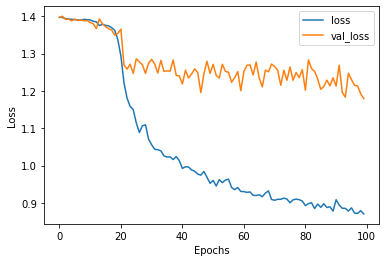

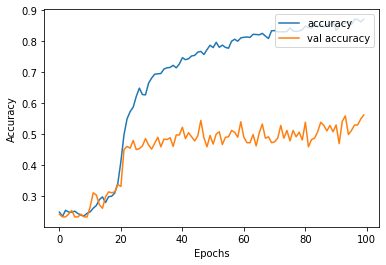

In [32]:
plot_learning_curve(history)